In [91]:
from __future__ import absolute_import, division, print_function, unicode_literals

%load_ext autoreload
%autoreload 2
%load_ext line_profiler

import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
%matplotlib inline
%config InlineBackend.figure_format = 'retina'  # adapt plots for retina displays
from IPython.core.debugger import set_trace

import utils

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler


In [92]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

In [93]:
from tqdm import tqdm_notebook
import collections
import os
import random
import time
import math
from sklearn.metrics import f1_score, accuracy_score
from sklearn.model_selection import train_test_split

# Datasets and Preprocessing

## WN18RR

In [5]:
%%bash

# Download and unzip.
#cd ../data
#mkdir wn18rr
#cd wn18rr
#wget https://github.com/TimDettmers/ConvE/raw/master/WN18RR.tar.gz
#tar -xvf WN18RR.tar.gz

In [4]:
root_dir = '../data/wn18rr'

In [5]:
train_df = pd.read_csv(os.path.join(root_dir, 'train.txt'), sep='\t', names=['subject', 'relation', 'object'])
val_df = pd.read_csv(os.path.join(root_dir, 'valid.txt'), sep='\t', names=['subject', 'relation', 'object'])
test_df = pd.read_csv(os.path.join(root_dir, 'test.txt'), sep='\t', names=['subject', 'relation', 'object'])
print(len(train_df), len(val_df), len(test_df))
train_df.head()

86835 3034 3134


,subject,relation,object
0,260881,_hypernym,260622
1,1332730,_derivationally_related_form,3122748
2,6066555,_derivationally_related_form,645415
3,9322930,_instance_hypernym,9360122
4,7193596,_derivationally_related_form,784342


In [6]:
entity_map = utils.IndexMap(train_df[['subject', 'object']], 
                            val_df[['subject', 'object']], 
                            test_df[['subject', 'object']])

relation_map = utils.IndexMap(train_df['relation'], 
                              val_df['relation'], 
                              test_df['relation'])

# TODO: Maybe rename num_nodes to num_entities.
num_nodes = len(entity_map)
num_relations = len(relation_map)

num_nodes, num_relations

(40943, 11)

### Option 1: Without relations

In [ ]:
# TODO: Refactored this. Check that it still works.

In [9]:
def to_tuples_array(df):
    subjects = df['subject'].map(entity_map.to_index)
    objects = df['object'].map(entity_map.to_index)
    return np.vstack([subjects, objects]).T

train_tuples = to_tuples_array(train_df)
val_tuples = to_tuples_array(train_df)
test_tuples = to_tuples_array(test_df)

In [20]:
adj_dict = collections.defaultdict(set)
for s, o in train_tuples:  # only use training set, so the network does not implicilty see the whole graph
    adj_dict[s].add(o)
    adj_dict[o].add(s)  # use non-directed edges
    
# Count connections in adj_dict. 
# Make sure that this number is twice the number of train triples (undirected edges!).
np.sum([len(s) for s in adj_dict.values()]), len(train_df)

(423056, 272115)

### Option 2: With relations

In [7]:
def to_triples_array(df):
    subjects = df['subject'].map(entity_map.to_index)
    objects = df['object'].map(entity_map.to_index)
    relations = df['relation'].map(relation_map.to_index)
    return np.vstack([subjects, objects, relations]).T

train_triples = to_triples_array(train_df)
val_triples = to_triples_array(val_df)
test_triples = to_triples_array(test_df)

# Required for filtered ranking evaluation to check if corrupted triples appear anywhere in the dataset.
all_triples = np.vstack([train_triples, val_triples, test_triples])

print(len(train_triples), len(val_triples), len(test_triples), len(all_triples))
train_triples

86835 3034 3134 93003


array([[ 1437,  1435,     3],
       [ 7360, 16907,     1],
       [22576,  3550,     1],
       ...,
       [ 4407,  4404,     3],
       [21464, 21468,     2],
       [ 5435,  4179,     9]])

In [8]:
relational_adj_dict = collections.defaultdict(lambda: collections.defaultdict(list))
for s, o, r in train_triples:  # only use training set, so the network does not implicilty see the whole graph
    relational_adj_dict[s][o].append(r)
    # TODO: Try using undirected edges here as well and see if it improves the results.
    
# Count connections in relational_adj_dict. 
# Make sure that this number is euqivalent to the number of train triples.
np.sum([len(l) for d in relational_adj_dict.values() for l in d.values()]), len(train_df)

(86835, 86835)

## FB15K-237

In [4]:
%%bash

# Download and unzip FB15K-237.
#cd ../data
#mkdir fb15k-237
#cd fb15k-237
#wget https://download.microsoft.com/download/8/7/0/8700516A-AB3D-4850-B4BB-805C515AECE1/FB15K-237.2.zip
#unzip FB15K-237.2.zip

In [94]:
root_dir = '../data/fb15k-237/Release'

In [95]:
train_df = pd.read_csv(os.path.join(root_dir, 'train.txt'), sep='\t', names=['subject', 'relation', 'object'])
val_df = pd.read_csv(os.path.join(root_dir, 'valid.txt'), sep='\t', names=['subject', 'relation', 'object'])
test_df = pd.read_csv(os.path.join(root_dir, 'test.txt'), sep='\t', names=['subject', 'relation', 'object'])
print(len(train_df), len(val_df), len(test_df))
train_df.head()

272115 17535 20466


,subject,relation,object
0,/m/027rn,/location/country/form_of_government,/m/06cx9
1,/m/017dcd,/tv/tv_program/regular_cast./tv/regular_tv_app...,/m/06v8s0
2,/m/07s9rl0,/media_common/netflix_genre/titles,/m/0170z3
3,/m/01sl1q,/award/award_winner/awards_won./award/award_ho...,/m/044mz_
4,/m/0cnk2q,/soccer/football_team/current_roster./sports/s...,/m/02nzb8


In [96]:
entity_map = utils.IndexMap(train_df[['subject', 'object']], 
                            val_df[['subject', 'object']], 
                            test_df[['subject', 'object']])

relation_map = utils.IndexMap(train_df['relation'], 
                              val_df['relation'], 
                              test_df['relation'])

# TODO: Maybe rename num_nodes to num_entities.
num_nodes = len(entity_map)
num_relations = len(relation_map)

num_nodes, num_relations

(14541, 237)

### Option 1: Without relations

In [ ]:
# TODO: Refactored this. Check that it still works.

In [9]:
def to_tuples_array(df):
    subjects = df['subject'].map(entity_map.to_index)
    objects = df['object'].map(entity_map.to_index)
    return np.vstack([subjects, objects]).T

train_tuples = to_tuples_array(train_df)
val_tuples = to_tuples_array(train_df)
test_tuples = to_tuples_array(test_df)

In [20]:
adj_dict = collections.defaultdict(set)
for s, o in train_tuples:  # only use training set, so the network does not implicilty see the whole graph
    adj_dict[s].add(o)
    adj_dict[o].add(s)  # use non-directed edges
    
# Count connections in adj_dict. 
# Make sure that this number is twice the number of train triples (undirected edges!).
np.sum([len(s) for s in adj_dict.values()]), len(train_df)

(423056, 272115)

### Option 2: With relations

In [97]:
def to_triples_array(df):
    subjects = df['subject'].map(entity_map.to_index)
    objects = df['object'].map(entity_map.to_index)
    relations = df['relation'].map(relation_map.to_index)
    return np.vstack([subjects, objects, relations]).T

train_triples = to_triples_array(train_df)
val_triples = to_triples_array(val_df)
test_triples = to_triples_array(test_df)

# Required for filtered ranking evaluation to check if corrupted triples appear anywhere in the dataset.
all_triples = np.vstack([train_triples, val_triples, test_triples])

print(len(train_triples), len(val_triples), len(test_triples), len(all_triples))
train_triples

272115 17535 20466 310116


array([[ 3818,  8942,   122],
       [  819,  9234,   230],
       [ 9791,   756,   140],
       ...,
       [11737,  4042,   198],
       [12535,  9678,    13],
       [ 3203, 10433,    11]])

In [98]:
relational_adj_dict = collections.defaultdict(lambda: collections.defaultdict(list))
for s, o, r in train_triples:  # only use training set, so the network does not implicilty see the whole graph
    relational_adj_dict[s][o].append(r)
    # TODO: Try using undirected edges here as well and see if it improves the results.
    
# Count connections in relational_adj_dict. 
# Make sure that this number is euqivalent to the number of train triples.
np.sum([len(l) for d in relational_adj_dict.values() for l in d.values()]), len(train_df)

(272115, 272115)

## FB15K-237: Numbers (Garcia-Duran et al. 2017)

In [49]:
%%bash

# Download numerical data from Garcia-Duran et al. (2017).
#cd data/fb15k-237
#wget https://raw.githubusercontent.com/nle-ml/mmkb/master/numTriples_FB15k.txt

In [47]:
numerical_features = pd.read_csv('data/fb15k-237/numTriples_FB15k.txt', sep='\t', names=['entity', 'attribute', 'value'])
numerical_features.head()

,entity,attribute,value
0,/m/06rf7,<http://rdf.freebase.com/ns/location.geocode.l...,9.704049e+00
1,/m/06rf7,<http://rdf.freebase.com/ns/location.geocode.l...,5.420868e+01
2,/m/06rf7,<http://rdf.freebase.com/ns/topic_server.popul...,2.837021e+06
3,/m/06rf7,<http://rdf.freebase.com/ns/location.location....,1.576318e+04
4,/m/04258w,<http://rdf.freebase.com/ns/people.person.date...,1.912667e+03


In [46]:
print('Entities in train set:', len(train_triples['subject'].unique()))
print('Entities with numerical features:', len(numerical_features['entity'].unique()))
print('Intersection (entities in train set with numerical features):', len(np.intersect1d(numerical_features['entity'].unique(), train_triples['subject'].unique())))

Entities in train set: 13781
Entities with numerical features: 12493
Intersection (entities in train set with numerical features): 12047


## FB15K-237: Numbers and texts (Kristiadi et al. 2018)

In [52]:
%%bash
#cd data/fb15k-237
#wget https://raw.githubusercontent.com/SmartDataAnalytics/LiteralE/master/data/FB15k-237/literals/numerical_literals.txt

--2018-03-05 14:44:55--  https://raw.githubusercontent.com/SmartDataAnalytics/LiteralE/master/data/FB15k-237/literals/numerical_literals.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.36.133
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.36.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5196154 (5.0M) [text/plain]
Saving to: 'numerical_literals.txt'

     0K .......... .......... .......... .......... ..........  0% 3.99M 1s
    50K .......... .......... .......... .......... ..........  1% 7.02M 1s
   100K .......... .......... .......... .......... ..........  2% 6.95M 1s
   150K .......... .......... .......... .......... ..........  3% 7.05M 1s
   200K .......... .......... .......... .......... ..........  4% 7.89M 1s
   250K .......... .......... .......... .......... ..........  5% 8.27M 1s
   300K .......... .......... .......... .......... ..........  6% 10.7M 1s
   350K .......... ....

In [53]:
numerical_features_kristiadi = pd.read_csv('data/fb15k-237/numerical_literals.txt', sep='\t', names=['entity', 'attribute', 'value'])
numerical_features_kristiadi.head()

,entity,attribute,value
0,/m/0265wl,http://rdf.freebase.com/ns/award.award_categor...,1965
1,/m/0n5c9,http://rdf.freebase.com/ns/location.location.area,1245.78428107
2,/m/0n5c9,http://rdf.freebase.com/ns/location.dated_loca...,1739
3,/m/0n5c9,http://rdf.freebase.com/ns/topic_server.popula...,462263
4,/m/0n5c9,http://rdf.freebase.com/ns/topic_server.popula...,482155


In [54]:
print('Entities in train set:', len(train_triples['subject'].unique()))
print('Entities with numerical features:', len(numerical_features_kristiadi['entity'].unique()))
print('Intersection (entities in train set with numerical features):', len(np.intersect1d(numerical_features_kristiadi['entity'].unique(), train_triples['subject'].unique())))

Entities in train set: 13781
Entities with numerical features: 9941
Intersection (entities in train set with numerical features): 9608


In [55]:
%%bash
#cd data/fb15k-237
#wget https://raw.githubusercontent.com/SmartDataAnalytics/LiteralE/master/data/FB15k-237/literals/text_literals.txt

--2018-03-05 14:46:55--  https://raw.githubusercontent.com/SmartDataAnalytics/LiteralE/master/data/FB15k-237/literals/text_literals.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.36.133
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.36.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 12991982 (12M) [text/plain]
Saving to: 'text_literals.txt'

     0K .......... .......... .......... .......... ..........  0% 1.24M 10s
    50K .......... .......... .......... .......... ..........  0% 4.23M 6s
   100K .......... .......... .......... .......... ..........  1% 6.51M 5s
   150K .......... .......... .......... .......... ..........  1% 6.65M 4s
   200K .......... .......... .......... .......... ..........  1% 7.22M 4s
   250K .......... .......... .......... .......... ..........  2% 10.1M 3s
   300K .......... .......... .......... .......... ..........  2% 8.66M 3s
   350K .......... .......... ..

In [56]:
text_features_kristiadi = pd.read_csv('data/fb15k-237/text_literals.txt', sep='\t', names=['entity', 'attribute', 'value'])
text_features_kristiadi.head()

,entity,attribute,value
0,/m/03j9ml,http://rdf.freebase.com/ns/common.topic.descri...,Maggie Roswell is an American film and televis...
1,/m/05cws2,http://rdf.freebase.com/ns/common.topic.descri...,Halesowen Town is an English association footb...
2,/m/0qxzd,http://rdf.freebase.com/ns/common.topic.descri...,"Hayward is a city located in Alameda County, C..."
3,/m/01h18v,http://rdf.freebase.com/ns/common.topic.descri...,About Schmidt is a 2002 American comedy-drama ...
4,/m/0c4y8,http://rdf.freebase.com/ns/common.topic.descri...,"Thomas Lanier ""Tennessee"" Williams III was an ..."


In [59]:
print('Entities in train set:', len(train_triples['subject'].unique()))
print('Entities with text features:', len(text_features_kristiadi['entity'].unique()))
print('Intersection (entities in train set with text features):', len(np.intersect1d(text_features_kristiadi['entity'].unique(), train_triples['subject'].unique())))

Entities in train set: 13781
Entities with text features: 14886
Intersection (entities in train set with text features): 13754


## FB15K-237: Images (ImageGraph; Onoro-Rubio et al. 2017)

In [92]:
%%bash
#cd data/fb15k-237
#wget https://www.dropbox.com/s/thct96phmypkaon/image-graph_urls.tar.gz
#tar -xvzf image-graph_urls.tar.gz

--2018-03-12 14:04:52--  https://www.dropbox.com/s/thct96phmypkaon/image-graph_urls.tar.gz
Resolving www.dropbox.com (www.dropbox.com)... 162.125.65.1
Connecting to www.dropbox.com (www.dropbox.com)|162.125.65.1|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://dl.dropboxusercontent.com/content_link/ct8mncZqLggve46aNBpGZJ3KEH93mLyB6cpivrWAZImNFpywuiCyOlVYZn5HDjXT/file [following]
--2018-03-12 14:04:52--  https://dl.dropboxusercontent.com/content_link/ct8mncZqLggve46aNBpGZJ3KEH93mLyB6cpivrWAZImNFpywuiCyOlVYZn5HDjXT/file
Resolving dl.dropboxusercontent.com (dl.dropboxusercontent.com)... 162.125.65.6
Connecting to dl.dropboxusercontent.com (dl.dropboxusercontent.com)|162.125.65.6|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 95528096 (91M) [application/octet-stream]
Saving to: 'image-graph_urls.tar.gz'

     0K .......... .......... .......... .......... ..........  0%  633K 2m27s
    50K .......... .......... .......... ...

In [164]:
# Download images via script `donwload-images.py`

## YAGO3-10

In [1]:
%%bash

# Download and unzip.
#cd ../data
#mkdir yago3-10
#cd yago3-10
#wget https://github.com/TimDettmers/ConvE/raw/master/YAGO3-10.tar.gz
#tar -xvf YAGO3-10.tar.gz

In [9]:
root_dir = '../data/yago3-10'

In [13]:
train_df = pd.read_csv(os.path.join(root_dir, 'train.txt'), sep='\t', names=['subject', 'relation', 'object'])
val_df = pd.read_csv(os.path.join(root_dir, 'valid.txt'), sep='\t', names=['subject', 'relation', 'object'])
test_df = pd.read_csv(os.path.join(root_dir, 'test.txt'), sep='\t', names=['subject', 'relation', 'object'])
print(len(train_df), len(val_df), len(test_df))
train_df.head()

1079040 5000 5000


,subject,relation,object
0,Chatou,isLocatedIn,France
1,Boo_Young-tae,playsFor,Yangju_Citizen_FC
2,Toni_Kuivasto,isAffiliatedTo,Helsingin_Jalkapalloklubi
3,Josh_Smith_(soccer),playsFor,Trinity_University_(Texas)
4,Albrecht_Dürer,diedIn,Nuremberg


In [14]:
entity_map = utils.IndexMap(train_df[['subject', 'object']], 
                            val_df[['subject', 'object']], 
                            test_df[['subject', 'object']])

relation_map = utils.IndexMap(train_df['relation'], 
                              val_df['relation'], 
                              test_df['relation'])

# TODO: Maybe rename num_nodes to num_entities.
num_nodes = len(entity_map)
num_relations = len(relation_map)

num_nodes, num_relations

(123182, 37)

### Option 1: Without relations

In [ ]:
# TODO: Refactored this. Check that it still works.

In [9]:
def to_tuples_array(df):
    subjects = df['subject'].map(entity_map.to_index)
    objects = df['object'].map(entity_map.to_index)
    return np.vstack([subjects, objects]).T

train_tuples = to_tuples_array(train_df)
val_tuples = to_tuples_array(train_df)
test_tuples = to_tuples_array(test_df)

In [20]:
adj_dict = collections.defaultdict(set)
for s, o in train_tuples:  # only use training set, so the network does not implicilty see the whole graph
    adj_dict[s].add(o)
    adj_dict[o].add(s)  # use non-directed edges
    
# Count connections in adj_dict. 
# Make sure that this number is twice the number of train triples (undirected edges!).
np.sum([len(s) for s in adj_dict.values()]), len(train_df)

(423056, 272115)

### Option 2: With relations

In [15]:
def to_triples_array(df):
    subjects = df['subject'].map(entity_map.to_index)
    objects = df['object'].map(entity_map.to_index)
    relations = df['relation'].map(relation_map.to_index)
    return np.vstack([subjects, objects, relations]).T

train_triples = to_triples_array(train_df)
val_triples = to_triples_array(val_df)
test_triples = to_triples_array(test_df)

# Required for filtered ranking evaluation to check if corrupted triples appear anywhere in the dataset.
all_triples = np.vstack([train_triples, val_triples, test_triples])

print(len(train_triples), len(val_triples), len(test_triples), len(all_triples))
train_triples

1079040 5000 5000 1089040


array([[ 19274,  36628,     27],
       [ 14098, 119794,     33],
       [111522,  46966,     21],
       ...,
       [ 99845, 115102,     21],
       [ 56124, 102655,     33],
       [ 31383,  51041,     21]])

In [16]:
relational_adj_dict = collections.defaultdict(lambda: collections.defaultdict(list))
for s, o, r in train_triples:  # only use training set, so the network does not implicilty see the whole graph
    relational_adj_dict[s][o].append(r)
    # TODO: Try using undirected edges here as well and see if it improves the results.
    
# Count connections in relational_adj_dict. 
# Make sure that this number is euqivalent to the number of train triples.
np.sum([len(l) for d in relational_adj_dict.values() for l in d.values()]), len(train_df)

(1079040, 1079040)

## YAGO3-10: Images (Pezheskpour et al. 2017)

Download manually from https://github.com/pouyapez/multim-kb-embeddings/tree/master/datasets/YAGO-10%20plus

Unpack into `../data/yago3-10-pezheskpour`

In [ ]:
import requests

def download_file_from_google_drive(id, destination):
    """
    Download a large file from Google Drive via a shared link.
    
    Large files cannot be downloaded from Google Drive via wget.
    From: https://stackoverflow.com/questions/25010369/wget-curl-large-file-from-google-drive
    """
    def get_confirm_token(response):
        for key, value in response.cookies.items():
            if key.startswith('download_warning'):
                return value

        return None

    def save_response_content(response, destination):
        CHUNK_SIZE = 32768

        with open(destination, "wb") as f:
            for chunk in response.iter_content(CHUNK_SIZE):
                if chunk: # filter out keep-alive new chunks
                    f.write(chunk)

    URL = "https://docs.google.com/uc?export=download"

    session = requests.Session()

    response = session.get(URL, params = { 'id' : id }, stream = True)
    token = get_confirm_token(response)

    if token:
        params = { 'id' : id, 'confirm' : token }
        response = session.get(URL, params = params, stream = True)

    save_response_content(response, destination)    

In [35]:
!mkdir ../data/yago3-10-pezheskpour

In [57]:
!ls ../data/yago3-10-pezheskpour

image.rar


In [58]:
!cat ../data/yago3-10-pezheskpour/image.rar

<!DOCTYPE html><html><head><title>Google Drive - Waarschuwing van viruscontrole</title><meta http-equiv="content-type" content="text/html; charset=utf-8"/>
&lt;link href=&#39;/static/doclist/client/css/1513150798-untrustedcontent.css&#39; type=&#39;text/css&#39; rel=&#39;stylesheet&#39;&gt;<style type="text/css">#gbar,#guser{font-size:13px;padding-top:0px !important;}#gbar{height:22px}#guser{padding-bottom:7px !important;text-align:right}.gbh,.gbd{border-top:1px solid #c9d7f1;font-size:1px}.gbh{height:0;position:absolute;top:24px;width:100%}@media all{.gb1{height:22px;margin-right:.5em;vertical-align:top}#gbar{float:left}}a.gb1,a.gb4{text-decoration:underline !important}a.gb1,a.gb4{color:#00c !important}.gbi .gb4{color:#dd8e27 !important}.gbf .gb4{color:#900 !important}
</style><script type="text/javascript"></script><link rel="icon" href="https://ssl.gstatic.com/docs/doclist/images/infinite_arrow_favicon_4.ico"/></head><body><div id=gbar><nobr><a target=_blank class=gb1 href="https://

In [56]:
download_file_from_google_drive('1qHbrTe_jGPJ1a_4KhFE1GCrLxaKAB-Q9', '../data/yago3-10-pezheskpour/image.rar')

In [49]:
!rm ../data/yago3-10-pezheskpour/image.rar

In [9]:
%%bash
ggID='1qHbrTe_jGPJ1a_4KhFE1GCrLxaKAB-Q9'  
ggURL='https://drive.google.com/uc?export=download'  
filename="$(curl -sc --insecure /tmp/gcokie "${ggURL}&id=${ggID}" | grep -o '="uc-name.*</span>' | sed 's/.*">//;s/<.a> .*//')"  
getcode="$(awk '/_warning_/ {print $NF}' /tmp/gcokie)"  
curl -Lb --insecure /tmp/gcokie "${ggURL}&confirm=${getcode}&id=${ggID}" -o "${filename}"  

<!DOCTYPE html><html><head><title>Google Drive - Waarschuwing van viruscontrole</title><meta http-equiv="content-type" content="text/html; charset=utf-8"/>
&lt;link href=&#39;/static/doclist/client/css/1513150798-untrustedcontent.css&#39; type=&#39;text/css&#39; rel=&#39;stylesheet&#39;&gt;<style type="text/css">#gbar,#guser{font-size:13px;padding-top:0px !important;}#gbar{height:22px}#guser{padding-bottom:7px !important;text-align:right}.gbh,.gbd{border-top:1px solid #c9d7f1;font-size:1px}.gbh{height:0;position:absolute;top:24px;width:100%}@media all{.gb1{height:22px;margin-right:.5em;vertical-align:top}#gbar{float:left}}a.gb1,a.gb4{text-decoration:underline !important}a.gb1,a.gb4{color:#00c !important}.gbi .gb4{color:#dd8e27 !important}.gbf .gb4{color:#900 !important}
</style><script type="text/javascript"></script><link rel="icon" href="https://ssl.gstatic.com/docs/doclist/images/infinite_arrow_favicon_4.ico"/></head><body><div id=gbar><nobr><a target=_blank class=gb1 href="https://

curl: (3) <url> malformed
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  3277    0  3277    0     0  10850      0 --:--:-- --:--:-- --:--:-- 10850


In [10]:
!ls

--insecure  download-images.py	images.rar  playground.ipynb  utils.pyc
README.md   image.rar		logs	    utils.py


In [11]:
!cat image.rar

<!DOCTYPE html><html><head><title>Google Drive - Waarschuwing van viruscontrole</title><meta http-equiv="content-type" content="text/html; charset=utf-8"/>
&lt;link href=&#39;/static/doclist/client/css/1513150798-untrustedcontent.css&#39; type=&#39;text/css&#39; rel=&#39;stylesheet&#39;&gt;<style type="text/css">#gbar,#guser{font-size:13px;padding-top:0px !important;}#gbar{height:22px}#guser{padding-bottom:7px !important;text-align:right}.gbh,.gbd{border-top:1px solid #c9d7f1;font-size:1px}.gbh{height:0;position:absolute;top:24px;width:100%}@media all{.gb1{height:22px;margin-right:.5em;vertical-align:top}#gbar{float:left}}a.gb1,a.gb4{text-decoration:underline !important}a.gb1,a.gb4{color:#00c !important}.gbi .gb4{color:#dd8e27 !important}.gbf .gb4{color:#900 !important}
</style><script type="text/javascript"></script><link rel="icon" href="https://ssl.gstatic.com/docs/doclist/images/infinite_arrow_favicon_4.ico"/></head><body><div id=gbar><nobr><a target=_blank class=gb1 href="https://

In [8]:
%%bash
curl -c /tmp/cookies "https://drive.google.com/uc?export=download&id=1qHbrTe_jGPJ1a_4KhFE1GCrLxaKAB-Q9" > /tmp/intermezzo.html
cat /tmp/intermezzo.html
echo $(cat /tmp/intermezzo.html | grep -Po 'uc-download-link" [^>]* href="\K[^"]*' | sed 's/\&amp;/\&/g')
curl -L -b /tmp/cookies "https://drive.google.com$(cat /tmp/intermezzo.html | grep -Po 'uc-download-link" [^>]* href="\K[^"]*' | sed 's/\&amp;/\&/g')" > 'images.rar'


<!DOCTYPE html><html><head><title>Google Drive - Waarschuwing van viruscontrole</title><meta http-equiv="content-type" content="text/html; charset=utf-8"/>
&lt;link href=&#39;/static/doclist/client/css/1513150798-untrustedcontent.css&#39; type=&#39;text/css&#39; rel=&#39;stylesheet&#39;&gt;<style type="text/css">#gbar,#guser{font-size:13px;padding-top:0px !important;}#gbar{height:22px}#guser{padding-bottom:7px !important;text-align:right}.gbh,.gbd{border-top:1px solid #c9d7f1;font-size:1px}.gbh{height:0;position:absolute;top:24px;width:100%}@media all{.gb1{height:22px;margin-right:.5em;vertical-align:top}#gbar{float:left}}a.gb1,a.gb4{text-decoration:underline !important}a.gb1,a.gb4{color:#00c !important}.gbi .gb4{color:#dd8e27 !important}.gbf .gb4{color:#900 !important}
</style><script type="text/javascript"></script><link rel="icon" href="https://ssl.gstatic.com/docs/doclist/images/infinite_arrow_favicon_4.ico"/></head><body><div id=gbar><nobr><a target=_blank class=gb1 href="https://

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  3267    0  3267    0     0  14986      0 --:--:-- --:--:-- --:--:-- 14986
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  3284    0  3284    0     0  15638      0 --:--:-- --:--:-- --:--:-- 15563


In [2]:
!ls

README.md	    image.rar	logs		  utils.py
download-images.py  images.rar	playground.ipynb  utils.pyc


In [3]:
!cat images.rar

<!DOCTYPE html><html><head><title>Google Drive - Waarschuwing van viruscontrole</title><meta http-equiv="content-type" content="text/html; charset=utf-8"/>
&lt;link href=&#39;/static/doclist/client/css/1513150798-untrustedcontent.css&#39; type=&#39;text/css&#39; rel=&#39;stylesheet&#39;&gt;<style type="text/css">#gbar,#guser{font-size:13px;padding-top:0px !important;}#gbar{height:22px}#guser{padding-bottom:7px !important;text-align:right}.gbh,.gbd{border-top:1px solid #c9d7f1;font-size:1px}.gbh{height:0;position:absolute;top:24px;width:100%}@media all{.gb1{height:22px;margin-right:.5em;vertical-align:top}#gbar{float:left}}a.gb1,a.gb4{text-decoration:underline !important}a.gb1,a.gb4{color:#00c !important}.gbi .gb4{color:#dd8e27 !important}.gbf .gb4{color:#900 !important}
</style><script type="text/javascript"></script><link rel="icon" href="https://ssl.gstatic.com/docs/doclist/images/infinite_arrow_favicon_4.ico"/></head><body><div id=gbar><nobr><a target=_blank class=gb1 href="https://

## MovieLens-100k

In [29]:
%%bash
#cd data
#mkdir movielens-100k
#wget http://files.grouplens.org/datasets/movielens/ml-100k.zip
#unzip ml-100k.zip

Archive:  ml-100k.zip
   creating: ml-100k/
  inflating: ml-100k/allbut.pl       
  inflating: ml-100k/mku.sh          
  inflating: ml-100k/README          
  inflating: ml-100k/u.data          
  inflating: ml-100k/u.genre         
  inflating: ml-100k/u.info          
  inflating: ml-100k/u.item          
  inflating: ml-100k/u.occupation    
  inflating: ml-100k/u.user          
  inflating: ml-100k/u1.base         
  inflating: ml-100k/u1.test         
  inflating: ml-100k/u2.base         
  inflating: ml-100k/u2.test         
  inflating: ml-100k/u3.base         
  inflating: ml-100k/u3.test         
  inflating: ml-100k/u4.base         
  inflating: ml-100k/u4.test         
  inflating: ml-100k/u5.base         
  inflating: ml-100k/u5.test         
  inflating: ml-100k/ua.base         
  inflating: ml-100k/ua.test         
  inflating: ml-100k/ub.base         
  inflating: ml-100k/ub.test         


--2018-03-08 01:22:47--  http://files.grouplens.org/datasets/movielens/ml-100k.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.34.235
Connecting to files.grouplens.org (files.grouplens.org)|128.101.34.235|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4924029 (4.7M) [application/zip]
Saving to: 'ml-100k.zip'

     0K .......... .......... .......... .......... ..........  1%  228K 21s
    50K .......... .......... .......... .......... ..........  2%  460K 15s
   100K .......... .......... .......... .......... ..........  3% 5.27M 10s
   150K .......... .......... .......... .......... ..........  4% 7.53M 8s
   200K .......... .......... .......... .......... ..........  5%  494K 8s
   250K .......... .......... .......... .......... ..........  6% 4.55M 7s
   300K .......... .......... .......... .......... ..........  7%  511K 7s
   350K .......... .......... .......... .......... ..........  8% 7.69M 6s
   400K .......... .......... ...

In [13]:
# TODO: Do not use complete dataset here, but one of the official splits.
triples = pd.read_csv('../data/movielens-100k/ml-100k/u.data', sep='\t', names=['user_id', 'item_id', 'rating', 'timestamp'])
triples.head()

,user_id,item_id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [14]:
user_map = utils.IndexMap(triples['user_id'])
item_map = utils.IndexMap(triples['item_id'], start_index=len(user_map))

In [15]:
num_nodes = len(user_map) + len(item_map)
num_nodes

2625

In [16]:
feat_data = np.eye(num_nodes)

In [17]:
num_classes = 2
labels = np.zeros(num_nodes)
labels[:len(user_map)] = 1
labels = labels.reshape(-1, 1)
labels

array([[1.],
       [1.],
       [1.],
       ...,
       [0.],
       [0.],
       [0.]])

In [18]:
# TODO: Refactor to methods create_adj_dict(subjects, objects) and create_relational_adj_dict(subjects, objects, relations).
adj_dict = collections.defaultdict(set)
for i, row in tqdm_notebook(triples.iterrows(), total=len(triples)):
    user_index = user_map.to_index(row['user_id'])
    item_index = item_map.to_index(row['item_id'])
    adj_dict[user_index].add(item_index)
    adj_dict[item_index].add(user_index)  # undirected edges

HBox(children=(IntProgress(value=0, max=100000), HTML(value=u'')))

In [19]:
# TODO: Refactor to methods create_adj_dict(subjects, objects) and create_relational_adj_dict(subjects, objects, relations).
directed_adj_dict = collections.defaultdict(set)
for i, row in tqdm_notebook(triples.iterrows(), total=len(triples)):
    user_index = user_map.to_index(row['user_id'])
    item_index = item_map.to_index(row['item_id'])
    directed_adj_dict[user_index].add(item_index)
    #directed_adj_dict[item_index].add(user_index)  # undirected edges

HBox(children=(IntProgress(value=0, max=100000), HTML(value=u'')))

In [20]:
# For relational model.
rating_map = utils.IndexMap(triples['rating'])
num_relations = len(rating_map)
num_relations

5

In [21]:
relational_adj_dict = collections.defaultdict(dict)
for i, row in tqdm_notebook(triples.iterrows(), total=len(triples)):
    user_index = user_map.to_index(row['user_id'])
    item_index = item_map.to_index(row['item_id'])
    rating_index = rating_map.to_index(row['rating'])
    
    if item_index in relational_adj_dict[user_index]:
        print('Edge {} -> {} already exists with relation {}'.format(user_index, item_index, 
                                                                     relational_adj_dict[user_index][item_index]))
        print('This edge will be overwritten by the new relation {}'.format(rating_index))
    relational_adj_dict[user_index][item_index] = rating_index
    relational_adj_dict[item_index][user_index] = rating_index

HBox(children=(IntProgress(value=0, max=100000), HTML(value=u'')))

In [22]:
# For link prediction.
from_nodes = triples['user_id'].map(user_map.to_index)
to_nodes = triples['item_id'].map(item_map.to_index)
relations = triples['rating'].map(rating_map.to_index)

triples_arr = np.vstack([from_nodes, to_nodes, relations]).T
len(triples_arr), triples_arr

(100000, array([[ 195, 1184,    2],
        [ 185, 1244,    2],
        [  21, 1319,    0],
        ...,
        [ 275, 2032,    0],
        [  12, 1167,    1],
        [  11, 1145,    2]]))

## MovieLens-100k: Metadata (included with original dataset)

In [86]:
from keras.utils import to_categorical

In [90]:
movies = pd.read_csv('data/movielens-100k/ml-100k/u.item', sep='|', names=['movie_id', 'movie_title', 'release_date', 'video_release_date', 'IMDb_URL', 'unknown', 'Action', 'Adventure', 'Animation', 'Childrens', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western'])
movies.head()

,movie_id,movie_title,release_date,video_release_date,IMDb_URL,unknown,Action,Adventure,Animation,Childrens,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [91]:
users = pd.read_csv('data/movielens-100k/ml-100k/u.user', sep='|', names=['user_id', 'age', 'gender', 'occupation', 'zip_code'])
users.head()

,user_id,age,gender,occupation,zip_code
0,1,24,M,technician,85711
1,2,53,F,other,94043
2,3,23,M,writer,32067
3,4,24,M,technician,43537
4,5,33,F,other,15213


In [ ]:
# TODO: How to encode those features? Movies and users have inherently different features/feature vectors!?

## MovieLens-100k: Images (Pezheskpour et al. 2017)

Download manually from https://github.com/pouyapez/multim-kb-embeddings/tree/master/datasets/Movielens-100k%20plus

Unpack into `../data/movielens-100k-pezheskpour`

In [25]:
!ls ../data

cora	   fb15k-237-garcia-duran  movielens-100k
cora.tgz   fb15k-237-kristiadi	   movielens-100k-pezheskpour
fb15k-237  fb15k-237-onoro-rubio   yago3-10


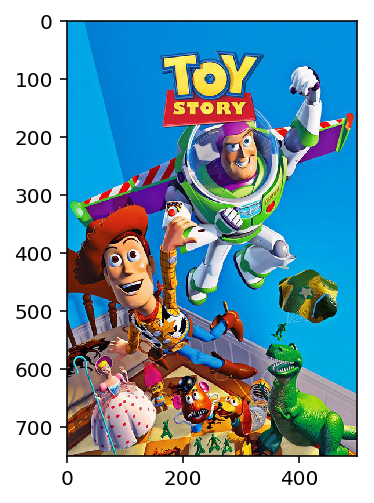

In [79]:
plt.imshow(plt.imread('data/movielens-100k/image/1.jpg'))

## Cora

In [ ]:
from graphsage.model import load_cora

In [ ]:
feat_data, labels, adj_lists = load_cora()
num_nodes, num_feats = feat_data.shape
num_classes = len(np.unique(labels))

num_nodes, num_feats, num_classes

In [ ]:
# Optional: Remove features and use identity matrix instead. 
# Set learning rate to 10 for this.
feat_data = np.eye(num_nodes)
num_feats = num_nodes

num_nodes, num_feats, num_classes

# GCN Layers

In [99]:
class GraphConvolution(nn.Module):
    def __init__(self, in_features, out_features, num_nodes, in_features_func, adj_dict, activation=F.relu):
        nn.Module.__init__(self)
        self.in_features = in_features
        self.out_features = out_features
        self.in_features_func = in_features_func
        self.adj_dict = adj_dict
        # TODO: Add adj_array (see RelationalGraphConvolution).
        self.activation = activation
        
        self.weight = nn.Parameter(torch.FloatTensor(out_features, in_features))
        nn.init.xavier_uniform(self.weight)
        
        
    # TODO: Refactor this.
    # TODO: Profile this with lprun and see how much time each step takes up (especially creating the tensors!).
    def aggregate(self, nodes, adj_dict, num_sample=10, include_self=False):
        """Return a vector for each node in `nodes` by mean-aggregating feature vectors from its neighborhood (or a sample thereof)."""
        
        # Step 1: For each node, sample some neighbors that we aggregate information from. 
        
        # TODO: Move this up to constructor or even outside of this class.
        #adj_array = np.array([adj_dict[i] for i in range(num_nodes)])
        #sampled_neighbors_per_node = adj_array[nodes]
        #print(sampled_neighbors_per_node)
        sampled_neighbors_per_node = [adj_dict[node] for node in nodes]
        
        # TODO: Replace stuff below by this line, check if it works.
        #sampled_neighbors_per_node = [adj_lists[node].update([node]) if include_self else adj_lists[node] for node in nodes]
        
        # TODO: Check if this improves the network. 
        #       Also, in graphsage, this is done after the sampling step (which doesn't make much sense though).
        # TODO: Check that node is not added to adj_lists permanently.
        if include_self:
            for sampled_neighbors, node in zip(sampled_neighbors_per_node, nodes):
                sampled_neighbors.add(node)
        
        if num_sample is not None:
            # TODO: See if local pointers bring speed improvements (see GraphSage code).
            for i in range(len(sampled_neighbors_per_node)):
                if num_sample <= len(sampled_neighbors_per_node[i]):
                    sampled_neighbors_per_node[i] = set(random.sample(sampled_neighbors_per_node[i], num_sample))
                    
                    
        # Step 2: Find the unique neighbors in all sampled neighbors.
        
        unique_neighbors = list(set.union(*sampled_neighbors_per_node))
        unique_neighbors_to_index = {neighbor: i for i, neighbor in enumerate(unique_neighbors)}
        
        if unique_neighbors:
            
            # Step 3: Get embeddings for these unique neighbors from the underlying layer 
            #         (e.g. another GraphConvolution layer or a fixed feature matrix).
            
            unique_neighbors_tensor = torch.LongTensor(unique_neighbors)
            if self.is_cuda():
                unique_neighbors_tensor = unique_neighbors_tensor.cuda()
            unique_neighbors_embeddings = self.in_features_func(unique_neighbors_tensor)
            

            # Step 4: For each input node, sum the embeddings of its (sampled) neighbors, 
            #         using the embeddings obtained above. The algorithm here uses a masking matrix 
            #         to find the neighbor embeddings for each node and add them in one step. 
            
            # TODO: See if this can be implemented in an easier way (i.e. without mask).
            
            # TODO: Check if this really needs to be a variable.
            # TODO: Maybe store mask in self and fill it with zeros here, so it doesn't have to initalized in each forward pass. 
            mask = Variable(torch.zeros(len(nodes), len(unique_neighbors)), requires_grad=False)
            if self.is_cuda():
                mask = mask.cuda()
            # TODO: Understand and rename variables here.
            column_indices = [unique_neighbors_to_index[neighbor] for sampled_neighbors in sampled_neighbors_per_node for neighbor in sampled_neighbors]
            row_indices = [i for i in range(len(sampled_neighbors_per_node)) for j in range(len(sampled_neighbors_per_node[i]))]
            mask[row_indices, column_indices] = 1

            # TODO: Is this actually the number of neighbors, i.e. does it correspond 
            #       to the normalization constant in RGCN paper?
            num_neighbors = mask.sum(1, keepdim=True)
            mask /= num_neighbors + 1e-10  # prevent zero division
            
            #set_trace()
            
            # TODO: Check what the actual output of this term is.
            return mask.mm(unique_neighbors_embeddings)
        else:
            # TODO: If there are no neighbors, this currently returns a zero vector. Is this correct?
            # TODO: Building this variable and moving it to cuda takes up a lot of time (15 % for Link Prediction),
            #       speed this up somehow.
            zeros = Variable(torch.zeros(len(nodes), self.in_features), requires_grad=False)
            if self.is_cuda():
                zeros = zeros.cuda()
            return zeros

        
    def forward(self, nodes):
        neighborhood_features = self.aggregate(nodes, self.adj_dict, include_self=True)
        
        # TODO: Maybe add features of nodes themselves,
        #       or include nodes themselves in sampling process in aggregate function (as in GraphSAGE,
        #       but collides with RGCN use of aggregate function).
        #node_features = self.in_features_func(torch.LongTensor(nodes))
        
        return self.activation(neighborhood_features.mm(self.weight.t()))
    
    def is_cuda(self):
        return self.weight.is_cuda

In [100]:
# TODO: Add a parameter regularization = {None | 'basis' | 'block'} and a method get_relation_weight(relation).
class RelationalGraphConvolution(GraphConvolution):
    def __init__(self, in_features, out_features, num_nodes, num_relations, in_features_func, relational_adj_dict, 
                 activation=F.relu):
        
        super(RelationalGraphConvolution, self).__init__(in_features, out_features, num_nodes, in_features_func, None, activation)
        
        # TODO: Maybe create adj_dict from train_triples directly in here.
        self.relational_adj_dict = relational_adj_dict
        self.adj_array = np.array([set(relational_adj_dict[i].keys()) for i in range(num_nodes)], dtype=object)
        
        self.num_relations = num_relations
        
        self.relation_weights = nn.ParameterList()
        for relation in range(num_relations):
            self.relation_weights.append(nn.Parameter(torch.FloatTensor(out_features, in_features)))
            nn.init.xavier_uniform(self.relation_weights[relation])
        # TODO: Maybe store the relation weights in a 3D tensor instead of a ParameterList. 
        #       Uses about the same amount of memory. Check if it brings speed improvements.
        #self.weights_per_relation = nn.Parameter(torch.FloatTensor(num_relations, out_features, in_features))
            
    def forward(self, nodes, num_sample=10):
        # TODO: Refactor this by passing nodes as tensor in the first place.
        if type(nodes) == torch.LongTensor or type(nodes) == torch.cuda.LongTensor:
            nodes_tensor = nodes
        else:
            nodes_tensor = torch.LongTensor(nodes)
            if self.is_cuda():
                nodes_tensor = nodes_tensor.cuda()
                
        #print(self.name, ': Call to forward with', len(nodes), 'nodes:', np.asarray(nodes[:5]))
                
        # Step 1: Get embeddings for all nodes in the mini-batch from the underlying layer.
        #         (e.g. another GraphConvolution layer or a fixed feature matrix).
        try:
            input_embeddings = self.in_features_func(nodes_tensor, num_sample=num_sample)
        except TypeError:
            #print(self.name, 'Failed to pass num_sample to underlying layer')
            input_embeddings = self.in_features_func(nodes_tensor)
        # TODO: Maybe add hyperparameter that determines which fraction of the self-embedding to use, 
        #       and which fraction of the aggregated embedding. See if this has an effect 
        #       or if weights find the best way to combine the two embeddings themselves.
        #       Alternatively, include self-embedding in sampling.
        output_embeddings = input_embeddings.mm(self.weight.t())  # terms for relations will be added to this
                
                
        # Step 2: For each node, sample some neighbors that we aggregate information from. 
        # TODO: Refactor this to method sample_neighbors(nodes), which uses self.num_sample and self.relational_adj_dict.
        sampled_neighbors_per_node = self.adj_array[nodes]
        #print(self.name, num_sample)
        if num_sample is not None:
            # TODO: Check if local pointers bring speed improvements (see GraphSage code).
            for i in range(len(sampled_neighbors_per_node)):
                if num_sample <= len(sampled_neighbors_per_node[i]):
                    # TODO: Check if np.random.choice is faster.
                    sampled_neighbors_per_node[i] = set(random.sample(sampled_neighbors_per_node[i], num_sample))
                    
        #print(self.name, sampled_neighbors_per_node[13])
            
        # Step 3: Find the unique neighbors in all sampled neighbors. 
        #         If there are no unique neighbors, return zero embeddings.
        unique_neighbors = list(set.union(*sampled_neighbors_per_node))
        unique_neighbors_to_index = {neighbor: i for i, neighbor in enumerate(unique_neighbors)}
        
        if not unique_neighbors:
            # TODO: Maybe create and store this once, and return it each time here.
            zeros = Variable(torch.zeros(len(nodes), self.out_features), requires_grad=False)
            if self.is_cuda():
                zeros = zeros.cuda()
            #print('No unique neighbors, returning zero. Nodes:', nodes)
            return zeros
        
        # Step 3: Get embeddings for these unique neighbors from the underlying layer 
        #         (e.g. another GraphConvolution layer or a fixed feature matrix).
        # TODO: Investigate how much time processing only the unique neighbors actually saves vs the overhead 
        #       done here to reassign unique neighbors to the nodes (for a realistic batch size!).
        unique_neighbors_tensor = torch.LongTensor(unique_neighbors)
        if self.is_cuda():
            unique_neighbors_tensor = unique_neighbors_tensor.cuda()
            
        # If underlying layer is a GraphConvolution layer, pass along num_sample, otherwise omit it.
        try:
            unique_neighbors_embeddings = self.in_features_func(unique_neighbors_tensor, num_sample=num_sample)
        except TypeError:
            #print(self.name, 'Failed to pass num_sample to underlying layer')
            unique_neighbors_embeddings = self.in_features_func(unique_neighbors_tensor)
                
        # Step 4: For each relation, average the embeddings of sampled neighbors, 
        #         using the embeddings obtained above. The algorithm here uses a masking matrix 
        #         to find the neighbor embeddings for each node and add them in one step. 
        # TODO: Try creating torch.zeros(1, 1).cuda() in the constructor, and expanding it here via repeat.
        mask = Variable(torch.zeros(len(nodes), len(unique_neighbors)), requires_grad=False)
        if self.is_cuda():
            mask = mask.cuda()

        for relation in range(num_relations):
            # TODO: Check which of these three alternatives for masking is quickest:
            #       1) Iterate over all nodes and sampled neighbor, and assign column/row indices only 
            #          if edge has relation (current implementation).
            #          Potentially iterates very often over the same arrays.
            #       2) Compile one object sampled_neighbors_per_node_per_relation beforehand, 
            #          and do the usual mask-building for each relation in there.
            #       3) Build one mask for each relation and set values in the mask belonging 
            #          to the relation directly.

            column_indices = []
            for node, sampled_neighbors in zip(nodes, sampled_neighbors_per_node):
                for neighbor in sampled_neighbors:
                    if relation in self.relational_adj_dict[node][neighbor]:
                        column_indices.append(unique_neighbors_to_index[neighbor])
                        
            if column_indices:  # if column_indices is empty, there are no sampled neighbors with this relation, so skip it
                row_indices = []
                for i, node in enumerate(nodes):
                    for j, neighbor in enumerate(sampled_neighbors_per_node[i]):
                        if relation in self.relational_adj_dict[node][neighbor]:
                            row_indices.append(i)

                mask[row_indices, column_indices] = 1
                
                # TODO: Here, I divide by the number of neighbors with this relation.
                #       In R-GCN paper, they divide by the number of all neighbors (across relations).
                #       Implement this by summing up these values over all relations.
                #       Also ask Michael, how the results with other normalization constants were.
                num_neighbors_per_node = mask.sum(1, keepdim=True)
                mask /= num_neighbors_per_node + 1e-10  # prevent zero division

                # Non-zero value at (i, j) in mask means that embedding of unique neighbor j contributes 
                # to aggregated embedding for node i (weighted by the value in mask). Formally:
                # aggregated_node_embeddings[i] = \sum_j {mask[i, j] * unique_neighbors_embeddings[j]}
                aggregated_embeddings = mask.mm(unique_neighbors_embeddings)

                # Step 5: Multiply the aggregated feature vectors with the relation-specific weight matrix.
                output_embeddings += aggregated_embeddings.mm(self.relation_weights[relation].t())
                
                del aggregated_embeddings
                
            del mask

            return self.activation(output_embeddings)

In [ ]:
# TODO: Implement this new version that uses triples directly. The current implementation still uses one relation per edge!
# TODO: Check runtime and performance against old version.
class RelationalGraphConvolution(GraphConvolution):
    def __init__(self, in_features, out_features, num_nodes, num_relations, in_features_func, train_triples, 
                 num_sample=10, activation=F.relu):
        
        super(RelationalGraphConvolution, self).__init__(in_features, out_features, num_nodes, in_features_func, None, num_sample, activation)
        
        # TODO: Maybe create adj_dict from train_triples directly in here.
        #self.relational_adj_dict = relational_adj_dict
        #self.adj_array = np.array([set(relational_adj_dict[i].keys()) for i in range(num_nodes)], dtype=object)
        self.train_triples = train_triples.copy()
        
        self.num_relations = num_relations
        
        # TODO: Maybe store the relation weights in a 3D tensor instead of a ParameterList. 
        #       Uses about the same amount of memory. Check if it brings speed improvements.
        self.relation_weights = nn.ParameterList()
        for relation in range(num_relations):
            self.relation_weights.append(nn.Parameter(torch.FloatTensor(out_features, in_features)))
            nn.init.xavier_uniform(self.relation_weights[relation])
        #self.weights_per_relation = nn.Parameter(torch.FloatTensor(num_relations, out_features, in_features))
            
    def forward(self, nodes):
        # TODO: Refactor this by passing nodes as tensor in the first place.
        if type(nodes) == torch.LongTensor or type(nodes) == torch.cuda.LongTensor:
            nodes_tensor = nodes
        else:
            nodes_tensor = torch.LongTensor(nodes)
            if self.is_cuda():
                nodes_tensor = nodes_tensor.cuda()
                
        # Step 1: Get embeddings for all nodes in the mini-batch from the underlying layer.
        #         (e.g. another GraphConvolution layer or a fixed feature matrix).
        input_embeddings = self.in_features_func(nodes_tensor)
        output_embeddings = input_embeddings.mm(self.weight.t())  # terms for relations will be added to this
                
                
        # Step 2: For each node, sample some neighbors that we aggregate information from. 
        #sampled_neighbors_per_node = [set(self.relational_adj_dict[node]) for node in nodes]
        # TODO: Refactor this to method sample_neighbors(nodes), which uses self.num_sample and self.relational_adj_dict.
#         sampled_neighbors_per_node = self.adj_array[nodes]
#         if self.num_sample is not None:
#             # TODO: Check if local pointers bring speed improvements (see GraphSage code).
#             for i in range(len(sampled_neighbors_per_node)):
#                 if self.num_sample <= len(sampled_neighbors_per_node[i]):
#                     # TODO: Check if np.random.choice is faster.
#                     sampled_neighbors_per_node[i] = set(random.sample(sampled_neighbors_per_node[i], self.num_sample))
        # TODO: Check how long this takes. Maybe create triples_per_node for all nodes in constructor.
        sampled_triples_per_node = [train_triples[train_triples[:, 0] == node] for node in nodes]
        if self.num_sample is not None:
            for i in range(len(sampled_triples_per_node)):
                if self.num_sample <= len(sampled_triples_per_node[i]):
                    sampled_triples_per_node[i] = sampled_triples_per_node[i][np.random.choice(len(sampled_triples_per_node[i], size=self.num_sample))]

            
        # Step 3: Find the unique neighbors in all sampled neighbors. 
        #         If there are no unique neighbors, return zero embeddings.
        unique_neighbors = np.unique(np.hstack([sampled_triples[:, 1] for sampled_triples in sampled_triples_per_neighbor]))#list(set.union(*sampled_neighbors_per_node))
        unique_neighbors_to_index = {neighbor: i for i, neighbor in enumerate(unique_neighbors)}
        
        # TODO: Check if this works with array.
        if not unique_neighbors:
            # TODO: Maybe create and store this once, and return it each time here.
            zeros = Variable(torch.zeros(len(nodes), self.out_features), requires_grad=False)
            if self.is_cuda():
                zeros = zeros.cuda()
            print('No unique neighbors, returning zero. Nodes:', nodes)
            return zeros
        
        # Step 3: Get embeddings for these unique neighbors from the underlying layer 
        #         (e.g. another GraphConvolution layer or a fixed feature matrix).
        # TODO: Investigate how much time processing only the unique neighbors actually saves vs the overhead 
        #       done here to reassign unique neighbors to the nodes (for a realistiv batch size!)
        unique_neighbors_tensor = torch.LongTensor(unique_neighbors)
        if self.is_cuda():
            unique_neighbors_tensor = unique_neighbors_tensor.cuda()
        unique_neighbors_embeddings = self.in_features_func(unique_neighbors_tensor)
                
        # Step 4: For each relation, average the embeddings of sampled neighbors, 
        #         using the embeddings obtained above. The algorithm here uses a masking matrix 
        #         to find the neighbor embeddings for each node and add them in one step. 
        mask = Variable(torch.zeros(len(nodes), len(unique_neighbors)), requires_grad=False)
        if self.is_cuda():
            mask = mask.cuda()

        for relation in range(num_relations):
            # TODO: Check which of these three alternatives for masking is quickest:
            #       1) Iterate over all nodes and sampled neighbor, and assign column/row indices only 
            #          if edge has relation (current method).
            #          Potentially iterates very often over the same arrays.
            #       2) Compile one object sampled_neighbors_per_node_per_relation beforehand, 
            #          and do the usual mask-building for each relation in there.
            #       3) Build one mask for each relation and set values in the mask belonging 
            #          to the relation directly.

            column_indices = []
            for node, sampled_neighbors in zip(nodes, sampled_neighbors_per_node):
                for neighbor in sampled_neighbors:
                    if relation in self.relational_adj_dict[node][neighbor]:
                        column_indices.append(unique_neighbors_to_index[neighbor])
                        
            if column_indices:  # if column_indices is empty, there are no sampled neighbors with this relation, so skip it
                row_indices = []
                for i, node in enumerate(nodes):
                    for j, neighbor in enumerate(sampled_neighbors_per_node[i]):
                        if relation in self.relational_adj_dict[node][neighbor]:
                            row_indices.append(i)

                mask[row_indices, column_indices] = 1
                
                # TODO: Here, I divide by the number of neighbors with this relation.
                #       In R-GCN paper, they divide by the number of all neighbors (across relations).
                #       Implement this by summing up these values over all relations.
                #       Also ask Michael, how the results with other normalization constants were.
                num_neighbors_per_node = mask.sum(1, keepdim=True)
                mask /= num_neighbors_per_node + 1e-10  # prevent zero division

                # Non-zero value at (i, j) in mask means that embedding of unique neighbor j contributes 
                # to aggregated embedding for node i (weighted by the value in mask). Formally:
                # aggregated_node_embeddings[i] = \sum_j {mask[i, j] * unique_neighbors_embeddings[j]}
                aggregated_embeddings = mask.mm(unique_neighbors_embeddings)

                # Step 5: Multiply the aggregated feature vectors with the relation-specific weight matrix.
                output_embeddings += aggregated_embeddings.mm(self.relation_weights[relation].t())

            return self.activation(output_embeddings)

# Supervised Classification (without relations and features)

In [16]:
class SupervisedGCN(nn.Module):

    def __init__(self, num_classes, feat_data, adj_lists):
        nn.Module.__init__(self)
        
        num_nodes, num_features = feat_data.shape
        
        features = nn.Embedding(num_nodes, num_features)
        features.weight = nn.Parameter(torch.FloatTensor(feat_data), requires_grad=False)
        
        self.graph_conv1 = GraphConvolution(num_features, 128, features, adj_lists, activation=F.relu)
        self.graph_conv2 = GraphConvolution(128, 128, self.graph_conv1, adj_lists, activation=F.relu)
        
        # TODO: Converges faster without bias. See if this holds for real data.
        self.dense = nn.Linear(128, num_classes, bias=False)
        nn.init.xavier_uniform(self.dense.weight)

    def forward(self, nodes):
        node_embeddings = self.graph_conv2(nodes)  # implicitly calls underlying conv layers
        scores = self.dense(node_embeddings)
        return scores

In [17]:
# Run algorithm.
np.random.seed(1)
random.seed(1)

use_cuda = True

net = SupervisedGCN(num_classes, feat_data, adj_dict)
if use_cuda and torch.cuda.is_available():
    print('Moving network to GPU.')
    net.cuda()

rand_indices = np.random.permutation(num_nodes)
test = rand_indices[:500]
val = rand_indices[500:1000]
train = list(rand_indices[1000:])

loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(filter(lambda parameter: parameter.requires_grad, net.parameters()), lr=0.01)

times = []
for batch in range(100):
    #batch_nodes = Variable(torch.LongTensor(train[:256]), requires_grad=False)
    batch_nodes = train[:256]
    random.shuffle(train)
    
    start_time = time.time()
    
    optimizer.zero_grad()
    
    output = net(batch_nodes)
    target = Variable(torch.LongTensor(labels[np.array(batch_nodes)]).squeeze(), requires_grad=False)
    if use_cuda and torch.cuda.is_available():
        target = target.cuda()
    loss = loss_function(output, target)
    loss.backward()
    optimizer.step()
    
    end_time = time.time()
    times.append(end_time-start_time)
    print(batch, loss.data[0])
    
    if batch % 10 == 0:
        val_output = net(val) 
        print("Validation Accuracy:", accuracy_score(labels[val], val_output.cpu().data.numpy().argmax(axis=1)))
        print("Validation F1:", f1_score(labels[val], val_output.cpu().data.numpy().argmax(axis=1), average="micro"))
        print("Average batch time:", np.mean(times))

Moving network to GPU.
0 0.692896485329
Validation Accuracy: 0.634
Validation F1: 0.634
Average batch time: 0.1904129981994629
1 0.667886972427
2 0.612422704697
3 0.529688358307
4 0.42939171195
5 0.319299668074
6 0.250481367111
7 0.250862538815
8 0.194756746292
9 0.183181121945
10 0.152682065964
Validation Accuracy: 1.0
Validation F1: 1.0
Average batch time: 0.06710889122702858
11 0.123559959233
12 0.0772185176611
13 0.0510042309761
14 0.0365696884692
15 0.0187319889665
16 0.0101769454777
17 0.00538808479905
18 0.00236057955772
19 0.000963839702308
20 0.000447682105005
Validation Accuracy: 1.0
Validation F1: 1.0
Average batch time: 0.06511790411812919
21 0.00017000362277
22 8.49878415465e-05
23 3.43294814229e-05
24 1.98967754841e-05
25 1.02631747723e-05
26 4.99188899994e-06
27 2.59838998318e-06
28 1.47707760334e-06
29 2.25566327572e-06
30 1.52364373207e-06
Validation Accuracy: 1.0
Validation F1: 1.0
Average batch time: 0.06462906252953314
31 4.22820448875e-07
32 1.02631747723e-06
33 6.

In [174]:
# Alternative version with epochs and progressbar.
# TODO: Update CUDA support.

from tqdm import tqdm

# Run algorithm.
np.random.seed(1)
random.seed(1)

net = SupervisedGCN(num_classes, feat_data, adj_lists)
#    net.cuda()

rand_indices = np.random.permutation(num_nodes)
test = rand_indices[:500]
val = rand_indices[500:1000]
train = list(rand_indices[1000:])

loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(filter(lambda parameter: parameter.requires_grad, net.parameters()), lr=0.01)

num_epochs = 10
batch_size = 256

for epoch in range(1, num_epochs+1):
    
    
    #tqdm.write('Epoch {}/{}:'.format(epoch, num_epochs-1))

    random.shuffle(train)
    num_batches = int(len(train) / batch_size)
    
    with tqdm(total=num_batches, desc='Epoch {}/{}'.format(epoch, num_epochs), ncols=110) as pbar:

        for batch in range(num_batches):

            #print('\tBatch {}/{}:'.format(batch, num_batches-1), end=' ')

            from_node = batch * batch_size
            to_node = min((batch + 1) * batch_size, len(train))
            batch_nodes = train[from_node:to_node]

            optimizer.zero_grad()

            output = net(batch_nodes)
            target = Variable(torch.LongTensor(labels[np.array(batch_nodes)]).squeeze(), requires_grad=False)
            loss = loss_function(output, target)
            loss.backward()
            optimizer.step()

            pbar.set_postfix(loss=loss.data[0])
            #print(loss.data[0])
            
            pbar.update()

        val_output = net(val) 
        val_acc = accuracy_score(labels[val], val_output.data.numpy().argmax(axis=1))
        val_f1 = f1_score(labels[val], val_output.data.numpy().argmax(axis=1), average="micro")
        pbar.set_postfix(loss=loss.data[0], val_acc=val_acc, val_f1=val_f1)


Epoch 10/10: 100%|██████████████████████████| 6/6 [00:01<00:00,  6.64it/s, loss=1.61e-13, val_acc=1, val_f1=1]


# Supervised Classification with relations

In [16]:
class SupervisedRGCN(nn.Module):

    def __init__(self, num_classes, feat_data, adj_lists_per_relation):
        nn.Module.__init__(self)
        
        num_nodes, num_features = feat_data.shape
        features = nn.Embedding(num_nodes, num_features)
        features.weight = nn.Parameter(torch.FloatTensor(feat_data), requires_grad=False)
        
        self.graph_conv1 = RelationalGraphConvolution(num_features, 128, features, adj_lists_per_relation)
        self.graph_conv2 = RelationalGraphConvolution(128, 128, self.graph_conv1, adj_lists_per_relation)
        
        # TODO: Converges faster without bias. See if this holds for real data.
        self.dense = nn.Linear(128, num_classes, bias=False)
        nn.init.xavier_uniform(self.dense.weight)

    def forward(self, nodes):
        node_embeddings = self.graph_conv2(nodes)  # implicitly calls underlying conv layers
        #print(node_embeddings.sum())
        scores = self.dense(node_embeddings)  # softmax is applied by CrossEntropyLoss
        return scores


In [19]:
# Run algorithm.
np.random.seed(1)
random.seed(1)

use_cuda = True

net = SupervisedRGCN(num_classes, feat_data, adj_lists_per_relation)
if use_cuda and torch.cuda.is_available():
    net.cuda()

rand_indices = np.random.permutation(num_nodes)
test = rand_indices[:500]
val = rand_indices[500:1000]
train = list(rand_indices[1000:])
print('Training on', len(train), 'nodes')

loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(filter(lambda parameter: parameter.requires_grad, net.parameters()), lr=0.01)

times = []
for batch in range(100):
    #batch_nodes = Variable(torch.LongTensor(train[:256]), requires_grad=False)
    
    random.shuffle(train)
    batch_nodes = train[:256]
    
    start_time = time.time()
    
    optimizer.zero_grad()
    
    output = net(batch_nodes)
    target = Variable(torch.LongTensor(labels[np.array(batch_nodes)]).squeeze(), requires_grad=False)
    if use_cuda and torch.cuda.is_available():
        target = target.cuda()
    loss = loss_function(output, target)
    loss.backward()
    optimizer.step()
    
    end_time = time.time()
    times.append(end_time-start_time)
    print(batch, loss.data[0])
    
    if batch % 10 == 0:
        val_output = net(val) 
        print("Validation Accuracy:", accuracy_score(labels[val], val_output.cpu().data.numpy().argmax(axis=1)))
        print("Validation F1:", f1_score(labels[val], val_output.cpu().data.numpy().argmax(axis=1), average="micro"))
        print("Average batch time:", np.mean(times))

Training on 1625 nodes
0 0.690665960312
Validation Accuracy: 1.0
Validation F1: 1.0
Average batch time: 0.19429492950439453
1 0.56970000267
2 0.422767162323
3 0.333146989346
4 0.244888827205
5 0.187118723989
6 0.116868980229
7 0.0616429522634
8 0.031066134572
9 0.0174713600427
10 0.00768253672868
Validation Accuracy: 1.0
Validation F1: 1.0
Average batch time: 0.1721870248967951
11 0.00573282269761
12 0.00264684483409
13 0.00133715290576
14 0.00102490792051
15 0.00063599832356
16 0.000389914028347
17 0.000162918586284
18 0.000254969578236
19 0.000120875425637
20 8.7134540081e-06
Validation Accuracy: 1.0
Validation F1: 1.0
Average batch time: 0.16201589221046084
21 8.99191945791e-06
22 1.94106251001e-05
23 1.6987323761e-06
24 1.47707760334e-06
25 3.20374965668e-07
26 4.7042965889e-05
27 1.33737921715e-05
28 8.17980617285e-06
29 8.38190317154e-08
30 1.30385160446e-07
Validation Accuracy: 1.0
Validation F1: 1.0
Average batch time: 0.1524044159919985
31 2.64495611191e-07
32 1.63912773132e-0

# Link Prediction

## Models

In [101]:
class DistMultDecoder(nn.Module):
    
    def __init__(self, embedding_size, num_relations, dropout=0):
        super(DistMultDecoder, self).__init__()
        self.relation_embedding = nn.Embedding(num_relations, embedding_size)
        nn.init.xavier_normal(self.relation_embedding.weight)
        self.dropout = torch.nn.Dropout(dropout)
        
    def forward(self, subject_embeddings, object_embeddings, relations):
        # TODO: Give relations as tensor in the first place.
        relations_tensor = Variable(torch.LongTensor(relations), requires_grad=False)
        if self.relation_embedding.weight.is_cuda:
            relations_tensor = relations_tensor.cuda()
            
        subject_embeddings = self.dropout(subject_embeddings)
        object_embeddings = self.dropout(object_embeddings)
            
        relation_embeddings = self.relation_embedding(relations_tensor)
        scores = (subject_embeddings * relation_embeddings * object_embeddings).sum(1, keepdim=True)
        
        del subject_embeddings, object_embeddings, relation_embeddings
        
        return scores

In [102]:
class BaseEmbeddingModel(nn.Module):
    
    def __init__(self, embedding_size, num_nodes, num_relations, decoder=None):
        super(BaseEmbeddingModel, self).__init__()
        self.entity_embedding = nn.Embedding(num_nodes, embedding_size)
        self.decoder = decoder
        # TODO: Do not initalize embeddings via xavier normalization, that doesn't really make sense 
        #       because it depends on the number of embeddings.
        nn.init.xavier_normal(self.entity_embedding.weight)
        
    def forward(self, triples):
        # TODO: Give triples as variables here in the first place.
        subject_tensor = Variable(torch.LongTensor(triples[:, 0]), requires_grad=False)
        if self.entity_embedding.weight.is_cuda:
            subject_tensor = subject_tensor.cuda()
        subject_embeddings = self.entity_embedding(subject_tensor)
            
        object_tensor = Variable(torch.LongTensor(triples[:, 1]), requires_grad=False)
        if self.entity_embedding.weight.is_cuda:
            object_tensor = object_tensor.cuda()
        object_embeddings = self.entity_embedding(object_tensor)
            
        return self.decoder(subject_embeddings, object_embeddings, triples[:, 2])
    
    # TODO: Dirty workaround for ranking evaluation. Handle triples/entities as tensors everywhere, 
    #       than net.get_embeddings can be substituted by net.entitiy_embedding in the ranking objects.
    def get_embeddings(self, entities):
        entities_tensor = Variable(torch.LongTensor(entities), requires_grad=False)
        if self.entity_embedding.weight.is_cuda:
            entities_tensor = entities_tensor.cuda()
            
        return self.entity_embedding(entities_tensor)

In [103]:
class DistMult(BaseEmbeddingModel):
    
    def __init__(self, embedding_size, num_nodes, num_relations, dropout=0):
        decoder = DistMultDecoder(embedding_size, num_relations, dropout)
        super(DistMult, self).__init__(embedding_size, num_nodes, num_relations, decoder)

In [104]:
class TransEDecoder(nn.Module):
    
    def __init__(self, embedding_size, num_relations, dropout=0, p_norm=2):
        super(TransEDecoder, self).__init__()
        self.relation_embedding = nn.Embedding(num_relations, embedding_size)
        # TODO: Does xavier make sense here?
        nn.init.xavier_normal(self.relation_embedding.weight)
        self.dropout = torch.nn.Dropout(dropout)
        self.dissimilarity = nn.PairwiseDistance(p=p_norm)
        
    def forward(self, subject_embeddings, object_embeddings, relations):
        # TODO: Give relations as tensor in the first place.
        relations_tensor = Variable(torch.LongTensor(relations), requires_grad=False)
        if self.relation_embedding.weight.is_cuda:
            relations_tensor = relations_tensor.cuda()
            
        subject_embeddings = self.dropout(subject_embeddings)
        object_embeddings = self.dropout(object_embeddings)
            
        relation_embeddings = self.relation_embedding(relations_tensor)
        scores = self.dissimilarity(subject_embeddings + relation_embeddings, object_embeddings)
        
        del subject_embeddings, object_embeddings, relation_embeddings
        
        return scores

In [105]:
class TransE(BaseEmbeddingModel):
    
    def __init__(self, embedding_size, num_nodes, num_relations, dropout=0):
        decoder = TransEDecoder(embedding_size, num_relations, dropout)
        super(TransE, self).__init__(embedding_size, num_nodes, num_relations, decoder)

In [106]:
class UnsupervisedRGCN(nn.Module):

    # TODO: Add Dropout.
    def __init__(self, num_nodes, num_relations, relational_adj_dict, node_features=None, embedding_size=128, dist_mult_dropout=0):
        nn.Module.__init__(self)
        
        if node_features is not None:
            # Use a dense embedding matrix initialized from node_features.
            # TODO: Maybe give node_features as tensor in the first place.
            node_features_size = node_features.shape[1]
            features_embedding = nn.Embedding(num_nodes, node_features_size)
            features_embedding.weight = nn.Parameter(torch.FloatTensor(node_features), requires_grad=False)
            print('Initialized from node_features')
        else:
            # Use a one-hot embedding that is generated on the fly during training.
            # Saves 0.8 GB GPU memory on FB15k-237 without increasing the runtime 
            # (vs using a node_features matrix with one-hot embeddings).
            node_features_size = num_nodes
            features_embedding = OneHotEmbedding(num_nodes, cuda=True)
            print('Initialized with OneHotEmbedding')
        
        self.graph_conv1 = RelationalGraphConvolution(node_features_size, embedding_size, num_nodes, num_relations, 
                                                      features_embedding, relational_adj_dict)
        self.graph_conv1.name='conv1'
        self.graph_conv2 = RelationalGraphConvolution(embedding_size, embedding_size, num_nodes, num_relations, 
                                                      self.graph_conv1, relational_adj_dict)
        self.graph_conv2.name='conv2'
        # TODO: Rename to decoder to make it more general.
        self.dist_mult = DistMultDecoder(embedding_size, num_relations, dist_mult_dropout)
        
    def forward(self, triples, num_sample=10):
        # TODO: This computes lots of duplicates if nodes appear as subject and object.
        #       As a quick solution, stack subjects and objects, run them through the network together, 
        #       and then separate the embeddings. Check how this changes memory requirements.
#         subjects = triples[:, 0]
#         objects = triples[:, 1]
#         all_embeddings = self.graph_conv2(np.hstack([subjects, objects]), num_sample=num_sample)
#         subject_embeddings = all_embeddings[:len(subjects)]
#         object_embeddings = all_embeddings[len(subjects):]

        
        subject_embeddings = self.graph_conv2(triples[:, 0], num_sample=num_sample)  # implicitly calls underlying conv layers
        object_embeddings = self.graph_conv2(triples[:, 1], num_sample=num_sample)  # implicitly calls underlying conv layers
        
        scores = self.dist_mult(subject_embeddings, object_embeddings, triples[:, 2])
        del subject_embeddings, object_embeddings
        return scores

In [107]:
class OneHotEmbedding(nn.Module):
    
    def __init__(self, num_embeddings, cuda=False):
        super(OneHotEmbedding, self).__init__()
        self.num_embeddings = num_embeddings
        self.row = torch.zeros(num_embeddings)
        # TODO: Figure out a way to move row to cuda as soon as cuda is called on the net.
        if cuda:
            self.row = self.row.cuda()
        
    def forward(self, indices):
        self.row.zero_()
        embeddings = self.row.repeat(len(indices), 1)
        embeddings[range(len(indices)), indices] = 1
        return Variable(embeddings, requires_grad=False)

## Utils for training and evaluation

In [108]:
# TODO: Maybe make sure that corrupted triples are truly negative, ie they do not appear anywhere in the dataset.
#       This is not done in TransE etc, but may improve training.
def sample_negatives(triples, num_nodes, num_negatives=1):
    """Return a copy of triples where either the subject or the object in each triple is replaced with a random entity."""
    corrupted_triples = []
    for i in range(num_negatives):
        for s, o, r in triples:
            if np.random.rand() < 0.5:
                corrupted_triples.append((np.random.randint(num_nodes), o, r))
            else:
                corrupted_triples.append((s, np.random.randint(num_nodes), r))
    return np.asarray(corrupted_triples)

class SimplifiedMarginRankingLoss(nn.MarginRankingLoss):
    """Same as torch.nn.MarginRankingLoss, but input1 is always higher than input2."""
    
    def __call__(self, input1, input2):
        target = Variable(torch.ones(input1.shape), requires_grad=False)
        if input1.is_cuda:
            target = target.cuda()
        return super(SimplifiedMarginRankingLoss, self).__call__(input1, input2, target)

In [109]:
class RankingEvaluation(object):
    
    def __init__(self, triples, num_nodes, filter_triples=None, show_progress=False):
        self.triples = triples
        self.num_nodes = num_nodes
        self.filtered = (filter_triples is not None)
        
        if self.filtered:
            
            self.true_triples_subject_corrupted_per_triple = []
            self.true_triples_object_corrupted_per_triple = []
            
            for s, o, r in tqdm_notebook(self.triples) if show_progress else self.triples:
                # TODO: Rename this.
                self.true_triples_subject_corrupted_per_triple.append(
                    filter_triples[np.logical_and(filter_triples[:, 1] == o, filter_triples[:, 2] == r)][:, 0])
                self.true_triples_object_corrupted_per_triple.append(
                    filter_triples[np.logical_and(filter_triples[:, 0] == s, filter_triples[:, 2] == r)][:, 1])
            
                #print(triple, len(self.true_triples_subject_corrupted_per_triple[-1]), len(self.true_triples_object_corrupted_per_triple[-1]))
                
            print('Subject-corrupted triples: Found on average', np.mean([len(arr) for arr in self.true_triples_subject_corrupted_per_triple]), 'triples that were actually true')
            print('Object-corrupted triples: Found on average', np.mean([len(arr) for arr in self.true_triples_object_corrupted_per_triple]), 'triples that were actually true')
                
                
    def _get_rank(self, scoring_model, subject_embeddings, object_embeddings, relations, n, true_triples=None):
        scores_gpu = scoring_model(subject_embeddings, object_embeddings, relations)
        scores = scores_gpu.cpu().data.numpy()
        del scores_gpu  # TODO: Check if this improves GPU memory.
        #scores = utils.predict(scoring_model, [subject_embeddings, object_embeddings, relations], batch_size=16, move_to_cuda=True, move_to_cpu=True)
        score_true_triple = scores[n]
        
        # TODO: Maybe do not delete the scores, but set them to 0, like in ConvE code. 
        #       Especially in combination with the pytorch speedup of ranking, see below.
        if self.filtered:
            scores_corrupted_triples = np.delete(scores, true_triples)
            #print('Removed', len(scores) - len(scores_corrupted_triples), 'triples')
        else:
            scores_corrupted_triples = np.delete(scores, [n])
            
        # TODO: This takes up 53 % of the time in this function. Speed it up by doing this directly in pytorch.
        #       See ConvE code (evaluation.py):
        #       max_values, argsort1 = torch.sort(pred1, 1, descending=True)
        #       argsort1 = argsort1.cpu().numpy()
        #       rank1 = np.where(argsort1[i]==e2[i, 0])[0][0]
        rank = sp.stats.rankdata(-np.hstack([score_true_triple, scores_corrupted_triples]), 'ordinal')[0]  # apply negative so highest score is 
        
        #rank_unfiltered = sp.stats.rankdata(-scores, 'ordinal')[n]
        #print(rank, rank_unfiltered, '--> changed', rank_unfiltered-rank, 'ranks')
        
        return rank
    
    
    def __call__(self, embedding_model, scoring_model, verbose=False, show_progress=False, forward_kwargs=None):
        
        # TODO: Maybe refactor this by giving all_node_embeddings as an argument here. Then each model can compute the node embeddings itselves (or if it's a simple embedding model, just give the embedding matrix), and this class only does the scoring. Then, add a function get_embedding_matrix() to RGC-layer that yield a tensor with the complete embedding matrix.
        #all_node_embeddings = embedding_model(np.arange(self.num_nodes))
        all_node_embeddings = utils.predict(embedding_model, np.arange(self.num_nodes), batch_size=32, to_tensor=True, forward_kwargs=forward_kwargs)
        ranks = []

        for i, triple in enumerate(tqdm_notebook(self.triples)) if show_progress else enumerate(self.triples):

            repeated_subject_embedding = all_node_embeddings[triple[0]].expand(self.num_nodes, -1)
            repeated_object_embedding = all_node_embeddings[triple[1]].expand(self.num_nodes, -1)
            repeated_relation = np.repeat(triple[2], self.num_nodes)

            # TODO: Refactor this.
            rank_subject_corrupted = self._get_rank(scoring_model, all_node_embeddings, repeated_object_embedding, repeated_relation, triple[0], self.true_triples_subject_corrupted_per_triple[i] if self.filtered else None)
            ranks.append(rank_subject_corrupted)
            
            rank_object_corrupted = self._get_rank(scoring_model, repeated_subject_embedding, all_node_embeddings, repeated_relation, triple[1], self.true_triples_object_corrupted_per_triple[i] if self.filtered else None)
            ranks.append(rank_object_corrupted)
            
            # TODO: Check if these are more or less the same.
            if verbose: print(rank_subject_corrupted, rank_object_corrupted)
            
        ranks = np.asarray(ranks)
        
        def hits_at(n):
            return np.sum(ranks <= n) / len(ranks)
        
        del all_node_embeddings

        return np.mean(ranks), np.mean(1 / ranks), hits_at(1), hits_at(3), hits_at(10)

## Training

In [110]:
# Set up dataset splits and ranking evaluation. 
#train_triples, val_triples, test_triples = utils.train_val_test_split(all_triples, val_size=5000, test_size=5000, random_state=0)

filtered = True
train_ranker = RankingEvaluation(train_triples[:5000], num_nodes, filter_triples=all_triples if filtered else None, show_progress=True)
val_ranker = RankingEvaluation(val_triples, num_nodes, filter_triples=all_triples if filtered else None, show_progress=True)
test_ranker = RankingEvaluation(test_triples, num_nodes, filter_triples=all_triples if filtered else None, show_progress=True)

HBox(children=(IntProgress(value=0, max=5000), HTML(value=u'')))

Exception in thread Thread-89:
Traceback (most recent call last):
  File "/home/jrieke/anaconda2/lib/python2.7/threading.py", line 801, in __bootstrap_inner
    self.run()
  File "/home/jrieke/anaconda2/lib/python2.7/site-packages/tqdm/_tqdm.py", line 148, in run
    for instance in self.tqdm_cls._instances:
  File "/home/jrieke/anaconda2/lib/python2.7/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



Subject-corrupted triples: Found on average 309.3452 triples that were actually true
Object-corrupted triples: Found on average 34.7736 triples that were actually true


HBox(children=(IntProgress(value=0, max=17535), HTML(value=u'')))


Subject-corrupted triples: Found on average 440.97005988023955 triples that were actually true
Object-corrupted triples: Found on average 37.21083547191331 triples that were actually true


HBox(children=(IntProgress(value=0, max=20466), HTML(value=u'')))


Subject-corrupted triples: Found on average 435.1897293071436 triples that were actually true
Object-corrupted triples: Found on average 37.55184207954657 triples that were actually true


In [111]:
# TODO: Refactor to utils.
def seed_all(seed=None):
    """Set seed for random, numpy.random, torch and torch.cuda."""
    random.seed(seed)
    np.random.seed(seed)
    if seed is None:
        torch.manual_seed(np.random.randint(1e6))
        torch.cuda.manual_seed(np.random.randint(1e6))
    else:
        torch.manual_seed(seed)
        torch.cuda.manual_seed(seed)

In [42]:
force_cpu = False
history = utils.History()

In [20]:
# Option 1: R-GCN
seed_all(0)
net = UnsupervisedRGCN(num_nodes, num_relations, relational_adj_dict, embedding_size=200, dist_mult_dropout=0)#200)
embedding_func, scoring_func = net.graph_conv2, net.dist_mult  # required for ranking
if torch.cuda.is_available() and not force_cpu:
    net.cuda()
    print('Moved network to GPU')
loss_function = SimplifiedMarginRankingLoss(1)
optimizer = torch.optim.Adam(filter(lambda parameter: parameter.requires_grad, net.parameters()), lr=0.001)
batch_size = 32
train_forward_kwargs = dict(num_sample=10)
val_forward_kwargs = dict(num_sample=None)

Initialized with OneHotEmbedding
Moved network to GPU


In [45]:
# Option 2: DistMult
# TODO: In original DistMult paper, embeddings are normalized to unit length after each training step. Improves model empricially.
seed_all(0)
net = TransE(200, num_nodes, num_relations, 0.4)
embedding_func, scoring_func = net.get_embeddings, net.decoder  # required for ranking
if torch.cuda.is_available() and not force_cpu:
    net.cuda()
    print('Moved network to GPU')
loss_function = SimplifiedMarginRankingLoss(1)
optimizer = torch.optim.Adam(filter(lambda parameter: parameter.requires_grad, net.parameters()), lr=0.001)
batch_size = 32
train_forward_kwargs = dict()
val_forward_kwargs = dict()

Moved network to GPU


In [46]:
# Training loop. Run this again to continue training on the same network. 
    
num_epochs = 10

for epoch in range(num_epochs):

    print('Epoch {}/{}'.format(epoch+1, num_epochs))

    # TODO: Implement training via classification of correct/corrupted triples like this:
    # num_negatives = 2
    # train_and_negatives = np.hstack([train, sample_negatives(train, num_nodes, num_negatives)])
    # print(train_and_negatives.shape)
    # y = Variable(torch.zeros(len(train_and_negatives), 1), requires_grad=False)
    # y[:len(train), 0] = 1
    # if torch.cuda.is_available() and not force_cpu:
    #     y = y.cuda()
    # TODO: Wrap train_and_negatives and y in list of tuples or make split_into_batches accept multiple arrays.
    # batches = tqdm_notebook(split_into_batches(train_and_negatives, batch_size, shuffle=True))
    
    net.train()

    # TODO: Maybe use tensor for batch_triples and wrap everything here in pytorch DataSet/DataLoader.
    batches = utils.split_into_batches(train_triples, batch_size=batch_size, shuffle=True)#[:3]
    batches = tqdm_notebook(batches)
    batches_history = utils.History()
    
#     running_metrics = collections.defaultdict(lambda: 0)

    for batch, batch_triples in enumerate(batches):

        optimizer.zero_grad()
        output = net(batch_triples, **train_forward_kwargs)
        output_negative = net(sample_negatives(batch_triples, num_nodes), **train_forward_kwargs)
            
        loss = loss_function(output, output_negative)
        # loss = loss_function(output, y)
        loss.backward()
        optimizer.step()

        # TODO: Especially getting the loss takes quite some time (as much as a single prediction for dist mult), maybe replace it by a running metric directly in torch.
        batches_history.log_metric('loss', loss.data[0])
        batches_history.log_metric('acc', (output > output_negative).float().mean().data[0])
        batches_history.log_metric('mean_diff', (output - output_negative).mean().data[0])
        batches_history.log_metric('median_diff', (output - output_negative).median().data[0])
#         running_metrics['loss'] += loss
#         running_metrics['acc'] += (output > output_negative).float().mean()
#         running_metrics['mean_diff'] += (output - output_negative).mean()
#         running_metrics['median_diff'] += (output - output_negative).median()

        if batch % 10 == 0:
            batches.set_postfix(batches_history.latest())

        # TODO: Check if this improves memory usage.
        del output, output_negative, loss
        
#     for key in running_metrics:
#         running_metrics[key] /= len(batches)


    net.eval()
    # TODO: Set variables to volatile=True when evaluating on the validation set to save GPU memory (instead of or in combination with to_tensor).
    val_output = utils.predict(net, val_triples, forward_kwargs=val_forward_kwargs, batch_size=32, to_tensor=True)
    val_output_negative = utils.predict(net, sample_negatives(val_triples, num_nodes), forward_kwargs=val_forward_kwargs, batch_size=32, to_tensor=True)

    # TODO: Maybe implement these metrics in a batched fashion.
    history.log_metric('loss', batches_history.mean('loss'), 
                       loss_function(val_output, val_output_negative).data[0], 'Loss', print_=True)
    history.log_metric('acc', batches_history.mean('acc'), 
                       (val_output > val_output_negative).float().mean(), 'Accuracy', print_=True)
    history.log_metric('mean_diff', batches_history.mean('mean_diff'), 
                       (val_output - val_output_negative).mean(), 'Mean Difference', print_=True)
    history.log_metric('median_diff', batches_history.mean('median_diff'), 
                       (val_output - val_output_negative).median(), 'Median Difference', print_=True)

    del val_output, val_output_negative
    
    
    print('Running rank evaluation for train in {} setting...'.format('filtered' if train_ranker.filtered else 'raw'))
    mean_rank, mean_rec_rank, hits_1, hits_3, hits_10 = train_ranker(embedding_func, scoring_func, forward_kwargs=val_forward_kwargs)
    print('Running rank evaluation for val in {} setting...'.format('filtered' if val_ranker.filtered else 'raw'))
    val_mean_rank, val_mean_rec_rank, val_hits_1, val_hits_3, val_hits_10 = val_ranker(embedding_func, scoring_func, forward_kwargs=val_forward_kwargs)
    
    history.log_metric('mean_rank', mean_rank, val_mean_rank, 'Mean Rank', print_=True)
    history.log_metric('mean_rec_rank', mean_rec_rank, val_mean_rec_rank, 'Mean Rec Rank', print_=True)
    history.log_metric('hits_1', hits_1, val_hits_1, 'Hits@1', print_=True)
    history.log_metric('hits_3', hits_3, val_hits_3, 'Hits@3', print_=True)
    history.log_metric('hits_10', hits_10, val_hits_10, 'Hits@10', print_=True)

    print('-'*80)
    print()

Epoch 1/10


HBox(children=(IntProgress(value=0, max=8504), HTML(value=u'')))


Loss:       0.581064834597
Val Loss:   0.385564059019

Accuracy:       0.797772410504
Val Accuracy:   0.876988887787

Mean Difference:       0.528342221082
Val Mean Difference:   0.799032688141

Median Difference:       0.417367774758
Val Median Difference:   0.814248085022

Running rank evaluation for train in filtered setting...
Running rank evaluation for val in filtered setting...
Mean Rank:       1439.828
Val Mean Rank:   1648.31699458

Mean Rec Rank:       0.117629056782
Val Mean Rec Rank:   0.132361916046

Hits@1:       0.0762
Val Hits@1:   0.0865412033077

Hits@3:       0.1267
Val Hits@3:   0.144368406045

Hits@10:       0.1946
Val Hits@10:   0.218135158255

--------------------------------------------------------------------------------

Epoch 2/10


HBox(children=(IntProgress(value=0, max=8504), HTML(value=u'')))


Loss:       0.332926499334
Val Loss:   0.269930154085

Accuracy:       0.882522195437
Val Accuracy:   0.904704868793

Mean Difference:       0.988221889854
Val Mean Difference:   1.10686993599

Median Difference:       0.969665335297
Val Median Difference:   1.14707756042

Running rank evaluation for train in filtered setting...
Running rank evaluation for val in filtered setting...
Mean Rank:       1068.4496
Val Mean Rank:   1271.37704591

Mean Rec Rank:       0.107898384622
Val Mean Rec Rank:   0.120068085546

Hits@1:       0.0633
Val Hits@1:   0.0730824066153

Hits@3:       0.1153
Val Hits@3:   0.128485885372

Hits@10:       0.1905
Val Hits@10:   0.209865982321

--------------------------------------------------------------------------------

Epoch 3/10


HBox(children=(IntProgress(value=0, max=8504), HTML(value=u'')))


Loss:       0.25802686436
Val Loss:   0.229795217514

Accuracy:       0.907289758381
Val Accuracy:   0.916395783424

Mean Difference:       1.22202853189
Val Mean Difference:   1.28529596329

Median Difference:       1.21384637042
Val Median Difference:   1.33904314041

Running rank evaluation for train in filtered setting...
Running rank evaluation for val in filtered setting...
Mean Rank:       906.2452
Val Mean Rank:   1112.62400912

Mean Rec Rank:       0.104938204817
Val Mean Rec Rank:   0.113445769781

Hits@1:       0.0576
Val Hits@1:   0.0599657827203

Hits@3:       0.1135
Val Hits@3:   0.125691474194

Hits@10:       0.1922
Val Hits@10:   0.214827487881

--------------------------------------------------------------------------------

Epoch 4/10


HBox(children=(IntProgress(value=0, max=8504), HTML(value=u'')))


Loss:       0.221066788947
Val Loss:   0.207652911544

Accuracy:       0.919095541725
Val Accuracy:   0.922155678272

Mean Difference:       1.38191056209
Val Mean Difference:   1.41222715378

Median Difference:       1.37340460164
Val Median Difference:   1.47738075256

Running rank evaluation for train in filtered setting...
Running rank evaluation for val in filtered setting...
Mean Rank:       795.2953
Val Mean Rank:   1030.71750784

Mean Rec Rank:       0.103088257603
Val Mean Rec Rank:   0.109422119124

Hits@1:       0.0519
Val Hits@1:   0.0514399771885

Hits@3:       0.1143
Val Hits@3:   0.124779013402

Hits@10:       0.1968
Val Hits@10:   0.217137154263

--------------------------------------------------------------------------------

Epoch 5/10


HBox(children=(IntProgress(value=0, max=8504), HTML(value=u'')))


Loss:       0.199929564076
Val Loss:   0.194192990661

Accuracy:       0.926227054144
Val Accuracy:   0.922326803207

Mean Difference:       1.49887421331
Val Mean Difference:   1.50349998474

Median Difference:       1.49249469536
Val Median Difference:   1.56669044495

Running rank evaluation for train in filtered setting...
Running rank evaluation for val in filtered setting...
Mean Rank:       725.9308
Val Mean Rank:   981.91996008

Mean Rec Rank:       0.104940874569
Val Mean Rec Rank:   0.112248242929

Hits@1:       0.0566
Val Hits@1:   0.0583974907328

Hits@3:       0.1086
Val Hits@3:   0.118990590248

Hits@10:       0.2014
Val Hits@10:   0.221842030225

--------------------------------------------------------------------------------

Epoch 6/10


HBox(children=(IntProgress(value=0, max=8504), HTML(value=u'')))


Loss:       0.184376210984
Val Loss:   0.18488574028

Accuracy:       0.931401089892
Val Accuracy:   0.927003145218

Mean Difference:       1.59886392493
Val Mean Difference:   1.59193336964

Median Difference:       1.59384826897
Val Median Difference:   1.66160583496

Running rank evaluation for train in filtered setting...
Running rank evaluation for val in filtered setting...


KeyboardInterrupt: 

In [ ]:
def train_rgcn(run_name, save_best=False, num_epochs=10, force_cpu=False):
    
    history = utils.History()
    
    net = UnsupervisedRGCN(num_nodes, num_relations, relational_adj_dict, embedding_size=200, dist_mult_dropout=0.5)#200)
    embedding_func, scoring_func = net.graph_conv2, net.dist_mult  # required for ranking
    if torch.cuda.is_available() and not force_cpu:
        net.cuda()
        print('Moved network to GPU')
    loss_function = SimplifiedMarginRankingLoss(1)
    optimizer = torch.optim.Adam(filter(lambda parameter: parameter.requires_grad, net.parameters()), lr=0.001)
    batch_size = 32
    train_forward_kwargs = dict(num_sample=10)
    val_forward_kwargs = dict(num_sample=None)

    for epoch in range(num_epochs):

        print('Epoch {}/{}'.format(epoch+1, num_epochs))

        net.train()

        # TODO: Maybe use tensor for batch_triples and wrap everything here in pytorch DataSet/DataLoader.
        batches = utils.split_into_batches(train_triples, batch_size=batch_size, shuffle=True)#[:3]
        batches = tqdm_notebook(batches)
        batches_history = utils.History()


        for batch, batch_triples in enumerate(batches):

            optimizer.zero_grad()
            output = net(batch_triples, **train_forward_kwargs)
            output_negative = net(sample_negatives(batch_triples, num_nodes), **train_forward_kwargs)

            loss = loss_function(output, output_negative)
            loss.backward()
            optimizer.step()

            # TODO: Especially getting the loss takes quite some time (as much as a single prediction for dist mult), maybe replace it by a running metric directly in torch.
            batches_history.log_metric('loss', loss.data[0])
            batches_history.log_metric('acc', (output > output_negative).float().mean().data[0])
            batches_history.log_metric('mean_diff', (output - output_negative).mean().data[0])
            batches_history.log_metric('median_diff', (output - output_negative).median().data[0])

            if batch % 10 == 0:
                batches.set_postfix(batches_history.latest())

            # TODO: Check if this improves memory usage.
            del output, output_negative, loss


        net.eval()
        # TODO: Set variables to volatile=True when evaluating on the validation set to save GPU memory (instead of or in combination with to_tensor).
        val_output = utils.predict(net, val_triples, forward_kwargs=val_forward_kwargs, batch_size=32, to_tensor=True)
        val_output_negative = utils.predict(net, sample_negatives(val_triples, num_nodes), forward_kwargs=val_forward_kwargs, batch_size=32, to_tensor=True)

        # TODO: Maybe implement these metrics in a batched fashion.
        history.log_metric('loss', batches_history.mean('loss'), 
                           loss_function(val_output, val_output_negative).data[0], 'Loss', print_=True)
        history.log_metric('acc', batches_history.mean('acc'), 
                           (val_output > val_output_negative).float().mean(), 'Accuracy', print_=True)
        history.log_metric('mean_diff', batches_history.mean('mean_diff'), 
                           (val_output - val_output_negative).mean(), 'Mean Difference', print_=True)
        history.log_metric('median_diff', batches_history.mean('median_diff'), 
                           (val_output - val_output_negative).median(), 'Median Difference', print_=True)

        del val_output, val_output_negative


        print('Running rank evaluation for train in {} setting...'.format('filtered' if train_ranker.filtered else 'raw'))
        mean_rank, mean_rec_rank, hits_1, hits_3, hits_10 = train_ranker(embedding_func, scoring_func, forward_kwargs=val_forward_kwargs)
        print('Running rank evaluation for val in {} setting...'.format('filtered' if val_ranker.filtered else 'raw'))
        val_mean_rank, val_mean_rec_rank, val_hits_1, val_hits_3, val_hits_10 = val_ranker(embedding_func, scoring_func, forward_kwargs=val_forward_kwargs)

        history.log_metric('mean_rank', mean_rank, val_mean_rank, 'Mean Rank', print_=True)
        history.log_metric('mean_rec_rank', mean_rec_rank, val_mean_rec_rank, 'Mean Rec Rank', print_=True)
        history.log_metric('hits_1', hits_1, val_hits_1, 'Hits@1', print_=True)
        history.log_metric('hits_3', hits_3, val_hits_3, 'Hits@3', print_=True)
        history.log_metric('hits_10', hits_10, val_hits_10, 'Hits@10', print_=True)
        
        
        if save_best and (epoch == 0 or history['val_mean_rec_rank'][-1] >= history['val_mean_rec_rank'][-2]):
            model_filename = run_name + '_model-state-dict-epoch{}.pth'.format(epoch+1)
            # TODO: Using save on the model here directly gives an error. 
            torch.save(net.state_dict(), model_filename)
            print()
            print('Saving model after epoch {} to {}'.format(epoch+1, model_filename))

        print('-'*80)
        print()
        
    history.save(run_name + '_history.tsv')

In [ ]:
num_runs = 10

for run in range(num_runs):
    train_rgcn('logs/19-{}_unseeded_rgcn-dropout0.5'.format(run+1), save_best=True, num_epochs=7)

Initialized with OneHotEmbedding
Moved network to GPU
Epoch 1/7


HBox(children=(IntProgress(value=0, max=8504), HTML(value=u'')))


Loss:       0.781324939201
Val Loss:   0.581646203995

Accuracy:       0.639310022839
Val Accuracy:   0.716110646725

Mean Difference:       0.573779460102
Val Mean Difference:   1.06261646748

Median Difference:       0.139506862597
Val Median Difference:   0.46567055583

Running rank evaluation for train in filtered setting...
Running rank evaluation for val in filtered setting...
Mean Rank:       2496.1476
Val Mean Rank:   2533.64779013

Mean Rec Rank:       0.211049357289
Val Mean Rec Rank:   0.218584395852

Hits@1:       0.1949
Val Hits@1:   0.201454234388

Hits@3:       0.2123
Val Hits@3:   0.219247219846

Hits@10:       0.2402
Val Hits@10:   0.249073282007


Saving model after epoch 1 to logs/19-1_unseeded_rgcn-dropout0.5_model-state-dict-epoch1.pth
--------------------------------------------------------------------------------

Epoch 2/7


HBox(children=(IntProgress(value=0, max=8504), HTML(value=u'')))


Loss:       0.544769573585
Val Loss:   0.451553016901

Accuracy:       0.721249791123
Val Accuracy:   0.758711159229

Mean Difference:       1.41284213659
Val Mean Difference:   1.72843003273

Median Difference:       0.74384142285
Val Median Difference:   1.0995965004

Running rank evaluation for train in filtered setting...
Running rank evaluation for val in filtered setting...
Mean Rank:       1669.4729
Val Mean Rank:   1778.2530653

Mean Rec Rank:       0.21359480834
Val Mean Rec Rank:   0.227053553943

Hits@1:       0.1949
Val Hits@1:   0.206130595951

Hits@3:       0.2131
Val Hits@3:   0.227345309381

Hits@10:       0.2474
Val Hits@10:   0.26623895067


Saving model after epoch 2 to logs/19-1_unseeded_rgcn-dropout0.5_model-state-dict-epoch2.pth
--------------------------------------------------------------------------------

Epoch 3/7


HBox(children=(IntProgress(value=0, max=8504), HTML(value=u'')))


Loss:       0.450434964146
Val Loss:   0.381768584251

Accuracy:       0.755064760549
Val Accuracy:   0.780724287033

Mean Difference:       1.90786676265
Val Mean Difference:   2.09825730324

Median Difference:       1.20947208053
Val Median Difference:   1.52323353291

Running rank evaluation for train in filtered setting...
Running rank evaluation for val in filtered setting...
Mean Rank:       1352.1096
Val Mean Rank:   1447.65791275

Mean Rec Rank:       0.222575595198
Val Mean Rec Rank:   0.238473748828

Hits@1:       0.2001
Val Hits@1:   0.21003706872

Hits@3:       0.2262
Val Hits@3:   0.24625035643

Hits@10:       0.2639
Val Hits@10:   0.289050470488


Saving model after epoch 3 to logs/19-1_unseeded_rgcn-dropout0.5_model-state-dict-epoch3.pth
--------------------------------------------------------------------------------

Epoch 4/7


HBox(children=(IntProgress(value=0, max=8504), HTML(value=u'')))


Loss:       0.406900523678
Val Loss:   0.347234398127

Accuracy:       0.770947959474
Val Accuracy:   0.792757332325

Mean Difference:       2.20708789411
Val Mean Difference:   2.3300909996

Median Difference:       1.49492984441
Val Median Difference:   1.76096737385

Running rank evaluation for train in filtered setting...
Running rank evaluation for val in filtered setting...
Mean Rank:       1146.4289
Val Mean Rank:   1248.98463074

Mean Rec Rank:       0.222780277488
Val Mean Rec Rank:   0.239586147987

Hits@1:       0.2007
Val Hits@1:   0.215711434274

Hits@3:       0.2242
Val Hits@3:   0.241146278871

Hits@10:       0.2561
Val Hits@10:   0.279754776162


Saving model after epoch 4 to logs/19-1_unseeded_rgcn-dropout0.5_model-state-dict-epoch4.pth
--------------------------------------------------------------------------------

Epoch 5/7


HBox(children=(IntProgress(value=0, max=8504), HTML(value=u'')))


Loss:       0.380400534835
Val Loss:   0.327932745218

Accuracy:       0.781009594555
Val Accuracy:   0.79960078001

Mean Difference:       2.41226017474
Val Mean Difference:   2.50628948212

Median Difference:       1.67358527769
Val Median Difference:   1.97959899902

Running rank evaluation for train in filtered setting...
Running rank evaluation for val in filtered setting...
Mean Rank:       1028.9678
Val Mean Rank:   1126.094069

Mean Rec Rank:       0.225660887657
Val Mean Rec Rank:   0.240579904054

Hits@1:       0.2016
Val Hits@1:   0.212688907898

Hits@3:       0.2252
Val Hits@3:   0.242372398061

Hits@10:       0.2725
Val Hits@10:   0.295437696036


Saving model after epoch 5 to logs/19-1_unseeded_rgcn-dropout0.5_model-state-dict-epoch5.pth
--------------------------------------------------------------------------------

Epoch 6/7


HBox(children=(IntProgress(value=0, max=8504), HTML(value=u'')))


Loss:       0.3608549662
Val Loss:   0.311207860708

Accuracy:       0.787311969288
Val Accuracy:   0.805816948414

Mean Difference:       2.59994442849
Val Mean Difference:   2.67899012566

Median Difference:       1.83923913706
Val Median Difference:   2.13607358932

Running rank evaluation for train in filtered setting...
Running rank evaluation for val in filtered setting...
Mean Rank:       950.6454
Val Mean Rank:   1044.85660108

Mean Rec Rank:       0.229713239388
Val Mean Rec Rank:   0.243983175191

Hits@1:       0.2015
Val Hits@1:   0.212118619903

Hits@3:       0.236
Val Hits@3:   0.25124037639

Hits@10:       0.2785
Val Hits@10:   0.300399201597


Saving model after epoch 6 to logs/19-1_unseeded_rgcn-dropout0.5_model-state-dict-epoch6.pth
--------------------------------------------------------------------------------

Epoch 7/7


HBox(children=(IntProgress(value=0, max=8504), HTML(value=u'')))


Loss:       0.34872666833
Val Loss:   0.298443138599

Accuracy:       0.792356035244
Val Accuracy:   0.812261164188

Mean Difference:       2.78503630354
Val Mean Difference:   2.88533830643

Median Difference:       1.96919114365
Val Median Difference:   2.32149982452

Running rank evaluation for train in filtered setting...
Running rank evaluation for val in filtered setting...
Mean Rank:       899.3789
Val Mean Rank:   987.672084403

Mean Rec Rank:       0.232524469969
Val Mean Rec Rank:   0.245746711949

Hits@1:       0.2041
Val Hits@1:   0.214029084688

Hits@3:       0.2356
Val Hits@3:   0.248103792415

Hits@10:       0.2851
Val Hits@10:   0.308012546336


Saving model after epoch 7 to logs/19-1_unseeded_rgcn-dropout0.5_model-state-dict-epoch7.pth
--------------------------------------------------------------------------------

Initialized with OneHotEmbedding
Moved network to GPU
Epoch 1/7


HBox(children=(IntProgress(value=0, max=8504), HTML(value=u'')))


Loss:       0.737226645153
Val Loss:   0.624302089214

Accuracy:       0.647931159328
Val Accuracy:   0.638950645924

Mean Difference:       0.655102966087
Val Mean Difference:   0.925528645515

Median Difference:       0.206990482961
Val Median Difference:   0.307251632214

Running rank evaluation for train in filtered setting...
Running rank evaluation for val in filtered setting...
Mean Rank:       2215.2574
Val Mean Rank:   2228.99215854

Mean Rec Rank:       0.252601023317
Val Mean Rec Rank:   0.338007779837

Hits@1:       0.2371
Val Hits@1:   0.321870544625

Hits@3:       0.254
Val Hits@3:   0.342857142857

Hits@10:       0.2768
Val Hits@10:   0.361762189906


Saving model after epoch 1 to logs/19-2_unseeded_rgcn-dropout0.5_model-state-dict-epoch1.pth
--------------------------------------------------------------------------------

Epoch 2/7


HBox(children=(IntProgress(value=0, max=8504), HTML(value=u'')))


Loss:       0.554814264073
Val Loss:   0.544343113899

Accuracy:       0.686179027207
Val Accuracy:   0.65337896347

Mean Difference:       1.31115337168
Val Mean Difference:   1.37433457375

Median Difference:       0.664356913149
Val Median Difference:   0.657042682171

Running rank evaluation for train in filtered setting...
Running rank evaluation for val in filtered setting...
Mean Rank:       1588.0398
Val Mean Rank:   1651.60775592

Mean Rec Rank:       0.275340149622
Val Mean Rec Rank:   0.356831286735

Hits@1:       0.2503
Val Hits@1:   0.329540918164

Hits@3:       0.2834
Val Hits@3:   0.366809238666

Hits@10:       0.317
Val Hits@10:   0.402224123182


Saving model after epoch 2 to logs/19-2_unseeded_rgcn-dropout0.5_model-state-dict-epoch2.pth
--------------------------------------------------------------------------------

Epoch 3/7


HBox(children=(IntProgress(value=0, max=8504), HTML(value=u'')))


Loss:       0.487823318014
Val Loss:   0.487828314304

Accuracy:       0.704780761065
Val Accuracy:   0.669803261757

Mean Difference:       1.68970946781
Val Mean Difference:   1.69966983795

Median Difference:       0.993879298781
Val Median Difference:   0.941526770592

Running rank evaluation for train in filtered setting...
Running rank evaluation for val in filtered setting...
Mean Rank:       1281.6926
Val Mean Rank:   1378.83658397

Mean Rec Rank:       0.282208260628
Val Mean Rec Rank:   0.36773620672

Hits@1:       0.2594
Val Hits@1:   0.34625035643

Hits@3:       0.2862
Val Hits@3:   0.369831765041

Hits@10:       0.3204
Val Hits@10:   0.405303678358


Saving model after epoch 3 to logs/19-2_unseeded_rgcn-dropout0.5_model-state-dict-epoch3.pth
--------------------------------------------------------------------------------

Epoch 4/7


HBox(children=(IntProgress(value=0, max=8504), HTML(value=u'')))


Loss:       0.448396953468
Val Loss:   0.456735998392

Accuracy:       0.717250512144
Val Accuracy:   0.677217006683

Mean Difference:       1.99086109099
Val Mean Difference:   2.07330179214

Median Difference:       1.22512496041
Val Median Difference:   1.21387195587

Running rank evaluation for train in filtered setting...
Running rank evaluation for val in filtered setting...
Mean Rank:       1084.0338
Val Mean Rank:   1197.24285714

Mean Rec Rank:       0.289575687463
Val Mean Rec Rank:   0.369878356083

Hits@1:       0.264
Val Hits@1:   0.344453949244

Hits@3:       0.2932
Val Hits@3:   0.374365554605

Hits@10:       0.3374
Val Hits@10:   0.41619617907


Saving model after epoch 4 to logs/19-2_unseeded_rgcn-dropout0.5_model-state-dict-epoch4.pth
--------------------------------------------------------------------------------

Epoch 5/7


HBox(children=(IntProgress(value=0, max=8504), HTML(value=u'')))


Loss:       0.421102660434
Val Loss:   0.428825616837

Accuracy:       0.726689568685
Val Accuracy:   0.687539219856

Mean Difference:       2.23858838849
Val Mean Difference:   2.28227043152

Median Difference:       1.41709063269
Val Median Difference:   1.39471364021

Running rank evaluation for train in filtered setting...
Running rank evaluation for val in filtered setting...
Mean Rank:       956.9116
Val Mean Rank:   1071.64542344

Mean Rec Rank:       0.284959261975
Val Mean Rec Rank:   0.368364801063

Hits@1:       0.257
Val Hits@1:   0.339749073282

Hits@3:       0.2892
Val Hits@3:   0.375563159395

Hits@10:       0.3312
Val Hits@10:   0.416994582264

--------------------------------------------------------------------------------

Epoch 6/7


HBox(children=(IntProgress(value=0, max=8504), HTML(value=u'')))


Loss:       0.402829827102
Val Loss:   0.418485164642

Accuracy:       0.733085939431
Val Accuracy:   0.690789878368

Mean Difference:       2.47273713159
Val Mean Difference:   2.53009724617

Median Difference:       1.55972322918
Val Median Difference:   1.52402925491

Running rank evaluation for train in filtered setting...
Running rank evaluation for val in filtered setting...
Mean Rank:       868.9192
Val Mean Rank:   984.764784716

Mean Rec Rank:       0.280328581834
Val Mean Rec Rank:   0.359804502773

Hits@1:       0.253
Val Hits@1:   0.331850584545

Hits@3:       0.2814
Val Hits@3:   0.361676646707

Hits@10:       0.3312
Val Hits@10:   0.413943541488

--------------------------------------------------------------------------------

Epoch 7/7


HBox(children=(IntProgress(value=0, max=8504), HTML(value=u'')))


Loss:       0.38863122065
Val Loss:   0.40822327137

Accuracy:       0.738540609372
Val Accuracy:   0.69352722168

Mean Difference:       2.67262747674
Val Mean Difference:   2.73005318642

Median Difference:       1.6796831723
Val Median Difference:   1.64214944839

Running rank evaluation for train in filtered setting...
Running rank evaluation for val in filtered setting...
Mean Rank:       802.486
Val Mean Rank:   923.232050185

Mean Rec Rank:       0.28010916925
Val Mean Rec Rank:   0.360789095843

Hits@1:       0.2482
Val Hits@1:   0.325834046193

Hits@3:       0.2848
Val Hits@3:   0.371171941831

Hits@10:       0.3368
Val Hits@10:   0.423467351012


Saving model after epoch 7 to logs/19-2_unseeded_rgcn-dropout0.5_model-state-dict-epoch7.pth
--------------------------------------------------------------------------------

Initialized with OneHotEmbedding
Moved network to GPU
Epoch 1/7


HBox(children=(IntProgress(value=0, max=8504), HTML(value=u'')))


Loss:       0.752280249901
Val Loss:   0.592539906502

Accuracy:       0.643283965439
Val Accuracy:   0.691303133965

Mean Difference:       0.71016660295
Val Mean Difference:   1.1213657856

Median Difference:       0.192480457574
Val Median Difference:   0.440227597952

Running rank evaluation for train in filtered setting...
Running rank evaluation for val in filtered setting...
Mean Rank:       2199.6824
Val Mean Rank:   2402.67288281

Mean Rec Rank:       0.257724325792
Val Mean Rec Rank:   0.274486593791

Hits@1:       0.2427
Val Hits@1:   0.257884231537

Hits@3:       0.257
Val Hits@3:   0.275306529798

Hits@10:       0.285
Val Hits@10:   0.304505275164


Saving model after epoch 1 to logs/19-3_unseeded_rgcn-dropout0.5_model-state-dict-epoch1.pth
--------------------------------------------------------------------------------

Epoch 2/7


HBox(children=(IntProgress(value=0, max=8504), HTML(value=u'')))


Loss:       0.536228242392
Val Loss:   0.481716305017

Accuracy:       0.715595524706
Val Accuracy:   0.727117180824

Mean Difference:       1.54922453507
Val Mean Difference:   1.66530656815

Median Difference:       0.769827646998
Val Median Difference:   0.953058481216

Running rank evaluation for train in filtered setting...
Running rank evaluation for val in filtered setting...
Mean Rank:       1573.0291
Val Mean Rank:   1733.89098945

Mean Rec Rank:       0.28162114762
Val Mean Rec Rank:   0.300717225602

Hits@1:       0.2599
Val Hits@1:   0.278129455375

Hits@3:       0.2856
Val Hits@3:   0.305702879954

Hits@10:       0.3181
Val Hits@10:   0.342058739664


Saving model after epoch 2 to logs/19-3_unseeded_rgcn-dropout0.5_model-state-dict-epoch2.pth
--------------------------------------------------------------------------------

Epoch 3/7


HBox(children=(IntProgress(value=0, max=8504), HTML(value=u'')))


Loss:       0.455303311425
Val Loss:   0.419278651476

Accuracy:       0.74368892193
Val Accuracy:   0.750270903111

Mean Difference:       2.0316438121
Val Mean Difference:   2.01652598381

Median Difference:       1.17905621626
Val Median Difference:   1.3061902523

Running rank evaluation for train in filtered setting...
Running rank evaluation for val in filtered setting...
Mean Rank:       1247.3238
Val Mean Rank:   1400.34587967

Mean Rec Rank:       0.281052167661
Val Mean Rec Rank:   0.295696450081

Hits@1:       0.2542
Val Hits@1:   0.265953806672

Hits@3:       0.2848
Val Hits@3:   0.301425719989

Hits@10:       0.3335
Val Hits@10:   0.353835186769

--------------------------------------------------------------------------------

Epoch 4/7


HBox(children=(IntProgress(value=0, max=8504), HTML(value=u'')))


Loss:       0.414964666524
Val Loss:   0.380792200565

Accuracy:       0.75811363538
Val Accuracy:   0.762132883072

Mean Difference:       2.33940880965
Val Mean Difference:   2.37256479263

Median Difference:       1.44207209176
Val Median Difference:   1.59060204029

Running rank evaluation for train in filtered setting...
Running rank evaluation for val in filtered setting...
Mean Rank:       1048.8314
Val Mean Rank:   1188.07710294

Mean Rec Rank:       0.288938071451
Val Mean Rec Rank:   0.302663013507

Hits@1:       0.2604
Val Hits@1:   0.273025377816

Hits@3:       0.2935
Val Hits@3:   0.308354719133

Hits@10:       0.3418
Val Hits@10:   0.358910749929


Saving model after epoch 4 to logs/19-3_unseeded_rgcn-dropout0.5_model-state-dict-epoch4.pth
--------------------------------------------------------------------------------

Epoch 5/7


HBox(children=(IntProgress(value=0, max=8504), HTML(value=u'')))


Loss:       0.383383753882
Val Loss:   0.357423275709

Accuracy:       0.770311068782
Val Accuracy:   0.767778754234

Mean Difference:       2.63704394306
Val Mean Difference:   2.62451219559

Median Difference:       1.65394241665
Val Median Difference:   1.81015825272

Running rank evaluation for train in filtered setting...
Running rank evaluation for val in filtered setting...
Mean Rank:       928.637
Val Mean Rank:   1070.01693755

Mean Rec Rank:       0.288365078363
Val Mean Rec Rank:   0.304686148515

Hits@1:       0.2594
Val Hits@1:   0.271485600228

Hits@3:       0.2939
Val Hits@3:   0.313401767893

Hits@10:       0.3453
Val Hits@10:   0.369461077844


Saving model after epoch 5 to logs/19-3_unseeded_rgcn-dropout0.5_model-state-dict-epoch5.pth
--------------------------------------------------------------------------------

Epoch 6/7


HBox(children=(IntProgress(value=0, max=8504), HTML(value=u'')))


Loss:       0.365996837486
Val Loss:   0.339801937342

Accuracy:       0.775582001658
Val Accuracy:   0.775249481201

Mean Difference:       2.85452652645
Val Mean Difference:   2.68738889694

Median Difference:       1.79826516126
Val Median Difference:   1.87423431873

Running rank evaluation for train in filtered setting...
Running rank evaluation for val in filtered setting...
Mean Rank:       846.2518
Val Mean Rank:   984.185714286

Mean Rec Rank:       0.285508671256
Val Mean Rec Rank:   0.301297803692

Hits@1:       0.2539
Val Hits@1:   0.26752209866

Hits@3:       0.2919
Val Hits@3:   0.309324208725

Hits@10:       0.351
Val Hits@10:   0.37122897063

--------------------------------------------------------------------------------

Epoch 7/7


HBox(children=(IntProgress(value=0, max=8504), HTML(value=u'')))


Loss:       0.35261393584
Val Loss:   0.325579732656

Accuracy:       0.780808644231
Val Accuracy:   0.779754757881

Mean Difference:       3.03719748911
Val Mean Difference:   2.94837403297

Median Difference:       1.91190308374
Val Median Difference:   2.05311059952

Running rank evaluation for train in filtered setting...
Running rank evaluation for val in filtered setting...
Mean Rank:       803.8236
Val Mean Rank:   931.303849444

Mean Rec Rank:       0.28573031521
Val Mean Rec Rank:   0.301197602122

Hits@1:       0.2538
Val Hits@1:   0.268206444254

Hits@3:       0.2885
Val Hits@3:   0.302879954377

Hits@10:       0.3519
Val Hits@10:   0.37245508982

--------------------------------------------------------------------------------

Initialized with OneHotEmbedding
Moved network to GPU
Epoch 1/7


HBox(children=(IntProgress(value=0, max=8504), HTML(value=u'')))


Loss:       0.732421855
Val Loss:   0.629668176174

Accuracy:       0.643586261266
Val Accuracy:   0.640091240406

Mean Difference:       0.658507509413
Val Mean Difference:   0.859206616879

Median Difference:       0.208176715499
Val Median Difference:   0.325090020895

Running rank evaluation for train in filtered setting...
Running rank evaluation for val in filtered setting...
Mean Rank:       2167.566
Val Mean Rank:   2238.12506416

Mean Rec Rank:       0.253095717099
Val Mean Rec Rank:   0.309543228138

Hits@1:       0.2335
Val Hits@1:   0.286484174508

Hits@3:       0.2587
Val Hits@3:   0.318049615056

Hits@10:       0.2902
Val Hits@10:   0.353863701169


Saving model after epoch 1 to logs/19-4_unseeded_rgcn-dropout0.5_model-state-dict-epoch1.pth
--------------------------------------------------------------------------------

Epoch 2/7


HBox(children=(IntProgress(value=0, max=8504), HTML(value=u'')))


Loss:       0.566858609182
Val Loss:   0.548480153084

Accuracy:       0.666270632707
Val Accuracy:   0.645109772682

Mean Difference:       1.24291737986
Val Mean Difference:   1.28254234791

Median Difference:       0.60519842448
Val Median Difference:   0.658357322216

Running rank evaluation for train in filtered setting...
Running rank evaluation for val in filtered setting...
Mean Rank:       1652.2135
Val Mean Rank:   1760.7538637

Mean Rec Rank:       0.289327330462
Val Mean Rec Rank:   0.353355865596

Hits@1:       0.266
Val Hits@1:   0.327801539778

Hits@3:       0.2926
Val Hits@3:   0.361819218705

Hits@10:       0.3342
Val Hits@10:   0.39871685201


Saving model after epoch 2 to logs/19-4_unseeded_rgcn-dropout0.5_model-state-dict-epoch2.pth
--------------------------------------------------------------------------------

Epoch 3/7


HBox(children=(IntProgress(value=0, max=8504), HTML(value=u'')))


Loss:       0.509302611961
Val Loss:   0.498983383179

Accuracy:       0.679854797432
Val Accuracy:   0.658226430416

Mean Difference:       1.62211958847
Val Mean Difference:   1.54764056206

Median Difference:       0.872433122325
Val Median Difference:   0.88140141964

Running rank evaluation for train in filtered setting...
Running rank evaluation for val in filtered setting...
Mean Rank:       1345.5829
Val Mean Rank:   1468.66370117

Mean Rec Rank:       0.289300797089
Val Mean Rec Rank:   0.352707186843

Hits@1:       0.2673
Val Hits@1:   0.330253778158

Hits@3:       0.2901
Val Hits@3:   0.35497576276

Hits@10:       0.3317
Val Hits@10:   0.396350156829

--------------------------------------------------------------------------------

Epoch 4/7


HBox(children=(IntProgress(value=0, max=8504), HTML(value=u'')))


Loss:       0.473653974295
Val Loss:   0.469325959682

Accuracy:       0.692135976258
Val Accuracy:   0.668776750565

Mean Difference:       1.90417021495
Val Mean Difference:   1.83936846256

Median Difference:       1.07517856332
Val Median Difference:   1.09833574295

Running rank evaluation for train in filtered setting...
Running rank evaluation for val in filtered setting...
Mean Rank:       1135.7429
Val Mean Rank:   1271.30327916

Mean Rec Rank:       0.28815010241
Val Mean Rec Rank:   0.344337979902

Hits@1:       0.2647
Val Hits@1:   0.318819503849

Hits@3:       0.2876
Val Hits@3:   0.346906187625

Hits@10:       0.3342
Val Hits@10:   0.393869404049

--------------------------------------------------------------------------------

Epoch 5/7


HBox(children=(IntProgress(value=0, max=8504), HTML(value=u'')))


Loss:       0.450076465454
Val Loss:   0.449228972197

Accuracy:       0.699995087454
Val Accuracy:   0.677217006683

Mean Difference:       2.12669539378
Val Mean Difference:   2.02801275253

Median Difference:       1.23659569374
Val Median Difference:   1.25109791756

Running rank evaluation for train in filtered setting...
Running rank evaluation for val in filtered setting...
Mean Rank:       992.3022
Val Mean Rank:   1146.95243798

Mean Rec Rank:       0.290262495967
Val Mean Rec Rank:   0.347555721276

Hits@1:       0.264
Val Hits@1:   0.32001710864

Hits@3:       0.2924
Val Hits@3:   0.352352437981

Hits@10:       0.336
Val Hits@10:   0.396179070431


Saving model after epoch 5 to logs/19-4_unseeded_rgcn-dropout0.5_model-state-dict-epoch5.pth
--------------------------------------------------------------------------------

Epoch 6/7


HBox(children=(IntProgress(value=0, max=8504), HTML(value=u'')))


Loss:       0.431346955443
Val Loss:   0.42471909523

Accuracy:       0.706642694463
Val Accuracy:   0.684003412724

Mean Difference:       2.32140632855
Val Mean Difference:   2.28896307945

Median Difference:       1.37635201503
Val Median Difference:   1.39800739288

Running rank evaluation for train in filtered setting...
Running rank evaluation for val in filtered setting...
Mean Rank:       921.6239
Val Mean Rank:   1051.37887083

Mean Rec Rank:       0.287456431475
Val Mean Rec Rank:   0.345496342239

Hits@1:       0.2603
Val Hits@1:   0.316566866267

Hits@3:       0.2904
Val Hits@3:   0.350242372398

Hits@10:       0.3357
Val Hits@10:   0.398118049615

--------------------------------------------------------------------------------

Epoch 7/7


HBox(children=(IntProgress(value=0, max=8504), HTML(value=u'')))


Loss:       0.416929941546
Val Loss:   0.411894738674

Accuracy:       0.712149971222
Val Accuracy:   0.690105497837

Mean Difference:       2.49820658438
Val Mean Difference:   2.41496419907

Median Difference:       1.4883106141
Val Median Difference:   1.48502361774

Running rank evaluation for train in filtered setting...
Running rank evaluation for val in filtered setting...
Mean Rank:       840.0525
Val Mean Rank:   976.855973767

Mean Rec Rank:       0.287972394404
Val Mean Rec Rank:   0.343649390428

Hits@1:       0.2616
Val Hits@1:   0.316053607072

Hits@3:       0.2854
Val Hits@3:   0.344625035643

Hits@10:       0.3373
Val Hits@10:   0.395551753636

--------------------------------------------------------------------------------

Initialized with OneHotEmbedding
Moved network to GPU
Epoch 1/7


HBox(children=(IntProgress(value=0, max=8504), HTML(value=u'')))


Loss:       0.718938903187
Val Loss:   0.603243708611

Accuracy:       0.67357485796
Val Accuracy:   0.685029923916

Mean Difference:       0.651928448924
Val Mean Difference:   0.831408381462

Median Difference:       0.273969885944
Val Median Difference:   0.441215515137

Running rank evaluation for train in filtered setting...
Running rank evaluation for val in filtered setting...
Mean Rank:       2240.0784
Val Mean Rank:   2399.83769604

Mean Rec Rank:       0.193026666474
Val Mean Rec Rank:   0.236993093484

Hits@1:       0.1703
Val Hits@1:   0.211719418306

Hits@3:       0.199
Val Hits@3:   0.24376960365

Hits@10:       0.2319
Val Hits@10:   0.284288565726


Saving model after epoch 1 to logs/19-5_unseeded_rgcn-dropout0.5_model-state-dict-epoch1.pth
--------------------------------------------------------------------------------

Epoch 2/7


HBox(children=(IntProgress(value=0, max=8504), HTML(value=u'')))


Loss:       0.529200273602
Val Loss:   0.497637748718

Accuracy:       0.718598948793
Val Accuracy:   0.704476773739

Mean Difference:       1.24847328878
Val Mean Difference:   1.28094482422

Median Difference:       0.786434286168
Val Median Difference:   0.913978278637

Running rank evaluation for train in filtered setting...
Running rank evaluation for val in filtered setting...
Mean Rank:       1559.8663
Val Mean Rank:   1710.20798403

Mean Rec Rank:       0.215185834813
Val Mean Rec Rank:   0.267497888706

Hits@1:       0.1907
Val Hits@1:   0.242828628457

Hits@3:       0.2187
Val Hits@3:   0.270687197035

Hits@10:       0.2597
Val Hits@10:   0.316395779869


Saving model after epoch 2 to logs/19-5_unseeded_rgcn-dropout0.5_model-state-dict-epoch2.pth
--------------------------------------------------------------------------------

Epoch 3/7


HBox(children=(IntProgress(value=0, max=8504), HTML(value=u'')))


Loss:       0.45933923675
Val Loss:   0.440029889345

Accuracy:       0.738192862802
Val Accuracy:   0.7230681777

Mean Difference:       1.60635567798
Val Mean Difference:   1.48777639866

Median Difference:       1.13855348443
Val Median Difference:   1.20832848549

Running rank evaluation for train in filtered setting...
Running rank evaluation for val in filtered setting...
Mean Rank:       1231.9584
Val Mean Rank:   1392.75429142

Mean Rec Rank:       0.216856345537
Val Mean Rec Rank:   0.264104333399

Hits@1:       0.1888
Val Hits@1:   0.235757057314

Hits@3:       0.2202
Val Hits@3:   0.268890789849

Hits@10:       0.2692
Val Hits@10:   0.316937553464

--------------------------------------------------------------------------------

Epoch 4/7


HBox(children=(IntProgress(value=0, max=8504), HTML(value=u'')))


Loss:       0.418419812631
Val Loss:   0.400749266148

Accuracy:       0.751492718594
Val Accuracy:   0.737382352352

Mean Difference:       1.8488783782
Val Mean Difference:   1.68149197102

Median Difference:       1.39099578066
Val Median Difference:   1.41887521744

Running rank evaluation for train in filtered setting...
Running rank evaluation for val in filtered setting...
Mean Rank:       1042.3517
Val Mean Rank:   1190.19786142

Mean Rec Rank:       0.219033389671
Val Mean Rec Rank:   0.265322830725

Hits@1:       0.1889
Val Hits@1:   0.234502423724

Hits@3:       0.2227
Val Hits@3:   0.26994582264

Hits@10:       0.2761
Val Hits@10:   0.326147704591


Saving model after epoch 4 to logs/19-5_unseeded_rgcn-dropout0.5_model-state-dict-epoch4.pth
--------------------------------------------------------------------------------

Epoch 5/7


HBox(children=(IntProgress(value=0, max=8504), HTML(value=u'')))


Loss:       0.390964185346
Val Loss:   0.373859465122

Accuracy:       0.760129907905
Val Accuracy:   0.744396924973

Mean Difference:       2.01804493124
Val Mean Difference:   1.94143366814

Median Difference:       1.55938487076
Val Median Difference:   1.65401875973

Running rank evaluation for train in filtered setting...
Running rank evaluation for val in filtered setting...
Mean Rank:       911.4304
Val Mean Rank:   1065.9530653

Mean Rec Rank:       0.22995845671
Val Mean Rec Rank:   0.276026737842

Hits@1:       0.1976
Val Hits@1:   0.242372398061

Hits@3:       0.236
Val Hits@3:   0.284288565726

Hits@10:       0.2868
Val Hits@10:   0.335072711719


Saving model after epoch 5 to logs/19-5_unseeded_rgcn-dropout0.5_model-state-dict-epoch5.pth
--------------------------------------------------------------------------------

Epoch 6/7


HBox(children=(IntProgress(value=0, max=8504), HTML(value=u'')))


Loss:       0.371404037586
Val Loss:   0.361086279154

Accuracy:       0.765856315295
Val Accuracy:   0.749700605869

Mean Difference:       2.21753987329
Val Mean Difference:   2.07135939598

Median Difference:       1.71181482378
Val Median Difference:   1.77399516106

Running rank evaluation for train in filtered setting...
Running rank evaluation for val in filtered setting...
Mean Rank:       822.6301
Val Mean Rank:   980.226518392

Mean Rec Rank:       0.225382066441
Val Mean Rec Rank:   0.270318833949

Hits@1:       0.1936
Val Hits@1:   0.237867122897

Hits@3:       0.2276
Val Hits@3:   0.272911320217

Hits@10:       0.2809
Val Hits@10:   0.332192757342

--------------------------------------------------------------------------------

Epoch 7/7


HBox(children=(IntProgress(value=0, max=8504), HTML(value=u'')))


Loss:       0.353921759774
Val Loss:   0.347750425339

Accuracy:       0.773231327674
Val Accuracy:   0.753521502018

Mean Difference:       2.396087337
Val Mean Difference:   2.28025054932

Median Difference:       1.85008295192
Val Median Difference:   1.90587496758

Running rank evaluation for train in filtered setting...
Running rank evaluation for val in filtered setting...
Mean Rank:       775.1538
Val Mean Rank:   926.611035073

Mean Rec Rank:       0.230354208241
Val Mean Rec Rank:   0.276322318049

Hits@1:       0.1969
Val Hits@1:   0.241887653265

Hits@3:       0.2349
Val Hits@3:   0.282691759338

Hits@10:       0.2907
Val Hits@10:   0.34123182207


Saving model after epoch 7 to logs/19-5_unseeded_rgcn-dropout0.5_model-state-dict-epoch7.pth
--------------------------------------------------------------------------------

Initialized with OneHotEmbedding
Moved network to GPU
Epoch 1/7


HBox(children=(IntProgress(value=0, max=8504), HTML(value=u'')))


Loss:       0.730787980208
Val Loss:   0.609975397587

Accuracy:       0.659325178247
Val Accuracy:   0.667179942131

Mean Difference:       0.646343003819
Val Mean Difference:   0.958672165871

Median Difference:       0.228914817528
Val Median Difference:   0.390517830849

Running rank evaluation for train in filtered setting...
Running rank evaluation for val in filtered setting...
Mean Rank:       2258.5633
Val Mean Rank:   2249.55437696

Mean Rec Rank:       0.215613063954
Val Mean Rec Rank:   0.282723043547

Hits@1:       0.1962
Val Hits@1:   0.262360992301

Hits@3:       0.2211
Val Hits@3:   0.288366124893

Hits@10:       0.2503
Val Hits@10:   0.319104647847


Saving model after epoch 1 to logs/19-6_unseeded_rgcn-dropout0.5_model-state-dict-epoch1.pth
--------------------------------------------------------------------------------

Epoch 2/7


HBox(children=(IntProgress(value=0, max=8504), HTML(value=u'')))


Loss:       0.544600576993
Val Loss:   0.509444832802

Accuracy:       0.704493937837
Val Accuracy:   0.692272603512

Mean Difference:       1.27152029445
Val Mean Difference:   1.38919258118

Median Difference:       0.721883048859
Val Median Difference:   0.814463019371

Running rank evaluation for train in filtered setting...
Running rank evaluation for val in filtered setting...
Mean Rank:       1594.2608
Val Mean Rank:   1671.67256915

Mean Rec Rank:       0.22931479424
Val Mean Rec Rank:   0.301676427565

Hits@1:       0.2102
Val Hits@1:   0.280980895352

Hits@3:       0.2307
Val Hits@3:   0.305104077559

Hits@10:       0.2626
Val Hits@10:   0.340376390077


Saving model after epoch 2 to logs/19-6_unseeded_rgcn-dropout0.5_model-state-dict-epoch2.pth
--------------------------------------------------------------------------------

Epoch 3/7


HBox(children=(IntProgress(value=0, max=8504), HTML(value=u'')))


Loss:       0.474771013256
Val Loss:   0.454892903566

Accuracy:       0.727519673405
Val Accuracy:   0.707727372646

Mean Difference:       1.59888882246
Val Mean Difference:   1.61814582348

Median Difference:       1.06327530697
Val Median Difference:   1.10170948505

Running rank evaluation for train in filtered setting...
Running rank evaluation for val in filtered setting...
Mean Rank:       1261.9364
Val Mean Rank:   1344.1433704

Mean Rec Rank:       0.234900964995
Val Mean Rec Rank:   0.309530851971

Hits@1:       0.2074
Val Hits@1:   0.280382092957

Hits@3:       0.242
Val Hits@3:   0.319617907043

Hits@10:       0.2839
Val Hits@10:   0.363159395495


Saving model after epoch 3 to logs/19-6_unseeded_rgcn-dropout0.5_model-state-dict-epoch3.pth
--------------------------------------------------------------------------------

Epoch 4/7


HBox(children=(IntProgress(value=0, max=8504), HTML(value=u'')))


Loss:       0.430787362937
Val Loss:   0.4137840271

Accuracy:       0.742868294181
Val Accuracy:   0.721699476242

Mean Difference:       1.87751349153
Val Mean Difference:   1.89904344082

Median Difference:       1.31832622703
Val Median Difference:   1.38391566277

Running rank evaluation for train in filtered setting...
Running rank evaluation for val in filtered setting...
Mean Rank:       1063.0862
Val Mean Rank:   1169.73535786

Mean Rec Rank:       0.239026607645
Val Mean Rec Rank:   0.312568735516

Hits@1:       0.2107
Val Hits@1:   0.282378100941

Hits@3:       0.2425
Val Hits@3:   0.318905047049

Hits@10:       0.2901
Val Hits@10:   0.37122897063


Saving model after epoch 4 to logs/19-6_unseeded_rgcn-dropout0.5_model-state-dict-epoch4.pth
--------------------------------------------------------------------------------

Epoch 5/7


HBox(children=(IntProgress(value=0, max=8504), HTML(value=u'')))


Loss:       0.406993256785
Val Loss:   0.400483131409

Accuracy:       0.749414168873
Val Accuracy:   0.727174222469

Mean Difference:       2.05786955801
Val Mean Difference:   2.06381845474

Median Difference:       1.47839519032
Val Median Difference:   1.54833686352

Running rank evaluation for train in filtered setting...
Running rank evaluation for val in filtered setting...
Mean Rank:       939.3495
Val Mean Rank:   1049.94131737

Mean Rec Rank:       0.241498020334
Val Mean Rec Rank:   0.319352281853

Hits@1:       0.2108
Val Hits@1:   0.286084972911

Hits@3:       0.2463
Val Hits@3:   0.328999144568

Hits@10:       0.2947
Val Hits@10:   0.381037924152


Saving model after epoch 5 to logs/19-6_unseeded_rgcn-dropout0.5_model-state-dict-epoch5.pth
--------------------------------------------------------------------------------

Epoch 6/7


HBox(children=(IntProgress(value=0, max=8504), HTML(value=u'')))


Loss:       0.385185367886
Val Loss:   0.377034813166

Accuracy:       0.758370673864
Val Accuracy:   0.731223285198

Mean Difference:       2.26209783702
Val Mean Difference:   2.32564210892

Median Difference:       1.6262768154
Val Median Difference:   1.68216001987

Running rank evaluation for train in filtered setting...
Running rank evaluation for val in filtered setting...
Mean Rank:       860.1088
Val Mean Rank:   976.01283148

Mean Rec Rank:       0.239239556682
Val Mean Rec Rank:   0.311573625772

Hits@1:       0.2109
Val Hits@1:   0.281522668948

Hits@3:       0.2382
Val Hits@3:   0.311405759909

Hits@10:       0.2942
Val Hits@10:   0.373282007414

--------------------------------------------------------------------------------

Epoch 7/7


HBox(children=(IntProgress(value=0, max=8504), HTML(value=u'')))


Loss:       0.368196240345
Val Loss:   0.368992626667

Accuracy:       0.763799620615
Val Accuracy:   0.73418879509

Mean Difference:       2.46682821951
Val Mean Difference:   2.52920937538

Median Difference:       1.77030063016
Val Median Difference:   1.833786726

Running rank evaluation for train in filtered setting...
Running rank evaluation for val in filtered setting...
Mean Rank:       805.8042
Val Mean Rank:   919.388708298

Mean Rec Rank:       0.242496548031
Val Mean Rec Rank:   0.315577621058

Hits@1:       0.2118
Val Hits@1:   0.282777302538

Hits@3:       0.2437
Val Hits@3:   0.318049615056

Hits@10:       0.2996
Val Hits@10:   0.378956372968


Saving model after epoch 7 to logs/19-6_unseeded_rgcn-dropout0.5_model-state-dict-epoch7.pth
--------------------------------------------------------------------------------

Initialized with OneHotEmbedding
Moved network to GPU
Epoch 1/7


HBox(children=(IntProgress(value=0, max=8504), HTML(value=u'')))


Loss:       0.71306205474
Val Loss:   0.590169012547

Accuracy:       0.686048090374
Val Accuracy:   0.706358730793

Mean Difference:       0.680262136578
Val Mean Difference:   0.922054052353

Median Difference:       0.291738661212
Val Median Difference:   0.517883002758

Running rank evaluation for train in filtered setting...
Running rank evaluation for val in filtered setting...
Mean Rank:       2329.4851
Val Mean Rank:   2506.75372113

Mean Rec Rank:       0.163389474889
Val Mean Rec Rank:   0.21132028867

Hits@1:       0.1441
Val Hits@1:   0.190105503279

Hits@3:       0.1655
Val Hits@3:   0.215540347876

Hits@10:       0.197
Val Hits@10:   0.250128314799


Saving model after epoch 1 to logs/19-7_unseeded_rgcn-dropout0.5_model-state-dict-epoch1.pth
--------------------------------------------------------------------------------

Epoch 2/7


HBox(children=(IntProgress(value=0, max=8504), HTML(value=u'')))


Loss:       0.520657357964
Val Loss:   0.480367660522

Accuracy:       0.73898892781
Val Accuracy:   0.733903646469

Mean Difference:       1.27031585365
Val Mean Difference:   1.23509323597

Median Difference:       0.835951629785
Val Median Difference:   0.941566467285

Running rank evaluation for train in filtered setting...
Running rank evaluation for val in filtered setting...
Mean Rank:       1633.4781
Val Mean Rank:   1832.63769604

Mean Rec Rank:       0.171521338916
Val Mean Rec Rank:   0.218529672225

Hits@1:       0.1467
Val Hits@1:   0.193013972056

Hits@3:       0.1744
Val Hits@3:   0.224465355004

Hits@10:       0.2166
Val Hits@10:   0.265925292273


Saving model after epoch 2 to logs/19-7_unseeded_rgcn-dropout0.5_model-state-dict-epoch2.pth
--------------------------------------------------------------------------------

Epoch 3/7


HBox(children=(IntProgress(value=0, max=8504), HTML(value=u'')))


Loss:       0.448974577502
Val Loss:   0.415137529373

Accuracy:       0.759377746386
Val Accuracy:   0.755916714668

Mean Difference:       1.60030977515
Val Mean Difference:   1.52081608772

Median Difference:       1.18562928934
Val Median Difference:   1.28190374374

Running rank evaluation for train in filtered setting...
Running rank evaluation for val in filtered setting...
Mean Rank:       1294.6506
Val Mean Rank:   1466.98069575

Mean Rec Rank:       0.179132135487
Val Mean Rec Rank:   0.223985319174

Hits@1:       0.1513
Val Hits@1:   0.193983461648

Hits@3:       0.182
Val Hits@3:   0.229712004562

Hits@10:       0.2296
Val Hits@10:   0.279013401768


Saving model after epoch 3 to logs/19-7_unseeded_rgcn-dropout0.5_model-state-dict-epoch3.pth
--------------------------------------------------------------------------------

Epoch 4/7


HBox(children=(IntProgress(value=0, max=8504), HTML(value=u'')))


Loss:       0.406248547524
Val Loss:   0.385169118643

Accuracy:       0.774844539104
Val Accuracy:   0.764014840126

Mean Difference:       1.82857038281
Val Mean Difference:   1.70742785931

Median Difference:       1.42847334672
Val Median Difference:   1.51049911976

Running rank evaluation for train in filtered setting...
Running rank evaluation for val in filtered setting...
Mean Rank:       1097.7222
Val Mean Rank:   1262.53384659

Mean Rec Rank:       0.187490553339
Val Mean Rec Rank:   0.236179559995

Hits@1:       0.1568
Val Hits@1:   0.203393213573

Hits@3:       0.192
Val Hits@3:   0.244282862846

Hits@10:       0.243
Val Hits@10:   0.297091531223


Saving model after epoch 4 to logs/19-7_unseeded_rgcn-dropout0.5_model-state-dict-epoch4.pth
--------------------------------------------------------------------------------

Epoch 5/7


HBox(children=(IntProgress(value=0, max=8504), HTML(value=u'')))


Loss:       0.375189979764
Val Loss:   0.355008244514

Accuracy:       0.785597025549
Val Accuracy:   0.774051904678

Mean Difference:       2.04425198772
Val Mean Difference:   1.89421737194

Median Difference:       1.62743862569
Val Median Difference:   1.70109272003

Running rank evaluation for train in filtered setting...
Running rank evaluation for val in filtered setting...
Mean Rank:       977.2308
Val Mean Rank:   1118.54579413

Mean Rec Rank:       0.189925873045
Val Mean Rec Rank:   0.234804902201

Hits@1:       0.1586
Val Hits@1:   0.202138579983

Hits@3:       0.1929
Val Hits@3:   0.239463929284

Hits@10:       0.2481
Val Hits@10:   0.299258625606

--------------------------------------------------------------------------------

Epoch 6/7


HBox(children=(IntProgress(value=0, max=8504), HTML(value=u'')))


Loss:       0.352773893359
Val Loss:   0.338112086058

Accuracy:       0.794094187878
Val Accuracy:   0.78169375658

Mean Difference:       2.21720498566
Val Mean Difference:   2.07856106758

Median Difference:       1.78279525933
Val Median Difference:   1.83337795734

Running rank evaluation for train in filtered setting...
Running rank evaluation for val in filtered setting...
Mean Rank:       878.8607
Val Mean Rank:   1020.2994012

Mean Rec Rank:       0.184093844016
Val Mean Rec Rank:   0.231831620226

Hits@1:       0.148
Val Hits@1:   0.192415169661

Hits@3:       0.1897
Val Hits@3:   0.241602509267

Hits@10:       0.2475
Val Hits@10:   0.304248645566

--------------------------------------------------------------------------------

Epoch 7/7


HBox(children=(IntProgress(value=0, max=8504), HTML(value=u'')))


Loss:       0.340691300232
Val Loss:   0.323045134544

Accuracy:       0.797501833501
Val Accuracy:   0.78631311655

Mean Difference:       2.3310449687
Val Mean Difference:   2.20606374741

Median Difference:       1.86687984935
Val Median Difference:   1.93379545212

Running rank evaluation for train in filtered setting...
Running rank evaluation for val in filtered setting...
Mean Rank:       818.321
Val Mean Rank:   956.926432849

Mean Rec Rank:       0.195528211632
Val Mean Rec Rank:   0.241406825695

Hits@1:       0.1629
Val Hits@1:   0.206957513544

Hits@3:       0.1965
Val Hits@3:   0.24499572284

Hits@10:       0.2569
Val Hits@10:   0.308440262332


Saving model after epoch 7 to logs/19-7_unseeded_rgcn-dropout0.5_model-state-dict-epoch7.pth
--------------------------------------------------------------------------------

Initialized with OneHotEmbedding
Moved network to GPU
Epoch 1/7


HBox(children=(IntProgress(value=0, max=8504), HTML(value=u'')))


Loss:       0.769774842846
Val Loss:   0.626277685165

Accuracy:       0.643407746203
Val Accuracy:   0.687995433807

Mean Difference:       0.559469768301
Val Mean Difference:   0.823572993279

Median Difference:       0.139882387177
Val Median Difference:   0.379207670689

Running rank evaluation for train in filtered setting...
Running rank evaluation for val in filtered setting...
Mean Rank:       2539.2845
Val Mean Rank:   2579.32067294

Mean Rec Rank:       0.187554916648
Val Mean Rec Rank:   0.213216428891

Hits@1:       0.1702
Val Hits@1:   0.194183062447

Hits@3:       0.1911
Val Hits@3:   0.219646421443

Hits@10:       0.2187
Val Hits@10:   0.245451953236


Saving model after epoch 1 to logs/19-8_unseeded_rgcn-dropout0.5_model-state-dict-epoch1.pth
--------------------------------------------------------------------------------

Epoch 2/7


HBox(children=(IntProgress(value=0, max=8504), HTML(value=u'')))


Loss:       0.589432023287
Val Loss:   0.520299434662

Accuracy:       0.687597670754
Val Accuracy:   0.704647839069

Mean Difference:       1.0655755234
Val Mean Difference:   1.14576017857

Median Difference:       0.547724578948
Val Median Difference:   0.781212449074

Running rank evaluation for train in filtered setting...
Running rank evaluation for val in filtered setting...
Mean Rank:       1827.5187
Val Mean Rank:   1902.53587111

Mean Rec Rank:       0.211162331489
Val Mean Rec Rank:   0.241984473959

Hits@1:       0.1916
Val Hits@1:   0.219703450242

Hits@3:       0.2105
Val Hits@3:   0.246022241232

Hits@10:       0.2487
Val Hits@10:   0.28502994012


Saving model after epoch 2 to logs/19-8_unseeded_rgcn-dropout0.5_model-state-dict-epoch2.pth
--------------------------------------------------------------------------------

Epoch 3/7


HBox(children=(IntProgress(value=0, max=8504), HTML(value=u'')))


Loss:       0.514612543044
Val Loss:   0.452812552452

Accuracy:       0.707507419108
Val Accuracy:   0.729797542095

Mean Difference:       1.35964620043
Val Mean Difference:   1.42241346836

Median Difference:       0.861479108111
Val Median Difference:   1.13165962696

Running rank evaluation for train in filtered setting...
Running rank evaluation for val in filtered setting...
Mean Rank:       1427.3152
Val Mean Rank:   1535.79965783

Mean Rec Rank:       0.219828210325
Val Mean Rec Rank:   0.245433719602

Hits@1:       0.1954
Val Hits@1:   0.216937553464

Hits@3:       0.2206
Val Hits@3:   0.252095808383

Hits@10:       0.2656
Val Hits@10:   0.296606786427


Saving model after epoch 3 to logs/19-8_unseeded_rgcn-dropout0.5_model-state-dict-epoch3.pth
--------------------------------------------------------------------------------

Epoch 4/7


HBox(children=(IntProgress(value=0, max=8504), HTML(value=u'')))


Loss:       0.468768340352
Val Loss:   0.416571557522

Accuracy:       0.722382578477
Val Accuracy:   0.739435434341

Mean Difference:       1.59364770224
Val Mean Difference:   1.59838569164

Median Difference:       1.10500192503
Val Median Difference:   1.32552421093

Running rank evaluation for train in filtered setting...
Running rank evaluation for val in filtered setting...
Mean Rank:       1210.0286
Val Mean Rank:   1327.20185344

Mean Rec Rank:       0.224063853164
Val Mean Rec Rank:   0.249194703488

Hits@1:       0.1955
Val Hits@1:   0.21753635586

Hits@3:       0.228
Val Hits@3:   0.258625605931

Hits@10:       0.2781
Val Hits@10:   0.305503279156


Saving model after epoch 4 to logs/19-8_unseeded_rgcn-dropout0.5_model-state-dict-epoch4.pth
--------------------------------------------------------------------------------

Epoch 5/7


HBox(children=(IntProgress(value=0, max=8504), HTML(value=u'')))


Loss:       0.438799157068
Val Loss:   0.388484209776

Accuracy:       0.731895323251
Val Accuracy:   0.750213861465

Mean Difference:       1.76419402427
Val Mean Difference:   1.74443924427

Median Difference:       1.28503054085
Val Median Difference:   1.52884042263

Running rank evaluation for train in filtered setting...
Running rank evaluation for val in filtered setting...
Mean Rank:       1058.842
Val Mean Rank:   1172.86492729

Mean Rec Rank:       0.230681184979
Val Mean Rec Rank:   0.252786131791

Hits@1:       0.202
Val Hits@1:   0.223980610208

Hits@3:       0.2332
Val Hits@3:   0.25500427716

Hits@10:       0.2875
Val Hits@10:   0.310721414314


Saving model after epoch 5 to logs/19-8_unseeded_rgcn-dropout0.5_model-state-dict-epoch5.pth
--------------------------------------------------------------------------------

Epoch 6/7


HBox(children=(IntProgress(value=0, max=8504), HTML(value=u'')))


Loss:       0.419767885583
Val Loss:   0.371746718884

Accuracy:       0.738938835286
Val Accuracy:   0.755118310452

Mean Difference:       1.88287777542
Val Mean Difference:   1.82637417316

Median Difference:       1.40428495558
Val Median Difference:   1.60852992535

Running rank evaluation for train in filtered setting...
Running rank evaluation for val in filtered setting...
Mean Rank:       967.6422
Val Mean Rank:   1078.36777873

Mean Rec Rank:       0.228497049537
Val Mean Rec Rank:   0.249469077974

Hits@1:       0.1976
Val Hits@1:   0.217992586256

Hits@3:       0.2307
Val Hits@3:   0.25374964357

Hits@10:       0.2903
Val Hits@10:   0.31126318791

--------------------------------------------------------------------------------

Epoch 7/7


HBox(children=(IntProgress(value=0, max=8504), HTML(value=u'')))


Loss:       0.402234650987
Val Loss:   0.355955511332

Accuracy:       0.744907775601
Val Accuracy:   0.76127743721

Mean Difference:       2.03384882264
Val Mean Difference:   1.9919154644

Median Difference:       1.52187419412
Val Median Difference:   1.72766590118

Running rank evaluation for train in filtered setting...
Running rank evaluation for val in filtered setting...
Mean Rank:       890.549
Val Mean Rank:   1003.52187054

Mean Rec Rank:       0.228081365412
Val Mean Rec Rank:   0.24880116036

Hits@1:       0.1983
Val Hits@1:   0.217251211862

Hits@3:       0.2278
Val Hits@3:   0.250470487596

Hits@10:       0.2856
Val Hits@10:   0.311919019105

--------------------------------------------------------------------------------

Initialized with OneHotEmbedding
Moved network to GPU
Epoch 1/7


HBox(children=(IntProgress(value=0, max=8504), HTML(value=u'')))


Loss:       0.716693359936
Val Loss:   0.614038050175

Accuracy:       0.673130214263
Val Accuracy:   0.667978346348

Mean Difference:       0.672164698937
Val Mean Difference:   0.841200590134

Median Difference:       0.268705394002
Val Median Difference:   0.391283690929

Running rank evaluation for train in filtered setting...
Running rank evaluation for val in filtered setting...
Mean Rank:       2321.5524
Val Mean Rank:   2421.36775021

Mean Rec Rank:       0.207217376259
Val Mean Rec Rank:   0.264208047889

Hits@1:       0.1852
Val Hits@1:   0.238579982891

Hits@3:       0.2158
Val Hits@3:   0.277245508982

Hits@10:       0.243
Val Hits@10:   0.305161106359


Saving model after epoch 1 to logs/19-9_unseeded_rgcn-dropout0.5_model-state-dict-epoch1.pth
--------------------------------------------------------------------------------

Epoch 2/7


HBox(children=(IntProgress(value=0, max=8504), HTML(value=u'')))


Loss:       0.5387778158
Val Loss:   0.51798003912

Accuracy:       0.705045535845
Val Accuracy:   0.683490157127

Mean Difference:       1.22020425163
Val Mean Difference:   1.19099473953

Median Difference:       0.740688417644
Val Median Difference:   0.776572227478

Running rank evaluation for train in filtered setting...
Running rank evaluation for val in filtered setting...
Mean Rank:       1676.5238
Val Mean Rank:   1769.14168805

Mean Rec Rank:       0.235526902639
Val Mean Rec Rank:   0.300666213097

Hits@1:       0.2138
Val Hits@1:   0.277245508982

Hits@3:       0.2388
Val Hits@3:   0.306415739949

Hits@10:       0.2734
Val Hits@10:   0.342343883661


Saving model after epoch 2 to logs/19-9_unseeded_rgcn-dropout0.5_model-state-dict-epoch2.pth
--------------------------------------------------------------------------------

Epoch 3/7


HBox(children=(IntProgress(value=0, max=8504), HTML(value=u'')))


Loss:       0.474787434586
Val Loss:   0.465823233128

Accuracy:       0.719066994792
Val Accuracy:   0.696207582951

Mean Difference:       1.55739521334
Val Mean Difference:   1.47268664837

Median Difference:       1.05558968803
Val Median Difference:   1.07916617393

Running rank evaluation for train in filtered setting...
Running rank evaluation for val in filtered setting...
Mean Rank:       1334.144
Val Mean Rank:   1452.51377246

Mean Rec Rank:       0.24691031967
Val Mean Rec Rank:   0.309362521953

Hits@1:       0.2177
Val Hits@1:   0.277673224979

Hits@3:       0.2562
Val Hits@3:   0.323068149415

Hits@10:       0.2966
Val Hits@10:   0.36378671229


Saving model after epoch 3 to logs/19-9_unseeded_rgcn-dropout0.5_model-state-dict-epoch3.pth
--------------------------------------------------------------------------------

Epoch 4/7


HBox(children=(IntProgress(value=0, max=8504), HTML(value=u'')))

In [35]:
%debug

> /home/jrieke/anaconda2/lib/python2.7/site-packages/torch/serialization.py(198)_save()
    196     pickler = pickle_module.Pickler(f, protocol=pickle_protocol)
    197     pickler.persistent_id = persistent_id
--> 198     pickler.dump(obj)
    199 
    200     serialized_storage_keys = sorted(serialized_storages.keys())

ipdb> obj
UnsupervisedRGCN(
  (graph_conv1): RelationalGraphConvolution(
    (in_features_func): OneHotEmbedding(
    )
    (relation_weights): ParameterList(
    )
  )
  (graph_conv2): RelationalGraphConvolution(
    (in_features_func): RelationalGraphConvolution(
      (in_features_func): OneHotEmbedding(
      )
      (relation_weights): ParameterList(
      )
    )
    (relation_weights): ParameterList(
    )
  )
  (dist_mult): DistMultDecoder(
    (relation_embedding): Embedding(237, 200)
    (dropout): Dropout(p=0.5)
  )
)
ipdb> obj.dict
*** AttributeError: 'UnsupervisedRGCN' object has no attribute 'dict'
ipdb> obj.__dict__
{'_backward_hooks': OrderedDict(), '_

In [47]:
!ls logs

10_rgcn_new-ranking-algorithm_filtered-ranking-on-complete-val-set.tsv
11_dist-mult.tsv
12_rgcn_new-one-hot-embedding_raw-ranking.tsv
13-0_filtered-ranking_same-parameters-with-different-seeds.tsv
13-1_filtered-ranking_same-parameters-with-different-seeds.tsv
13-2_filtered-ranking_same-parameters-with-different-seeds.tsv
13-3_filtered-ranking_same-parameters-with-different-seeds.tsv
13-4_filtered-ranking_same-parameters-with-different-seeds.tsv
13-5_filtered-ranking_same-parameters-with-different-seeds.tsv
13-6_filtered-ranking_same-parameters-with-different-seeds.tsv
14-0_only-weight-initialization-seeded.tsv
14-1_only-weight-initialization-seeded.tsv
14-2_only-weight-initialization-seeded.tsv
14-3_only-weight-initialization-seeded.tsv
15-0_only-training-loop-seeded.tsv
15-1_only-training-loop-seeded.tsv
15-2_only-training-loop-seeded.tsv
15-3_only-training-loop-seeded.tsv
16-0_DistMult-unseeded.tsv
16-1_DistMult-unseeded.tsv
16-2_DistMult-unseeded.tsv
16-3_DistMult-unseeded.tsv
17-0_

In [115]:
model_filenames = filter(lambda s: s.startswith('19') and s.endswith('.pth'), os.listdir('logs'))
print('Found', len(model_filenames), 'models')

val_metrics_per_model = []
test_metrics_per_model = []

for model_filename in model_filenames:
    net = UnsupervisedRGCN(num_nodes, num_relations, relational_adj_dict, embedding_size=200, dist_mult_dropout=0.5)#200)
    net.load_state_dict(torch.load(os.path.join('logs', model_filename)))
    embedding_func, scoring_func = net.graph_conv2, net.dist_mult  # required for ranking
    if torch.cuda.is_available():
        net.cuda()
        print('Moved network to GPU')
    #loss_function = SimplifiedMarginRankingLoss(1)
    #optimizer = torch.optim.Adam(filter(lambda parameter: parameter.requires_grad, net.parameters()), lr=0.001)
    #batch_size = 32
    #train_forward_kwargs = dict(num_sample=10)
    val_forward_kwargs = dict(num_sample=None)
    
    net.eval()
    
    val_metrics = val_ranker(embedding_func, scoring_func, forward_kwargs=val_forward_kwargs)
    test_metrics = test_ranker(embedding_func, scoring_func, forward_kwargs=val_forward_kwargs)
    
    print(val_metrics)
    print(test_metrics)
    
    val_metrics_per_model.append(val_metrics)
    test_metrics_per_model.append(test_metrics)

Found 10 models
Initialized with OneHotEmbedding
Moved network to GPU
(987.6720844026233, 0.2457467119488585, 0.21402908468776732, 0.24810379241516967, 0.30801254633589964)
(987.7657822730382, 0.2464405872039131, 0.21477083944102413, 0.24934036939313983, 0.31073487735756866)
Initialized with OneHotEmbedding
Moved network to GPU
(1146.9524379811805, 0.34755572127638107, 0.32001710863986316, 0.3523524379811805, 0.39617907043056744)
(1169.7002589660901, 0.34112329325390617, 0.31395973810221833, 0.3460128994429786, 0.38810710446594354)
Initialized with OneHotEmbedding
Moved network to GPU
(1070.0169375534645, 0.30468614851520764, 0.2714856002281152, 0.31340176789278584, 0.36946107784431137)
(1071.3805335678687, 0.3074495153919206, 0.2749926707710349, 0.31615850679175217, 0.37105443174044755)
Initialized with OneHotEmbedding
Moved network to GPU
(938.841117764471, 0.3480186201240968, 0.31545480467636156, 0.3555745651554035, 0.4061591103507271)
(899.8829033519007, 0.3504042195337257, 0.31813

In [128]:
np.mean(val_metrics_per_model, axis=0)

array([1.27282327e+03, 3.60789096e-01, 3.25834046e-01, 3.71171942e-01,
       4.23467351e-01])

In [132]:
np.mean(test_metrics_per_model, axis=0)

array([1.03932812e+03, 2.98697515e-01, 2.66898759e-01, 3.03948011e-01,
       3.59894459e-01])

In [137]:
np.std(test_metrics_per_model, axis=0)# / np.sqrt(len(test_metrics_per_model))

array([1.20062402e+02, 4.06046654e-02, 4.11432681e-02, 4.17909508e-02,
       3.76224708e-02])

In [134]:
best_model = np.argmax(val_metrics_per_model, axis=0)[1]
test_metrics_per_model[best_model]

(959.1287501221539,
 0.34895056695506826,
 0.31464379947229554,
 0.3580572657089807,
 0.4113896218117854)

## Variation of results

In [23]:
# Everything seeded.

num_runs = 2
#histories = []

for i in range(num_runs):

    force_cpu = False
    history = utils.History()
    
    # Option 1: R-GCN
    seed_all(0)
    net = UnsupervisedRGCN(num_nodes, num_relations, relational_adj_dict, embedding_size=200)#200)
    #print(list(net.parameters())[0])
    embedding_func, scoring_func = net.graph_conv2, net.dist_mult  # required for ranking
    if torch.cuda.is_available() and not force_cpu:
        net.cuda()
        print('Moved network to GPU')
    loss_function = SimplifiedMarginRankingLoss(1)
    optimizer = torch.optim.Adam(filter(lambda parameter: parameter.requires_grad, net.parameters()), lr=0.001)
    batch_size = 32
    num_sample_train = 10
    #num_sample_val = 10
    
    
    # Training loop. Run this again to continue training on the same network. 

    # TODO: Refactor to method train_model(net, num_epochs, embedding_func, scoring_func, loss_function, optimizer, batch_size, num_sample_train, num_sample_val, force_cpu=False)

    # TODO: Results seem to be very random (MRR after 1st epoch fluctuates between 0.25 and 0.35, 
    #       doesn't seem to converge after more epochs.) Try to make it more stable.
    #       Run it 5 times for 10 epochs and plot the results.
    
    num_epochs = 1
    #seed_all()

    for epoch in range(num_epochs):

        print('Epoch {}/{}'.format(epoch+1, num_epochs))

        # TODO: Implement training via classification of correct/corrupted triples like this:
        # num_negatives = 2
        # train_and_negatives = np.hstack([train, sample_negatives(train, num_nodes, num_negatives)])
        # print(train_and_negatives.shape)
        # y = Variable(torch.zeros(len(train_and_negatives), 1), requires_grad=False)
        # y[:len(train), 0] = 1
        # if torch.cuda.is_available() and not force_cpu:
        #     y = y.cuda()
        # TODO: Wrap train_and_negatives and y in list of tuples or make split_into_batches accept multiple arrays.
        # batches = tqdm_notebook(split_into_batches(train_and_negatives, batch_size, shuffle=True))

        # TODO: Maybe use tensor for batch_triples and wrap everything here in pytorch DataSet/DataLoader.
        batches = utils.split_into_batches(train_triples, batch_size=batch_size, shuffle=True)#[:2]
        batches = tqdm_notebook(batches)
        batches_history = utils.History()

        for batch, batch_triples in enumerate(batches):

            optimizer.zero_grad()
            output = net(batch_triples, num_sample=num_sample_train)
            output_negative = net(sample_negatives(batch_triples, num_nodes), num_sample=num_sample_train)

            loss = loss_function(output, output_negative)
            # loss = loss_function(output, y)
            loss.backward()
            optimizer.step()

            # TODO: Especially getting the loss takes quite some time (as much as a single prediction for dist mult), maybe replace it by a running metric directly in torch.
            batches_history.log_metric('loss', loss.data[0])
            batches_history.log_metric('acc', (output > output_negative).float().mean().data[0])
            batches_history.log_metric('mean_diff', (output - output_negative).mean().data[0])
            batches_history.log_metric('median_diff', (output - output_negative).median().data[0])

            if batch % 10 == 0:
                batches.set_postfix(batches_history.latest())

            # TODO: Check if this improves memory usage.
            del output, output_negative, loss


        net.eval()
        # TODO: Maybe sample over more/all nodes when testing. This should give better results. Make sure that the normalization is correct in this case!
        # TODO: Set variables to volatile=True when evaluating on the validation set to save GPU memory.
        # TODO: Somehow, predict still takes up way to much gpu memory (around 5GB for val on fb15k-237; even though this is less than running the net directly on val, because this gives an OOM error). First, check that this is not just cached by doing torch.cuda.empty_cache() after every step. Then, check out that the variables are properly deleted.
        val_output = utils.predict(net, val_triples, batch_size=16, move_to_cpu=True)
        val_output_negative = utils.predict(net, sample_negatives(val_triples, num_nodes), batch_size=16, move_to_cpu=True)

        # TODO: Print num_sample from R-GCN layer and check if this works correctly.
        #val_output = utils.predict(net, val, forward_kwargs=dict(num_sample=num_sample_val), batch_size=16, move_to_cpu=True)
        #val_output_negative = utils.predict(net, sample_negatives(val, num_nodes), forward_kwargs=dict(num_sample=num_sample_val), batch_size=16, move_to_cpu=True)
        net.train()

        # TODO: Implement these metrics in a batched fashion.
        history.log_metric('loss', batches_history.mean('loss'), 
                           loss_function(val_output, val_output_negative).data[0], 'Loss', print_=True)
        history.log_metric('acc', batches_history.mean('acc'), 
                           (val_output > val_output_negative).float().mean().data[0], 'Accuracy', print_=True)
        history.log_metric('mean_diff', batches_history.mean('mean_diff'), 
                           (val_output - val_output_negative).mean().data[0], 'Mean Difference', print_=True)
        history.log_metric('median_diff', batches_history.mean('median_diff'), 
                           (val_output - val_output_negative).median().data[0], 'Median Difference', print_=True)

        del val_output, val_output_negative

        print('Running rank evaluation for train in {} setting...'.format('filtered' if train_ranker.filtered else 'raw'))
        mean_rank, mean_rec_rank, hits_1, hits_3, hits_10 = train_ranker(embedding_func, scoring_func)
        print('Running rank evaluation for val in {} setting...'.format('filtered' if val_ranker.filtered else 'raw'))
        val_mean_rank, val_mean_rec_rank, val_hits_1, val_hits_3, val_hits_10 = val_ranker(embedding_func, scoring_func)
        history.log_metric('mean_rank', mean_rank, val_mean_rank, 'Mean Rank', print_=True)
        history.log_metric('mean_rec_rank', mean_rec_rank, val_mean_rec_rank, 'Mean Rec Rank', print_=True)
        history.log_metric('hits_1', hits_1, val_hits_1, 'Hits@1', print_=True)
        history.log_metric('hits_3', hits_3, val_hits_3, 'Hits@3', print_=True)
        history.log_metric('hits_10', hits_10, val_hits_10, 'Hits@10', print_=True)

        print('-'*80)
        print()
        
    history.save('logs/17-{}_rgcn_everything-seeded.tsv'.format(i))


Initialized with OneHotEmbedding
Moved network to GPU
Epoch 1/1


HBox(children=(IntProgress(value=0, max=8504), HTML(value=u'')))


Loss:       0.653269511393
Val Loss:   0.542017519474

Accuracy:       0.64383382278
Val Accuracy:   0.645737111568

Mean Difference:       0.918142875768
Val Mean Difference:   1.40951931477

Median Difference:       0.369668644572
Val Median Difference:   0.655971825123

Running rank evaluation for train in filtered setting...
Running rank evaluation for val in filtered setting...
Mean Rank:       1388.0861
Val Mean Rank:   1475.64009125

Mean Rec Rank:       0.262485832099
Val Mean Rec Rank:   0.324063090505

Hits@1:       0.2387
Val Hits@1:   0.299372683205

Hits@3:       0.2641
Val Hits@3:   0.327858568577

Hits@10:       0.3072
Val Hits@10:   0.371371542629

--------------------------------------------------------------------------------

Initialized with OneHotEmbedding
Moved network to GPU
Epoch 1/1


HBox(children=(IntProgress(value=0, max=8504), HTML(value=u'')))


Loss:       0.653269511393
Val Loss:   0.542017519474

Accuracy:       0.64383382278
Val Accuracy:   0.645737111568

Mean Difference:       0.918142875768
Val Mean Difference:   1.40951931477

Median Difference:       0.369668644572
Val Median Difference:   0.655971825123

Running rank evaluation for train in filtered setting...
Running rank evaluation for val in filtered setting...
Mean Rank:       1388.0861
Val Mean Rank:   1475.64009125

Mean Rec Rank:       0.262485832099
Val Mean Rec Rank:   0.324063090505

Hits@1:       0.2387
Val Hits@1:   0.299372683205

Hits@3:       0.2641
Val Hits@3:   0.327858568577

Hits@10:       0.3072
Val Hits@10:   0.371371542629

--------------------------------------------------------------------------------



In [19]:
# Only training loop seeded.

num_runs = 3
#histories = []

for i in range(num_runs):

    force_cpu = False
    history = utils.History()
    
    # Option 1: R-GCN
    seed_all()
    net = UnsupervisedRGCN(num_nodes, num_relations, relational_adj_dict, embedding_size=200)
    print(list(net.parameters())[0])
    embedding_func, scoring_func = net.graph_conv2, net.dist_mult  # required for ranking
    if torch.cuda.is_available() and not force_cpu:
        net.cuda()
        print('Moved network to GPU')
    loss_function = SimplifiedMarginRankingLoss(1)
    optimizer = torch.optim.Adam(filter(lambda parameter: parameter.requires_grad, net.parameters()), lr=0.001)
    batch_size = 32
    num_sample_train = 10
    num_sample_val = 10
    
    
    # Training loop. Run this again to continue training on the same network. 

    # TODO: Refactor to method train_model(net, num_epochs, embedding_func, scoring_func, loss_function, optimizer, batch_size, num_sample_train, num_sample_val, force_cpu=False)

    # TODO: Results seem to be very random (MRR after 1st epoch fluctuates between 0.25 and 0.35, 
    #       doesn't seem to converge after more epochs.) Try to make it more stable.
    #       Run it 5 times for 10 epochs and plot the results.
    
    num_epochs = 1
    seed_all(0)

    for epoch in range(num_epochs):

        print('Epoch {}/{}'.format(epoch+1, num_epochs))

        # TODO: Implement training via classification of correct/corrupted triples like this:
        # num_negatives = 2
        # train_and_negatives = np.hstack([train, sample_negatives(train, num_nodes, num_negatives)])
        # print(train_and_negatives.shape)
        # y = Variable(torch.zeros(len(train_and_negatives), 1), requires_grad=False)
        # y[:len(train), 0] = 1
        # if torch.cuda.is_available() and not force_cpu:
        #     y = y.cuda()
        # TODO: Wrap train_and_negatives and y in list of tuples or make split_into_batches accept multiple arrays.
        # batches = tqdm_notebook(split_into_batches(train_and_negatives, batch_size, shuffle=True))

        # TODO: Maybe use tensor for batch_triples and wrap everything here in pytorch DataSet/DataLoader.
        batches = utils.split_into_batches(train_triples, batch_size=batch_size, shuffle=True)[:2]
        batches = tqdm_notebook(batches)
        batches_history = utils.History()

        for batch, batch_triples in enumerate(batches):

            optimizer.zero_grad()
            print('getting output')
            output = net(batch_triples, num_sample=num_sample_train)
            print('getting negative output')
            output_negative = net(sample_negatives(batch_triples, num_nodes), num_sample=num_sample_train)

            loss = loss_function(output, output_negative)
            # loss = loss_function(output, y)
            loss.backward()
            optimizer.step()

            # TODO: Especially getting the loss takes quite some time (as much as a single prediction for dist mult), maybe replace it by a running metric directly in torch.
            batches_history.log_metric('loss', loss.data[0])
            batches_history.log_metric('acc', (output > output_negative).float().mean().data[0])
            batches_history.log_metric('mean_diff', (output - output_negative).mean().data[0])
            batches_history.log_metric('median_diff', (output - output_negative).median().data[0])

            if batch % 10 == 0:
                batches.set_postfix(batches_history.latest())

            # TODO: Check if this improves memory usage.
            del output, output_negative, loss
            print()


#         net.eval()
#         # TODO: Maybe sample over more/all nodes when testing. This should give better results. Make sure that the normalization is correct in this case!
#         # TODO: Set variables to volatile=True when evaluating on the validation set to save GPU memory.
#         # TODO: Somehow, predict still takes up way to much gpu memory (around 5GB for val on fb15k-237; even though this is less than running the net directly on val, because this gives an OOM error). First, check that this is not just cached by doing torch.cuda.empty_cache() after every step. Then, check out that the variables are properly deleted.
#         val_output = utils.predict(net, val_triples, batch_size=16, move_to_cpu=True)
#         val_output_negative = utils.predict(net, sample_negatives(val_triples, num_nodes), batch_size=16, move_to_cpu=True)

#         # TODO: Print num_sample from R-GCN layer and check if this works correctly.
#         #val_output = utils.predict(net, val, forward_kwargs=dict(num_sample=num_sample_val), batch_size=16, move_to_cpu=True)
#         #val_output_negative = utils.predict(net, sample_negatives(val, num_nodes), forward_kwargs=dict(num_sample=num_sample_val), batch_size=16, move_to_cpu=True)
#         net.train()

#         # TODO: Implement these metrics in a batched fashion.
#         history.log_metric('loss', batches_history.mean('loss'), 
#                            loss_function(val_output, val_output_negative).data[0], 'Loss', print_=True)
#         history.log_metric('acc', batches_history.mean('acc'), 
#                            (val_output > val_output_negative).float().mean().data[0], 'Accuracy', print_=True)
#         history.log_metric('mean_diff', batches_history.mean('mean_diff'), 
#                            (val_output - val_output_negative).mean().data[0], 'Mean Difference', print_=True)
#         history.log_metric('median_diff', batches_history.mean('median_diff'), 
#                            (val_output - val_output_negative).median().data[0], 'Median Difference', print_=True)

#         del val_output, val_output_negative

        print('Running rank evaluation for train in {} setting...'.format('filtered' if train_ranker.filtered else 'raw'))
        mean_rank, mean_rec_rank, hits_1, hits_3, hits_10 = train_ranker(embedding_func, scoring_func)
#         print('Running rank evaluation for val in {} setting...'.format('filtered' if val_ranker.filtered else 'raw'))
#         val_mean_rank, val_mean_rec_rank, val_hits_1, val_hits_3, val_hits_10 = val_ranker(embedding_func, scoring_func)
#         history.log_metric('mean_rank', mean_rank, val_mean_rank, 'Mean Rank', print_=True)
#         history.log_metric('mean_rec_rank', mean_rec_rank, val_mean_rec_rank, 'Mean Rec Rank', print_=True)
#         history.log_metric('hits_1', hits_1, val_hits_1, 'Hits@1', print_=True)
#         history.log_metric('hits_3', hits_3, val_hits_3, 'Hits@3', print_=True)
#         history.log_metric('hits_10', hits_10, val_hits_10, 'Hits@10', print_=True)

        print('-'*80)
        print()
        
    #history.save('logs/15-{}_only-training-loop-seeded.tsv'.format(i))


Initialized with OneHotEmbedding
Parameter containing:
-8.6023e-04 -3.2349e-03  1.8845e-02  ...   5.1325e-03  2.4720e-03 -1.6137e-02
 1.2604e-02 -1.4042e-02 -1.7100e-02  ...  -1.9248e-02  3.3568e-03 -4.0528e-03
-3.2101e-03  3.9390e-04  1.3783e-02  ...  -1.3662e-02  2.9955e-03  1.7676e-02
                ...                   ⋱                   ...                
 4.6084e-03 -4.7167e-03  1.2678e-02  ...   1.9633e-02 -4.1882e-03  1.8469e-02
-8.9499e-03 -1.3343e-02 -8.7699e-03  ...   1.7916e-02  1.1680e-02  1.0923e-02
-4.5542e-03 -1.3701e-02 -1.3590e-02  ...  -6.6108e-03 -1.9965e-02  1.3296e-02
[torch.FloatTensor of size 200x14541]

Moved network to GPU
Epoch 1/1


HBox(children=(IntProgress(value=0, max=2), HTML(value=u'')))

getting output
conv2 : Call to forward with 32 nodes: [  619   546 11821  6188  8049]
conv1 : Call to forward with 32 nodes: [  619   546 11821  6188  8049]
conv1 set([1921, 9801, 11777, 11977, 10634, 6763, 10894, 534, 4087, 441])
conv2 set([11777, 11912, 11977, 10894, 723, 14260, 10683, 3389, 4158, 4351])
conv1 : Call to forward with 278 nodes: [ 4096 11777  4100  8197  3590]
conv1 set([288, 706, 2251, 1546, 11979, 5282, 14517, 3746, 2204, 5373])
conv2 : Call to forward with 32 nodes: [12436 12154 11290 12319  8681]
conv1 : Call to forward with 32 nodes: [12436 12154 11290 12319  8681]
conv1 set([9089, 3426, 743, 3916, 3569, 5617, 888, 2424, 9595, 8991])
conv2 set([2662, 6955, 6541, 5617, 9589, 534, 535, 888, 441, 5692])
conv1 : Call to forward with 215 nodes: [ 7680  5635  9226   523 11277]
conv1 set([4833, 10058, 5181, 8495, 10416, 5458, 11700, 5629, 702, 9535])
getting negative output
conv2 : Call to forward with 32 nodes: [  619 11217 11821  7967  8049]
conv1 : Call to forward wit

HBox(children=(IntProgress(value=0, max=2), HTML(value=u'')))

getting output
conv2 : Call to forward with 32 nodes: [  619   546 11821  6188  8049]
conv1 : Call to forward with 32 nodes: [  619   546 11821  6188  8049]
conv1 set([1921, 9801, 11777, 11977, 10634, 6763, 10894, 534, 4087, 441])
conv2 set([11777, 11912, 11977, 10894, 723, 14260, 10683, 3389, 4158, 4351])
conv1 : Call to forward with 278 nodes: [ 4096 11777  4100  8197  3590]
conv1 set([288, 706, 2251, 1546, 11979, 5282, 14517, 3746, 2204, 5373])
conv2 : Call to forward with 32 nodes: [12436 12154 11290 12319  8681]
conv1 : Call to forward with 32 nodes: [12436 12154 11290 12319  8681]
conv1 set([9089, 3426, 743, 3916, 3569, 5617, 888, 2424, 9595, 8991])
conv2 set([2662, 6955, 6541, 5617, 9589, 534, 535, 888, 441, 5692])
conv1 : Call to forward with 215 nodes: [ 7680  5635  9226   523 11277]
conv1 set([4833, 10058, 5181, 8495, 10416, 5458, 11700, 5629, 702, 9535])
getting negative output
conv2 : Call to forward with 32 nodes: [  619 11217 11821  7967  8049]
conv1 : Call to forward wit

HBox(children=(IntProgress(value=0, max=2), HTML(value=u'')))

getting output
conv2 : Call to forward with 32 nodes: [  619   546 11821  6188  8049]
conv1 : Call to forward with 32 nodes: [  619   546 11821  6188  8049]
conv1 set([1921, 9801, 11777, 11977, 10634, 6763, 10894, 534, 4087, 441])
conv2 set([11777, 11912, 11977, 10894, 723, 14260, 10683, 3389, 4158, 4351])
conv1 : Call to forward with 278 nodes: [ 4096 11777  4100  8197  3590]
conv1 set([288, 706, 2251, 1546, 11979, 5282, 14517, 3746, 2204, 5373])
conv2 : Call to forward with 32 nodes: [12436 12154 11290 12319  8681]
conv1 : Call to forward with 32 nodes: [12436 12154 11290 12319  8681]
conv1 set([9089, 3426, 743, 3916, 3569, 5617, 888, 2424, 9595, 8991])
conv2 set([2662, 6955, 6541, 5617, 9589, 534, 535, 888, 441, 5692])
conv1 : Call to forward with 215 nodes: [ 7680  5635  9226   523 11277]
conv1 set([4833, 10058, 5181, 8495, 10416, 5458, 11700, 5629, 702, 9535])
getting negative output
conv2 : Call to forward with 32 nodes: [  619 11217 11821  7967  8049]
conv1 : Call to forward wit

In [20]:
# Nothing seeded, with dist mult dropout.

num_runs = 4
#histories = []

for i in range(num_runs):

    force_cpu = False
    history = utils.History()
    
    # Option 1: R-GCN
    net = UnsupervisedRGCN(num_nodes, num_relations, relational_adj_dict, embedding_size=200, dist_mult_dropout=0.4)
    #print(list(net.parameters())[0])
    embedding_func, scoring_func = net.graph_conv2, net.dist_mult  # required for ranking
    if torch.cuda.is_available() and not force_cpu:
        net.cuda()
        print('Moved network to GPU')
    loss_function = SimplifiedMarginRankingLoss(1)
    optimizer = torch.optim.Adam(filter(lambda parameter: parameter.requires_grad, net.parameters()), lr=0.001)
    batch_size = 32
    num_sample_train = 10
    num_sample_val = 10
    
    
    # Training loop. Run this again to continue training on the same network. 

    # TODO: Refactor to method train_model(net, num_epochs, embedding_func, scoring_func, loss_function, optimizer, batch_size, num_sample_train, num_sample_val, force_cpu=False)

    # TODO: Results seem to be very random (MRR after 1st epoch fluctuates between 0.25 and 0.35, 
    #       doesn't seem to converge after more epochs.) Try to make it more stable.
    #       Run it 5 times for 10 epochs and plot the results.
    
    num_epochs = 10

    for epoch in range(num_epochs):

        print('Epoch {}/{}'.format(epoch+1, num_epochs))

        # TODO: Implement training via classification of correct/corrupted triples like this:
        # num_negatives = 2
        # train_and_negatives = np.hstack([train, sample_negatives(train, num_nodes, num_negatives)])
        # print(train_and_negatives.shape)
        # y = Variable(torch.zeros(len(train_and_negatives), 1), requires_grad=False)
        # y[:len(train), 0] = 1
        # if torch.cuda.is_available() and not force_cpu:
        #     y = y.cuda()
        # TODO: Wrap train_and_negatives and y in list of tuples or make split_into_batches accept multiple arrays.
        # batches = tqdm_notebook(split_into_batches(train_and_negatives, batch_size, shuffle=True))

        # TODO: Maybe use tensor for batch_triples and wrap everything here in pytorch DataSet/DataLoader.
        batches = utils.split_into_batches(train_triples, batch_size=batch_size, shuffle=True)#[:2]
        batches = tqdm_notebook(batches)
        batches_history = utils.History()

        for batch, batch_triples in enumerate(batches):

            optimizer.zero_grad()
            #print('getting output')
            output = net(batch_triples, num_sample=num_sample_train)
            #print('getting negative output')
            output_negative = net(sample_negatives(batch_triples, num_nodes), num_sample=num_sample_train)

            loss = loss_function(output, output_negative)
            # loss = loss_function(output, y)
            loss.backward()
            optimizer.step()

            # TODO: Especially getting the loss takes quite some time (as much as a single prediction for dist mult), maybe replace it by a running metric directly in torch.
            batches_history.log_metric('loss', loss.data[0])
            batches_history.log_metric('acc', (output > output_negative).float().mean().data[0])
            batches_history.log_metric('mean_diff', (output - output_negative).mean().data[0])
            batches_history.log_metric('median_diff', (output - output_negative).median().data[0])

            if batch % 10 == 0:
                batches.set_postfix(batches_history.latest())

            # TODO: Check if this improves memory usage.
            del output, output_negative, loss
            #print()


        net.eval()
#         # TODO: Maybe sample over more/all nodes when testing. This should give better results. Make sure that the normalization is correct in this case!
#         # TODO: Set variables to volatile=True when evaluating on the validation set to save GPU memory.
#         # TODO: Somehow, predict still takes up way to much gpu memory (around 5GB for val on fb15k-237; even though this is less than running the net directly on val, because this gives an OOM error). First, check that this is not just cached by doing torch.cuda.empty_cache() after every step. Then, check out that the variables are properly deleted.
        val_output = utils.predict(net, val_triples, batch_size=16, move_to_cpu=True)
        val_output_negative = utils.predict(net, sample_negatives(val_triples, num_nodes), batch_size=16, move_to_cpu=True)

#         # TODO: Print num_sample from R-GCN layer and check if this works correctly.
#         #val_output = utils.predict(net, val, forward_kwargs=dict(num_sample=num_sample_val), batch_size=16, move_to_cpu=True)
#         #val_output_negative = utils.predict(net, sample_negatives(val, num_nodes), forward_kwargs=dict(num_sample=num_sample_val), batch_size=16, move_to_cpu=True)
        net.train()

#         # TODO: Implement these metrics in a batched fashion.
        history.log_metric('loss', batches_history.mean('loss'), 
                           loss_function(val_output, val_output_negative).data[0], 'Loss', print_=True)
        history.log_metric('acc', batches_history.mean('acc'), 
                           (val_output > val_output_negative).float().mean().data[0], 'Accuracy', print_=True)
        history.log_metric('mean_diff', batches_history.mean('mean_diff'), 
                           (val_output - val_output_negative).mean().data[0], 'Mean Difference', print_=True)
        history.log_metric('median_diff', batches_history.mean('median_diff'), 
                           (val_output - val_output_negative).median().data[0], 'Median Difference', print_=True)

        del val_output, val_output_negative

        print('Running rank evaluation for train in {} setting...'.format('filtered' if train_ranker.filtered else 'raw'))
        mean_rank, mean_rec_rank, hits_1, hits_3, hits_10 = train_ranker(embedding_func, scoring_func)
        print('Running rank evaluation for val in {} setting...'.format('filtered' if val_ranker.filtered else 'raw'))
        val_mean_rank, val_mean_rec_rank, val_hits_1, val_hits_3, val_hits_10 = val_ranker(embedding_func, scoring_func)
        history.log_metric('mean_rank', mean_rank, val_mean_rank, 'Mean Rank', print_=True)
        history.log_metric('mean_rec_rank', mean_rec_rank, val_mean_rec_rank, 'Mean Rec Rank', print_=True)
        history.log_metric('hits_1', hits_1, val_hits_1, 'Hits@1', print_=True)
        history.log_metric('hits_3', hits_3, val_hits_3, 'Hits@3', print_=True)
        history.log_metric('hits_10', hits_10, val_hits_10, 'Hits@10', print_=True)

        print('-'*80)
        print()
        
    #histories.append(history)
    history.save('logs/18-{}_nothing-seeded_rgcn-with-dist-mult-dropout.tsv'.format(i))


Initialized with OneHotEmbedding
Moved network to GPU
Epoch 1/10


HBox(children=(IntProgress(value=0, max=8504), HTML(value=u'')))


Loss:       0.716309885893
Val Loss:   0.592484474182

Accuracy:       0.654827681711
Val Accuracy:   0.66678071022

Mean Difference:       0.679676658178
Val Mean Difference:   1.00714814663

Median Difference:       0.248109197539
Val Median Difference:   0.492503643036

Running rank evaluation for train in filtered setting...
Running rank evaluation for val in filtered setting...
Mean Rank:       2104.7974
Val Mean Rank:   2201.06102082

Mean Rec Rank:       0.233185772617
Val Mean Rec Rank:   0.258173207816

Hits@1:       0.2159
Val Hits@1:   0.236641003707

Hits@3:       0.2362
Val Hits@3:   0.264043341888

Hits@10:       0.2617
Val Hits@10:   0.293185058455

--------------------------------------------------------------------------------

Epoch 2/10


HBox(children=(IntProgress(value=0, max=8504), HTML(value=u'')))


Loss:       0.53432151609
Val Loss:   0.480867773294

Accuracy:       0.694866115636
Val Accuracy:   0.706472754478

Mean Difference:       1.26067362984
Val Mean Difference:   1.34102928638

Median Difference:       0.750101267135
Val Median Difference:   0.973938107491

Running rank evaluation for train in filtered setting...
Running rank evaluation for val in filtered setting...
Mean Rank:       1463.1609
Val Mean Rank:   1560.14069005

Mean Rec Rank:       0.25460385085
Val Mean Rec Rank:   0.282194917973

Hits@1:       0.2337
Val Hits@1:   0.257570573139

Hits@3:       0.2561
Val Hits@3:   0.285942400912

Hits@10:       0.2951
Val Hits@10:   0.328942115768

--------------------------------------------------------------------------------

Epoch 3/10


HBox(children=(IntProgress(value=0, max=8504), HTML(value=u'')))


Loss:       0.455795923369
Val Loss:   0.416573137045

Accuracy:       0.719743340598
Val Accuracy:   0.72517824173

Mean Difference:       1.61800628393
Val Mean Difference:   1.70281708241

Median Difference:       1.13035928353
Val Median Difference:   1.34383368492

Running rank evaluation for train in filtered setting...
Running rank evaluation for val in filtered setting...
Mean Rank:       1137.2584
Val Mean Rank:   1242.23627032

Mean Rec Rank:       0.254843000885
Val Mean Rec Rank:   0.280552815256

Hits@1:       0.2304
Val Hits@1:   0.251611063587

Hits@3:       0.2578
Val Hits@3:   0.285400627317

Hits@10:       0.2967
Val Hits@10:   0.332306814942

--------------------------------------------------------------------------------

Epoch 4/10


HBox(children=(IntProgress(value=0, max=8504), HTML(value=u'')))


Loss:       0.411005033294
Val Loss:   0.37900981307

Accuracy:       0.73519659479
Val Accuracy:   0.739549458027

Mean Difference:       1.90541736093
Val Mean Difference:   2.04527854919

Median Difference:       1.41105847993
Val Median Difference:   1.65210080147

Running rank evaluation for train in filtered setting...
Running rank evaluation for val in filtered setting...
Mean Rank:       969.1936
Val Mean Rank:   1074.16022241

Mean Rec Rank:       0.255356894998
Val Mean Rec Rank:   0.278096159534

Hits@1:       0.2292
Val Hits@1:   0.24627887083

Hits@3:       0.2552
Val Hits@3:   0.282007413744

Hits@10:       0.3045
Val Hits@10:   0.338237810094

--------------------------------------------------------------------------------

Epoch 5/10


HBox(children=(IntProgress(value=0, max=8504), HTML(value=u'')))


Loss:       0.385125338538
Val Loss:   0.363905638456

Accuracy:       0.744058910361
Val Accuracy:   0.742058753967

Mean Difference:       2.13486889142
Val Mean Difference:   2.22232961655

Median Difference:       1.6156409609
Val Median Difference:   1.78000807762

Running rank evaluation for train in filtered setting...
Running rank evaluation for val in filtered setting...
Mean Rank:       874.8294
Val Mean Rank:   975.522897063

Mean Rec Rank:       0.255153913971
Val Mean Rec Rank:   0.281362505552

Hits@1:       0.2271
Val Hits@1:   0.246849158825

Hits@3:       0.254
Val Hits@3:   0.285913886513

Hits@10:       0.3092
Val Hits@10:   0.348018249216

--------------------------------------------------------------------------------

Epoch 6/10


HBox(children=(IntProgress(value=0, max=8504), HTML(value=u'')))


Loss:       0.367806678831
Val Loss:   0.352448910475

Accuracy:       0.749869836794
Val Accuracy:   0.747419476509

Mean Difference:       2.32799351501
Val Mean Difference:   2.4325158596

Median Difference:       1.75260508598
Val Median Difference:   1.93859398365

Running rank evaluation for train in filtered setting...
Running rank evaluation for val in filtered setting...
Mean Rank:       804.6702
Val Mean Rank:   904.920102652

Mean Rec Rank:       0.258218268697
Val Mean Rec Rank:   0.282057882045

Hits@1:       0.2287
Val Hits@1:   0.247704590818

Hits@3:       0.2594
Val Hits@3:   0.285457656116

Hits@10:       0.3111
Val Hits@10:   0.346564014827

--------------------------------------------------------------------------------

Epoch 7/10


HBox(children=(IntProgress(value=0, max=8504), HTML(value=u'')))


Loss:       0.358834573067
Val Loss:   0.351604342461

Accuracy:       0.752173899588
Val Accuracy:   0.744111776352

Mean Difference:       2.48514984533
Val Mean Difference:   2.5264351368

Median Difference:       1.85413086675
Val Median Difference:   1.99118852615

Running rank evaluation for train in filtered setting...
Running rank evaluation for val in filtered setting...
Mean Rank:       759.9542
Val Mean Rank:   864.295694326

Mean Rec Rank:       0.258364749797
Val Mean Rec Rank:   0.283131612671

Hits@1:       0.2277
Val Hits@1:   0.250213857998

Hits@3:       0.2605
Val Hits@3:   0.285229540918

Hits@10:       0.3134
Val Hits@10:   0.342971200456

--------------------------------------------------------------------------------

Epoch 8/10


HBox(children=(IntProgress(value=0, max=8504), HTML(value=u'')))


Loss:       0.351483848242
Val Loss:   0.342184513807

Accuracy:       0.755129745446
Val Accuracy:   0.749130308628

Mean Difference:       2.59810619993
Val Mean Difference:   2.66928124428

Median Difference:       1.91217374309
Val Median Difference:   2.07200360298

Running rank evaluation for train in filtered setting...
Running rank evaluation for val in filtered setting...
Mean Rank:       728.1139
Val Mean Rank:   829.291531223

Mean Rec Rank:       0.261113682744
Val Mean Rec Rank:   0.283518995338

Hits@1:       0.2284
Val Hits@1:   0.247191331622

Hits@3:       0.2635
Val Hits@3:   0.286598232107

Hits@10:       0.3228
Val Hits@10:   0.354205873966

--------------------------------------------------------------------------------

Epoch 9/10


HBox(children=(IntProgress(value=0, max=8504), HTML(value=u'')))


Loss:       0.343657146785
Val Loss:   0.337593495846

Accuracy:       0.758452872026
Val Accuracy:   0.749415457249

Mean Difference:       2.74141415098
Val Mean Difference:   2.81655097008

Median Difference:       1.98862362327
Val Median Difference:   2.14875745773

Running rank evaluation for train in filtered setting...
Running rank evaluation for val in filtered setting...
Mean Rank:       698.2926
Val Mean Rank:   805.768833761

Mean Rec Rank:       0.265116169249
Val Mean Rec Rank:   0.290015244844

Hits@1:       0.2325
Val Hits@1:   0.254006273168

Hits@3:       0.2669
Val Hits@3:   0.29369831765

Hits@10:       0.3272
Val Hits@10:   0.360307955518

--------------------------------------------------------------------------------

Epoch 10/10


HBox(children=(IntProgress(value=0, max=8504), HTML(value=u'')))


Loss:       0.341188535447
Val Loss:   0.330618351698

Accuracy:       0.759333842897
Val Accuracy:   0.754148840904

Mean Difference:       2.83625938412
Val Mean Difference:   2.87172794342

Median Difference:       2.03590908113
Val Median Difference:   2.12620949745

Running rank evaluation for train in filtered setting...
Running rank evaluation for val in filtered setting...
Mean Rank:       673.516
Val Mean Rank:   781.283404619

Mean Rec Rank:       0.258449556644
Val Mean Rec Rank:   0.281159606723

Hits@1:       0.2257
Val Hits@1:   0.244311377246

Hits@3:       0.2595
Val Hits@3:   0.283347590533

Hits@10:       0.3196
Val Hits@10:   0.352780153978

--------------------------------------------------------------------------------

Initialized with OneHotEmbedding
Moved network to GPU
Epoch 1/10


HBox(children=(IntProgress(value=0, max=8504), HTML(value=u'')))


Loss:       0.699244066106
Val Loss:   0.594800412655

Accuracy:       0.665984196292
Val Accuracy:   0.675392091274

Mean Difference:       0.719581694608
Val Mean Difference:   0.905579209328

Median Difference:       0.289927084953
Val Median Difference:   0.457513153553

Running rank evaluation for train in filtered setting...
Running rank evaluation for val in filtered setting...
Mean Rank:       2050.0824
Val Mean Rank:   2269.32007414

Mean Rec Rank:       0.216327156097
Val Mean Rec Rank:   0.244359247131

Hits@1:       0.1948
Val Hits@1:   0.220273738238

Hits@3:       0.2172
Val Hits@3:   0.247790134018

Hits@10:       0.259
Val Hits@10:   0.291502708868

--------------------------------------------------------------------------------

Epoch 2/10


HBox(children=(IntProgress(value=0, max=8504), HTML(value=u'')))


Loss:       0.508878963282
Val Loss:   0.476732760668

Accuracy:       0.707939878141
Val Accuracy:   0.704419732094

Mean Difference:       1.38771082401
Val Mean Difference:   1.37383115292

Median Difference:       0.859355359107
Val Median Difference:   0.987739741802

Running rank evaluation for train in filtered setting...
Running rank evaluation for val in filtered setting...
Mean Rank:       1423.206
Val Mean Rank:   1588.05126889

Mean Rec Rank:       0.231102716045
Val Mean Rec Rank:   0.266540837929

Hits@1:       0.2053
Val Hits@1:   0.239692044482

Hits@3:       0.2332
Val Hits@3:   0.270487596236

Hits@10:       0.2771
Val Hits@10:   0.316481323068

--------------------------------------------------------------------------------

Epoch 3/10


HBox(children=(IntProgress(value=0, max=8504), HTML(value=u'')))


Loss:       0.432658539496
Val Loss:   0.418181955814

Accuracy:       0.730988822597
Val Accuracy:   0.722783029079

Mean Difference:       1.81118240161
Val Mean Difference:   1.72616040707

Median Difference:       1.27699563755
Val Median Difference:   1.36843860149

Running rank evaluation for train in filtered setting...
Running rank evaluation for val in filtered setting...
Mean Rank:       1082.6492
Val Mean Rank:   1249.12135729

Mean Rec Rank:       0.233613722955
Val Mean Rec Rank:   0.26512270037

Hits@1:       0.2048
Val Hits@1:   0.233846592529

Hits@3:       0.2358
Val Hits@3:   0.270772740234

Hits@10:       0.2876
Val Hits@10:   0.322241231822

--------------------------------------------------------------------------------

Epoch 4/10


HBox(children=(IntProgress(value=0, max=8504), HTML(value=u'')))


Loss:       0.392913160859
Val Loss:   0.383206248283

Accuracy:       0.744080958809
Val Accuracy:   0.734416902065

Mean Difference:       2.10741056281
Val Mean Difference:   2.01020526886

Median Difference:       1.55318344601
Val Median Difference:   1.61907553673

Running rank evaluation for train in filtered setting...
Running rank evaluation for val in filtered setting...
Mean Rank:       896.095
Val Mean Rank:   1057.25163958

Mean Rec Rank:       0.23661000187
Val Mean Rec Rank:   0.268798812614

Hits@1:       0.2084
Val Hits@1:   0.237952666096

Hits@3:       0.2371
Val Hits@3:   0.27125748503

Hits@10:       0.2912
Val Hits@10:   0.328628457371

--------------------------------------------------------------------------------

Epoch 5/10


HBox(children=(IntProgress(value=0, max=8504), HTML(value=u'')))


Loss:       0.367255411768
Val Loss:   0.361722648144

Accuracy:       0.753396234586
Val Accuracy:   0.742514967918

Mean Difference:       2.32998529526
Val Mean Difference:   2.2334382534

Median Difference:       1.74728376167
Val Median Difference:   1.80271565914

Running rank evaluation for train in filtered setting...
Running rank evaluation for val in filtered setting...
Mean Rank:       815.8835
Val Mean Rank:   968.675135443

Mean Rec Rank:       0.236064600279
Val Mean Rec Rank:   0.26611445688

Hits@1:       0.2037
Val Hits@1:   0.230225263758

Hits@3:       0.238
Val Hits@3:   0.273282007414

Hits@10:       0.2968
Val Hits@10:   0.331850584545

--------------------------------------------------------------------------------

Epoch 6/10


HBox(children=(IntProgress(value=0, max=8504), HTML(value=u'')))


Loss:       0.352528614566
Val Loss:   0.352316081524

Accuracy:       0.758984549067
Val Accuracy:   0.745537519455

Mean Difference:       2.52692617291
Val Mean Difference:   2.46258091927

Median Difference:       1.88692202473
Val Median Difference:   1.92731904984

Running rank evaluation for train in filtered setting...
Running rank evaluation for val in filtered setting...
Mean Rank:       747.0185
Val Mean Rank:   899.327031651

Mean Rec Rank:       0.238637988282
Val Mean Rec Rank:   0.268588366935

Hits@1:       0.2064
Val Hits@1:   0.23373253493

Hits@3:       0.238
Val Hits@3:   0.272084402623

Hits@10:       0.3033
Val Hits@10:   0.333989164528

--------------------------------------------------------------------------------

Epoch 7/10


HBox(children=(IntProgress(value=0, max=8504), HTML(value=u'')))


Loss:       0.342102618062
Val Loss:   0.349452853203

Accuracy:       0.763060997614
Val Accuracy:   0.744853138924

Mean Difference:       2.71329303014
Val Mean Difference:   2.58188056946

Median Difference:       2.00753072141
Val Median Difference:   2.00552845001

Running rank evaluation for train in filtered setting...
Running rank evaluation for val in filtered setting...
Mean Rank:       708.7285
Val Mean Rank:   857.432706017

Mean Rec Rank:       0.238649124608
Val Mean Rec Rank:   0.268795307652

Hits@1:       0.2041
Val Hits@1:   0.231422868549

Hits@3:       0.2401
Val Hits@3:   0.273167949815

Hits@10:       0.305
Val Hits@10:   0.34251497006

--------------------------------------------------------------------------------

Epoch 8/10


HBox(children=(IntProgress(value=0, max=8504), HTML(value=u'')))


Loss:       0.334584938005
Val Loss:   0.334136009216

Accuracy:       0.765269323721
Val Accuracy:   0.752038776875

Mean Difference:       2.85601168279
Val Mean Difference:   2.79410505295

Median Difference:       2.07726056341
Val Median Difference:   2.12166190147

Running rank evaluation for train in filtered setting...
Running rank evaluation for val in filtered setting...
Mean Rank:       676.0229
Val Mean Rank:   824.315711434

Mean Rec Rank:       0.241441930809
Val Mean Rec Rank:   0.269984487026

Hits@1:       0.2069
Val Hits@1:   0.23253493014

Hits@3:       0.2439
Val Hits@3:   0.276532648988

Hits@10:       0.3072
Val Hits@10:   0.340604505275

--------------------------------------------------------------------------------

Epoch 9/10


HBox(children=(IntProgress(value=0, max=8504), HTML(value=u'')))


Loss:       0.329870768095
Val Loss:   0.332531780005

Accuracy:       0.765901572638
Val Accuracy:   0.751468479633

Mean Difference:       2.96961253134
Val Mean Difference:   2.83442950249

Median Difference:       2.14396422041
Val Median Difference:   2.13615179062

Running rank evaluation for train in filtered setting...
Running rank evaluation for val in filtered setting...
Mean Rank:       640.9181
Val Mean Rank:   795.499344169

Mean Rec Rank:       0.240564121082
Val Mean Rec Rank:   0.26924237534

Hits@1:       0.2035
Val Hits@1:   0.228828058169

Hits@3:       0.2481
Val Hits@3:   0.276504134588

Hits@10:       0.3043
Val Hits@10:   0.343826632449

--------------------------------------------------------------------------------

Epoch 10/10


HBox(children=(IntProgress(value=0, max=8504), HTML(value=u'')))


Loss:       0.322919192788
Val Loss:   0.333127498627

Accuracy:       0.769596041489
Val Accuracy:   0.752494990826

Mean Difference:       3.11668328341
Val Mean Difference:   2.99149179459

Median Difference:       2.22676847212
Val Median Difference:   2.21312689781

Running rank evaluation for train in filtered setting...
Running rank evaluation for val in filtered setting...
Mean Rank:       625.134
Val Mean Rank:   779.409609353

Mean Rec Rank:       0.239871745776
Val Mean Rec Rank:   0.266251949417

Hits@1:       0.2031
Val Hits@1:   0.225948103792

Hits@3:       0.2429
Val Hits@3:   0.272084402623

Hits@10:       0.3092
Val Hits@10:   0.342429426861

--------------------------------------------------------------------------------

Initialized with OneHotEmbedding
Moved network to GPU
Epoch 1/10


HBox(children=(IntProgress(value=0, max=8504), HTML(value=u'')))


Loss:       0.696197348991
Val Loss:   0.596444547176

Accuracy:       0.664150306978
Val Accuracy:   0.661933302879

Mean Difference:       0.776953646615
Val Mean Difference:   1.05524027348

Median Difference:       0.301601378225
Val Median Difference:   0.49837872386

Running rank evaluation for train in filtered setting...
Running rank evaluation for val in filtered setting...
Mean Rank:       1969.7287
Val Mean Rank:   2070.05278015

Mean Rec Rank:       0.232068969631
Val Mean Rec Rank:   0.301739646649

Hits@1:       0.2107
Val Hits@1:   0.278443113772

Hits@3:       0.2347
Val Hits@3:   0.307242657542

Hits@10:       0.2711
Val Hits@10:   0.34502423724

--------------------------------------------------------------------------------

Epoch 2/10


HBox(children=(IntProgress(value=0, max=8504), HTML(value=u'')))


Loss:       0.50211027661
Val Loss:   0.488345593214

Accuracy:       0.71164517781
Val Accuracy:   0.688736796379

Mean Difference:       1.48615023622
Val Mean Difference:   1.51539433002

Median Difference:       0.893956963007
Val Median Difference:   0.974370718002

Running rank evaluation for train in filtered setting...
Running rank evaluation for val in filtered setting...
Mean Rank:       1326.326
Val Mean Rank:   1464.6609923

Mean Rec Rank:       0.238134242065
Val Mean Rec Rank:   0.300791109671

Hits@1:       0.2121
Val Hits@1:   0.271457085828

Hits@3:       0.2407
Val Hits@3:   0.307071571143

Hits@10:       0.2825
Val Hits@10:   0.352095808383

--------------------------------------------------------------------------------

Epoch 3/10


HBox(children=(IntProgress(value=0, max=8504), HTML(value=u'')))


Loss:       0.429104168685
Val Loss:   0.435350358486

Accuracy:       0.734914993564
Val Accuracy:   0.706073582172

Mean Difference:       1.94366836673
Val Mean Difference:   1.90138185024

Median Difference:       1.30369650434
Val Median Difference:   1.31195616722

Running rank evaluation for train in filtered setting...
Running rank evaluation for val in filtered setting...
Mean Rank:       1037.1377
Val Mean Rank:   1146.20290847

Mean Rec Rank:       0.238240017665
Val Mean Rec Rank:   0.305264781273

Hits@1:       0.211
Val Hits@1:   0.276390076989

Hits@3:       0.2398
Val Hits@3:   0.311405759909

Hits@10:       0.2848
Val Hits@10:   0.351183347591

--------------------------------------------------------------------------------

Epoch 4/10


HBox(children=(IntProgress(value=0, max=8504), HTML(value=u'')))


Loss:       0.386333491141
Val Loss:   0.393473178148

Accuracy:       0.750318155232
Val Accuracy:   0.723980605602

Mean Difference:       2.28005875107
Val Mean Difference:   2.21802687645

Median Difference:       1.60327007599
Val Median Difference:   1.59820997715

Running rank evaluation for train in filtered setting...
Running rank evaluation for val in filtered setting...
Mean Rank:       877.6098
Val Mean Rank:   986.415084117

Mean Rec Rank:       0.245253251347
Val Mean Rec Rank:   0.308603773015

Hits@1:       0.215
Val Hits@1:   0.277131451383

Hits@3:       0.2473
Val Hits@3:   0.312318220701

Hits@10:       0.3047
Val Hits@10:   0.368976333048

--------------------------------------------------------------------------------

Epoch 5/10


HBox(children=(IntProgress(value=0, max=8504), HTML(value=u'')))


Loss:       0.363508780884
Val Loss:   0.377778202295

Accuracy:       0.758424827943
Val Accuracy:   0.72956943512

Mean Difference:       2.50777594842
Val Mean Difference:   2.44663667679

Median Difference:       1.77282675704
Val Median Difference:   1.78607583046

Running rank evaluation for train in filtered setting...
Running rank evaluation for val in filtered setting...
Mean Rank:       790.3203
Val Mean Rank:   883.74704876

Mean Rec Rank:       0.247966759522
Val Mean Rec Rank:   0.313521689383

Hits@1:       0.2174
Val Hits@1:   0.283147989735

Hits@3:       0.2502
Val Hits@3:   0.316139150271

Hits@10:       0.3052
Val Hits@10:   0.36994582264

--------------------------------------------------------------------------------

Epoch 6/10


HBox(children=(IntProgress(value=0, max=8504), HTML(value=u'')))


Loss:       0.346716652169
Val Loss:   0.362734228373

Accuracy:       0.764300545872
Val Accuracy:   0.730995178223

Mean Difference:       2.74477863778
Val Mean Difference:   2.65902400017

Median Difference:       1.91960150173
Val Median Difference:   1.87164950371

Running rank evaluation for train in filtered setting...
Running rank evaluation for val in filtered setting...
Mean Rank:       726.732
Val Mean Rank:   832.499828914

Mean Rec Rank:       0.253891319561
Val Mean Rec Rank:   0.320616529738

Hits@1:       0.2216
Val Hits@1:   0.289250071286

Hits@3:       0.2586
Val Hits@3:   0.322897063017

Hits@10:       0.3106
Val Hits@10:   0.38123752495

--------------------------------------------------------------------------------

Epoch 7/10


HBox(children=(IntProgress(value=0, max=8504), HTML(value=u'')))


Loss:       0.337211084224
Val Loss:   0.358372718096

Accuracy:       0.767902952791
Val Accuracy:   0.734473884106

Mean Difference:       2.91420080417
Val Mean Difference:   2.83982419968

Median Difference:       2.01957239113
Val Median Difference:   1.9505302906

Running rank evaluation for train in filtered setting...
Running rank evaluation for val in filtered setting...
Mean Rank:       677.8954
Val Mean Rank:   781.382235529

Mean Rec Rank:       0.251141271169
Val Mean Rec Rank:   0.311433273933

Hits@1:       0.2182
Val Hits@1:   0.27747362418

Hits@3:       0.2524
Val Hits@3:   0.315340747077

Hits@10:       0.3117
Val Hits@10:   0.374565155403

--------------------------------------------------------------------------------

Epoch 8/10


HBox(children=(IntProgress(value=0, max=8504), HTML(value=u'')))


Loss:       0.330408458603
Val Loss:   0.349296689034

Accuracy:       0.770002583927
Val Accuracy:   0.73646992445

Mean Difference:       3.03874882234
Val Mean Difference:   2.93662881851

Median Difference:       2.07791637223
Val Median Difference:   2.04880547523

Running rank evaluation for train in filtered setting...
Running rank evaluation for val in filtered setting...
Mean Rank:       639.2615
Val Mean Rank:   744.044140291

Mean Rec Rank:       0.252897320923
Val Mean Rec Rank:   0.313683134007

Hits@1:       0.2207
Val Hits@1:   0.281608212147

Hits@3:       0.2545
Val Hits@3:   0.315854006273

Hits@10:       0.3104
Val Hits@10:   0.372569147419

--------------------------------------------------------------------------------

Epoch 9/10


HBox(children=(IntProgress(value=0, max=8504), HTML(value=u'')))


Loss:       0.325203655594
Val Loss:   0.340213388205

Accuracy:       0.770975229923
Val Accuracy:   0.740176796913

Mean Difference:       3.17443313582
Val Mean Difference:   3.17222213745

Median Difference:       2.17034947612
Val Median Difference:   2.16793084145

Running rank evaluation for train in filtered setting...
Running rank evaluation for val in filtered setting...
Mean Rank:       610.8363
Val Mean Rank:   723.180524665

Mean Rec Rank:       0.251053426792
Val Mean Rec Rank:   0.314289097374

Hits@1:       0.2151
Val Hits@1:   0.277701739378

Hits@3:       0.2572
Val Hits@3:   0.321414314229

Hits@10:       0.3104
Val Hits@10:   0.378557171372

--------------------------------------------------------------------------------

Epoch 10/10


HBox(children=(IntProgress(value=0, max=8504), HTML(value=u'')))


Loss:       0.318708568863
Val Loss:   0.338445931673

Accuracy:       0.774614577663
Val Accuracy:   0.74114626646

Mean Difference:       3.26914383498
Val Mean Difference:   3.19535160065

Median Difference:       2.22799485609
Val Median Difference:   2.17095899582

Running rank evaluation for train in filtered setting...
Running rank evaluation for val in filtered setting...
Mean Rank:       590.9826
Val Mean Rank:   705.642743085

Mean Rec Rank:       0.254262383875
Val Mean Rec Rank:   0.315889561371

Hits@1:       0.2183
Val Hits@1:   0.279868833761

Hits@3:       0.2585
Val Hits@3:   0.322355289421

Hits@10:       0.3169
Val Hits@10:   0.375506130596

--------------------------------------------------------------------------------

Initialized with OneHotEmbedding
Moved network to GPU
Epoch 1/10


HBox(children=(IntProgress(value=0, max=8504), HTML(value=u'')))


Loss:       0.709278783907
Val Loss:   0.61063426733

Accuracy:       0.642524454438
Val Accuracy:   0.632335305214

Mean Difference:       0.851399810873
Val Mean Difference:   1.27497291565

Median Difference:       0.250822432405
Val Median Difference:   0.346237778664

Running rank evaluation for train in filtered setting...
Running rank evaluation for val in filtered setting...
Mean Rank:       1904.9529
Val Mean Rank:   2054.77815797

Mean Rec Rank:       0.33123102759
Val Mean Rec Rank:   0.38916178798

Hits@1:       0.3109
Val Hits@1:   0.370772740234

Hits@3:       0.3394
Val Hits@3:   0.396179070431

Hits@10:       0.3638
Val Hits@10:   0.419931565441

--------------------------------------------------------------------------------

Epoch 2/10


HBox(children=(IntProgress(value=0, max=8504), HTML(value=u'')))


Loss:       0.519856439516
Val Loss:   0.512744128704

Accuracy:       0.68868906892
Val Accuracy:   0.661477029324

Mean Difference:       1.80741493169
Val Mean Difference:   1.9012928009

Median Difference:       0.799192242664
Val Median Difference:   0.791016221046

Running rank evaluation for train in filtered setting...
Running rank evaluation for val in filtered setting...
Mean Rank:       1317.5732
Val Mean Rank:   1470.37619048

Mean Rec Rank:       0.341164483754
Val Mean Rec Rank:   0.400151471897

Hits@1:       0.318
Val Hits@1:   0.376504134588

Hits@3:       0.3486
Val Hits@3:   0.409010550328

Hits@10:       0.3787
Val Hits@10:   0.439720558882

--------------------------------------------------------------------------------

Epoch 3/10


HBox(children=(IntProgress(value=0, max=8504), HTML(value=u'')))


Loss:       0.449038136163
Val Loss:   0.449523627758

Accuracy:       0.713242529834
Val Accuracy:   0.684174537659

Mean Difference:       2.38342551819
Val Mean Difference:   2.46080780029

Median Difference:       1.2156175332
Val Median Difference:   1.21739888191

Running rank evaluation for train in filtered setting...
Running rank evaluation for val in filtered setting...
Mean Rank:       995.0794
Val Mean Rank:   1165.8502994

Mean Rec Rank:       0.347554319339
Val Mean Rec Rank:   0.406394431335

Hits@1:       0.3244
Val Hits@1:   0.384374108925

Hits@3:       0.3483
Val Hits@3:   0.407955517536

Hits@10:       0.3902
Val Hits@10:   0.448246364414

--------------------------------------------------------------------------------

Epoch 4/10


HBox(children=(IntProgress(value=0, max=8504), HTML(value=u'')))


Loss:       0.406561558345
Val Loss:   0.422991752625

Accuracy:       0.727777292109
Val Accuracy:   0.693413197994

Mean Difference:       2.79392131647
Val Mean Difference:   2.87354278564

Median Difference:       1.52700170068
Val Median Difference:   1.46342742443

Running rank evaluation for train in filtered setting...
Running rank evaluation for val in filtered setting...
Mean Rank:       840.3463
Val Mean Rank:   990.876646707

Mean Rec Rank:       0.344095260594
Val Mean Rec Rank:   0.402249160831

Hits@1:       0.3204
Val Hits@1:   0.378186484175

Hits@3:       0.344
Val Hits@3:   0.403022526376

Hits@10:       0.3909
Val Hits@10:   0.451497005988

--------------------------------------------------------------------------------

Epoch 5/10


HBox(children=(IntProgress(value=0, max=8504), HTML(value=u'')))


Loss:       0.383990217321
Val Loss:   0.408983498812

Accuracy:       0.735214968497
Val Accuracy:   0.693470180035

Mean Difference:       3.10221573385
Val Mean Difference:   3.03641557693

Median Difference:       1.72621851103
Val Median Difference:   1.66177177429

Running rank evaluation for train in filtered setting...
Running rank evaluation for val in filtered setting...
Mean Rank:       724.2902
Val Mean Rank:   877.440604505

Mean Rec Rank:       0.346761768142
Val Mean Rec Rank:   0.407357869694

Hits@1:       0.3178
Val Hits@1:   0.379412603365

Hits@3:       0.3509
Val Hits@3:   0.412175648703

Hits@10:       0.4002
Val Hits@10:   0.45879669233

--------------------------------------------------------------------------------

Epoch 6/10


HBox(children=(IntProgress(value=0, max=8504), HTML(value=u'')))


Loss:       0.367788555036
Val Loss:   0.394584476948

Accuracy:       0.741417931808
Val Accuracy:   0.702024519444

Mean Difference:       3.35044181929
Val Mean Difference:   3.34280490875

Median Difference:       1.89162940021
Val Median Difference:   1.8066021204

Running rank evaluation for train in filtered setting...
Running rank evaluation for val in filtered setting...
Mean Rank:       664.2474
Val Mean Rank:   810.49883091

Mean Rec Rank:       0.342504575557
Val Mean Rec Rank:   0.400261440097

Hits@1:       0.3118
Val Hits@1:   0.368035357856

Hits@3:       0.3469
Val Hits@3:   0.406358711149

Hits@10:       0.3985
Val Hits@10:   0.462132877103

--------------------------------------------------------------------------------

Epoch 7/10


HBox(children=(IntProgress(value=0, max=8504), HTML(value=u'')))


Loss:       0.357980252078
Val Loss:   0.383046478033

Accuracy:       0.74501801784
Val Accuracy:   0.706700861454

Mean Difference:       3.48842331994
Val Mean Difference:   3.51137280464

Median Difference:       1.98958715803
Val Median Difference:   1.97527837753

Running rank evaluation for train in filtered setting...
Running rank evaluation for val in filtered setting...
Mean Rank:       617.931
Val Mean Rank:   765.457570573

Mean Rec Rank:       0.346877213537
Val Mean Rec Rank:   0.40832942955

Hits@1:       0.3164
Val Hits@1:   0.378528656972

Hits@3:       0.3491
Val Hits@3:   0.41123467351

Hits@10:       0.4044
Val Hits@10:   0.469774736242

--------------------------------------------------------------------------------

Epoch 8/10


HBox(children=(IntProgress(value=0, max=8504), HTML(value=u'')))


Loss:       0.35021898863
Val Loss:   0.378833174706

Accuracy:       0.74787812701
Val Accuracy:   0.705275177956

Mean Difference:       3.64310936328
Val Mean Difference:   3.65374612808

Median Difference:       2.08549266518
Val Median Difference:   2.00776290894

Running rank evaluation for train in filtered setting...
Running rank evaluation for val in filtered setting...
Mean Rank:       583.2866
Val Mean Rank:   730.522897063

Mean Rec Rank:       0.349080461942
Val Mean Rec Rank:   0.409629342751

Hits@1:       0.317
Val Hits@1:   0.377331052181

Hits@3:       0.3542
Val Hits@3:   0.416395779869

Hits@10:       0.4071
Val Hits@10:   0.469118905047

--------------------------------------------------------------------------------

Epoch 9/10


HBox(children=(IntProgress(value=0, max=8504), HTML(value=u'')))


Loss:       0.342581435017
Val Loss:   0.376117199659

Accuracy:       0.750097477348
Val Accuracy:   0.705161094666

Mean Difference:       3.8135223573
Val Mean Difference:   3.73159503937

Median Difference:       2.1863227441
Val Median Difference:   2.09955048561

Running rank evaluation for train in filtered setting...
Running rank evaluation for val in filtered setting...
Mean Rank:       562.9097
Val Mean Rank:   712.593013972

Mean Rec Rank:       0.346271659492
Val Mean Rec Rank:   0.404563736212

Hits@1:       0.3133
Val Hits@1:   0.370630168235

Hits@3:       0.3496
Val Hits@3:   0.409808953522

Hits@10:       0.4115
Val Hits@10:   0.47251211862

--------------------------------------------------------------------------------

Epoch 10/10


HBox(children=(IntProgress(value=0, max=8504), HTML(value=u'')))


Loss:       0.33966109278
Val Loss:   0.365394890308

Accuracy:       0.750778851749
Val Accuracy:   0.711263179779

Mean Difference:       3.87357452531
Val Mean Difference:   3.85201406479

Median Difference:       2.23842012108
Val Median Difference:   2.17236948013

Running rank evaluation for train in filtered setting...
Running rank evaluation for val in filtered setting...
Mean Rank:       540.8783
Val Mean Rank:   691.799173082

Mean Rec Rank:       0.350330323265
Val Mean Rec Rank:   0.40870244319

Hits@1:       0.3155
Val Hits@1:   0.374194468206

Hits@3:       0.3556
Val Hits@3:   0.41499857428

Hits@10:       0.4181
Val Hits@10:   0.477587681779

--------------------------------------------------------------------------------



In [20]:
# Only ranking seeded (without dropout!).

num_runs = 4
#histories = []

for i in range(num_runs):

    force_cpu = False
    history = utils.History()
    
    # Option 1: R-GCN
    net = UnsupervisedRGCN(num_nodes, num_relations, relational_adj_dict, embedding_size=200, dist_mult_dropout=0)
    #print(list(net.parameters())[0])
    embedding_func, scoring_func = net.graph_conv2, net.dist_mult  # required for ranking
    if torch.cuda.is_available() and not force_cpu:
        net.cuda()
        print('Moved network to GPU')
    loss_function = SimplifiedMarginRankingLoss(1)
    optimizer = torch.optim.Adam(filter(lambda parameter: parameter.requires_grad, net.parameters()), lr=0.001)
    batch_size = 32
    num_sample_train = 10
    num_sample_val = 10
    
    
    # Training loop. Run this again to continue training on the same network. 

    # TODO: Refactor to method train_model(net, num_epochs, embedding_func, scoring_func, loss_function, optimizer, batch_size, num_sample_train, num_sample_val, force_cpu=False)

    # TODO: Results seem to be very random (MRR after 1st epoch fluctuates between 0.25 and 0.35, 
    #       doesn't seem to converge after more epochs.) Try to make it more stable.
    #       Run it 5 times for 10 epochs and plot the results.
    
    num_epochs = 2

    for epoch in range(num_epochs):

        print('Epoch {}/{}'.format(epoch+1, num_epochs))

        # TODO: Implement training via classification of correct/corrupted triples like this:
        # num_negatives = 2
        # train_and_negatives = np.hstack([train, sample_negatives(train, num_nodes, num_negatives)])
        # print(train_and_negatives.shape)
        # y = Variable(torch.zeros(len(train_and_negatives), 1), requires_grad=False)
        # y[:len(train), 0] = 1
        # if torch.cuda.is_available() and not force_cpu:
        #     y = y.cuda()
        # TODO: Wrap train_and_negatives and y in list of tuples or make split_into_batches accept multiple arrays.
        # batches = tqdm_notebook(split_into_batches(train_and_negatives, batch_size, shuffle=True))

        # TODO: Maybe use tensor for batch_triples and wrap everything here in pytorch DataSet/DataLoader.
        batches = utils.split_into_batches(train_triples, batch_size=batch_size, shuffle=True)#[:2]
        batches = tqdm_notebook(batches)
        batches_history = utils.History()

        for batch, batch_triples in enumerate(batches):

            optimizer.zero_grad()
            #print('getting output')
            output = net(batch_triples, num_sample=num_sample_train)
            #print('getting negative output')
            output_negative = net(sample_negatives(batch_triples, num_nodes), num_sample=num_sample_train)

            loss = loss_function(output, output_negative)
            # loss = loss_function(output, y)
            loss.backward()
            optimizer.step()

            # TODO: Especially getting the loss takes quite some time (as much as a single prediction for dist mult), maybe replace it by a running metric directly in torch.
            batches_history.log_metric('loss', loss.data[0])
            batches_history.log_metric('acc', (output > output_negative).float().mean().data[0])
            batches_history.log_metric('mean_diff', (output - output_negative).mean().data[0])
            batches_history.log_metric('median_diff', (output - output_negative).median().data[0])

            if batch % 10 == 0:
                batches.set_postfix(batches_history.latest())

            # TODO: Check if this improves memory usage.
            del output, output_negative, loss
            #print()


        net.eval()
#         # TODO: Maybe sample over more/all nodes when testing. This should give better results. Make sure that the normalization is correct in this case!
#         # TODO: Set variables to volatile=True when evaluating on the validation set to save GPU memory.
#         # TODO: Somehow, predict still takes up way to much gpu memory (around 5GB for val on fb15k-237; even though this is less than running the net directly on val, because this gives an OOM error). First, check that this is not just cached by doing torch.cuda.empty_cache() after every step. Then, check out that the variables are properly deleted.
        val_output = utils.predict(net, val_triples, batch_size=32, to_tensor=True)
        val_output_negative = utils.predict(net, sample_negatives(val_triples, num_nodes), batch_size=32, to_tensor=True)

#         # TODO: Print num_sample from R-GCN layer and check if this works correctly.
#         #val_output = utils.predict(net, val, forward_kwargs=dict(num_sample=num_sample_val), batch_size=16, move_to_cpu=True)
#         #val_output_negative = utils.predict(net, sample_negatives(val, num_nodes), forward_kwargs=dict(num_sample=num_sample_val), batch_size=16, move_to_cpu=True)
        net.train()

#         # TODO: Implement these metrics in a batched fashion.
        history.log_metric('loss', batches_history.mean('loss'), 
                       loss_function(val_output, val_output_negative).data[0], 'Loss', print_=True)
        history.log_metric('acc', batches_history.mean('acc'), 
                           (val_output > val_output_negative).float().mean(), 'Accuracy', print_=True)
        history.log_metric('mean_diff', batches_history.mean('mean_diff'), 
                           (val_output - val_output_negative).mean(), 'Mean Difference', print_=True)
        history.log_metric('median_diff', batches_history.mean('median_diff'), 
                           (val_output - val_output_negative).median(), 'Median Difference', print_=True)
        del val_output, val_output_negative

        print('Running rank evaluation for train in {} setting...'.format('filtered' if train_ranker.filtered else 'raw'))
        mean_rank, mean_rec_rank, hits_1, hits_3, hits_10 = train_ranker(embedding_func, scoring_func)
        print('Running rank evaluation for val in {} setting...'.format('filtered' if val_ranker.filtered else 'raw'))
        val_mean_rank, val_mean_rec_rank, val_hits_1, val_hits_3, val_hits_10 = val_ranker(embedding_func, scoring_func)
        history.log_metric('mean_rank', mean_rank, val_mean_rank, 'Mean Rank', print_=True)
        history.log_metric('mean_rec_rank', mean_rec_rank, val_mean_rec_rank, 'Mean Rec Rank', print_=True)
        history.log_metric('hits_1', hits_1, val_hits_1, 'Hits@1', print_=True)
        history.log_metric('hits_3', hits_3, val_hits_3, 'Hits@3', print_=True)
        history.log_metric('hits_10', hits_10, val_hits_10, 'Hits@10', print_=True)

        print('-'*80)
        print()
        
    #histories.append(history)
    history.save('logs/18-{}_nothing-seeded_rgcn-with-dist-mult-dropout.tsv'.format(i))


Initialized with OneHotEmbedding
Moved network to GPU
Epoch 1/2


HBox(children=(IntProgress(value=0, max=8504), HTML(value=u'')))


Loss:       0.667184143861
Val Loss:   0.548667013645

Accuracy:       0.623670517277
Val Accuracy:   0.630795538425

Mean Difference:       0.981670806214
Val Mean Difference:   1.60778105259

Median Difference:       0.324989964994
Val Median Difference:   0.620019972324

Running rank evaluation for train in filtered setting...
Running rank evaluation for val in filtered setting...
Mean Rank:       1308.4036
Val Mean Rank:   1405.69637867

Mean Rec Rank:       0.294327405414
Val Mean Rec Rank:   0.347418605238

Hits@1:       0.273
Val Hits@1:   0.323581408611

Hits@3:       0.2963
Val Hits@3:   0.35255203878

Hits@10:       0.3316
Val Hits@10:   0.389905902481

--------------------------------------------------------------------------------

Epoch 2/2


HBox(children=(IntProgress(value=0, max=8504), HTML(value=u'')))


Loss:       0.450749810785
Val Loss:   0.459694176912

Accuracy:       0.687134653351
Val Accuracy:   0.660621643066

Mean Difference:       2.24312218871
Val Mean Difference:   2.50068187714

Median Difference:       1.19673375831
Val Median Difference:   1.31204950809

Running rank evaluation for train in filtered setting...
Running rank evaluation for val in filtered setting...
Mean Rank:       865.8458
Val Mean Rank:   950.14847448

Mean Rec Rank:       0.297673447823
Val Mean Rec Rank:   0.347437359064

Hits@1:       0.273
Val Hits@1:   0.322127174223

Hits@3:       0.294
Val Hits@3:   0.341859138865

Hits@10:       0.3475
Val Hits@10:   0.405988023952

--------------------------------------------------------------------------------

Initialized with OneHotEmbedding
Moved network to GPU
Epoch 1/2


HBox(children=(IntProgress(value=0, max=8504), HTML(value=u'')))


Loss:       0.655607181106
Val Loss:   0.55732190609

Accuracy:       0.636653571697
Val Accuracy:   0.621613919735

Mean Difference:       1.00034011588
Val Mean Difference:   1.61877906322

Median Difference:       0.362287410793
Val Median Difference:   0.52362960577

Running rank evaluation for train in filtered setting...
Running rank evaluation for val in filtered setting...
Mean Rank:       1347.9628
Val Mean Rank:   1504.51411463

Mean Rec Rank:       0.280695295512
Val Mean Rec Rank:   0.355084932988

Hits@1:       0.2596
Val Hits@1:   0.333418876533

Hits@3:       0.2819
Val Hits@3:   0.358910749929

Hits@10:       0.3165
Val Hits@10:   0.390447676076

--------------------------------------------------------------------------------

Epoch 2/2


HBox(children=(IntProgress(value=0, max=8504), HTML(value=u'')))


Loss:       0.437190247616
Val Loss:   0.476851701736

Accuracy:       0.697845363795
Val Accuracy:   0.649044752121

Mean Difference:       2.26412393858
Val Mean Difference:   2.37515282631

Median Difference:       1.27214734716
Val Median Difference:   1.17481422424

Running rank evaluation for train in filtered setting...
Running rank evaluation for val in filtered setting...
Mean Rank:       893.6235
Val Mean Rank:   1012.07020245

Mean Rec Rank:       0.287862028419
Val Mean Rec Rank:   0.36008496906

Hits@1:       0.2633
Val Hits@1:   0.337810094098

Hits@3:       0.2892
Val Hits@3:   0.360992301112

Hits@10:       0.3285
Val Hits@10:   0.398602794411

--------------------------------------------------------------------------------

Initialized with OneHotEmbedding
Moved network to GPU
Epoch 1/2


HBox(children=(IntProgress(value=0, max=8504), HTML(value=u'')))


Loss:       0.671662761799
Val Loss:   0.500170588493

Accuracy:       0.641543298511
Val Accuracy:   0.693698346615

Mean Difference:       0.928683286918
Val Mean Difference:   1.56617379189

Median Difference:       0.341379872051
Val Median Difference:   0.887257158756

Running rank evaluation for train in filtered setting...
Running rank evaluation for val in filtered setting...
Mean Rank:       1491.5647
Val Mean Rank:   1559.89689193

Mean Rec Rank:       0.245293502532
Val Mean Rec Rank:   0.259956491438

Hits@1:       0.2253
Val Hits@1:   0.240975192472

Hits@3:       0.2453
Val Hits@3:   0.259167379527

Hits@10:       0.2808
Val Hits@10:   0.293356144853

--------------------------------------------------------------------------------

Epoch 2/2


HBox(children=(IntProgress(value=0, max=8504), HTML(value=u'')))


Loss:       0.426965851766
Val Loss:   0.401073813438

Accuracy:       0.721555955091
Val Accuracy:   0.72534930706

Mean Difference:       2.18518168532
Val Mean Difference:   2.45965385437

Median Difference:       1.34466258031
Val Median Difference:   1.68328082561

Running rank evaluation for train in filtered setting...
Running rank evaluation for val in filtered setting...
Mean Rank:       944.4661
Val Mean Rank:   1035.83230681

Mean Rec Rank:       0.253245524866
Val Mean Rec Rank:   0.269174516196

Hits@1:       0.2251
Val Hits@1:   0.240832620473

Hits@3:       0.2542
Val Hits@3:   0.270544625036

Hits@10:       0.3058
Val Hits@10:   0.320815511833

--------------------------------------------------------------------------------

Initialized with OneHotEmbedding
Moved network to GPU
Epoch 1/2


HBox(children=(IntProgress(value=0, max=8504), HTML(value=u'')))


Loss:       0.646570588174
Val Loss:   0.528227865696

Accuracy:       0.653001335286
Val Accuracy:   0.662959814072

Mean Difference:       0.910847221735
Val Mean Difference:   1.3502175808

Median Difference:       0.403324945274
Val Median Difference:   0.722917258739

Running rank evaluation for train in filtered setting...
Running rank evaluation for val in filtered setting...
Mean Rank:       1343.5798
Val Mean Rank:   1507.98748218

Mean Rec Rank:       0.219271281307
Val Mean Rec Rank:   0.262172018846

Hits@1:       0.1939
Val Hits@1:   0.236641003707

Hits@3:       0.2213
Val Hits@3:   0.264927288281

Hits@10:       0.2624
Val Hits@10:   0.30504704876

--------------------------------------------------------------------------------

Epoch 2/2


HBox(children=(IntProgress(value=0, max=8504), HTML(value=u'')))


Loss:       0.414978676889
Val Loss:   0.430810600519

Accuracy:       0.723055442948
Val Accuracy:   0.694781839848

Mean Difference:       2.04530989564
Val Mean Difference:   2.16479969025

Median Difference:       1.40142559546
Val Median Difference:   1.51161015034

Running rank evaluation for train in filtered setting...
Running rank evaluation for val in filtered setting...
Mean Rank:       856.125
Val Mean Rank:   975.669774736

Mean Rec Rank:       0.231372417954
Val Mean Rec Rank:   0.279518963792

Hits@1:       0.2029
Val Hits@1:   0.250755631594

Hits@3:       0.2323
Val Hits@3:   0.281094952951

Hits@10:       0.2813
Val Hits@10:   0.332648987739

--------------------------------------------------------------------------------



In [35]:
!ls logs

10_rgcn_new-ranking-algorithm_filtered-ranking-on-complete-val-set.tsv
11_dist-mult.tsv
12_rgcn_new-one-hot-embedding_raw-ranking.tsv
13-0_filtered-ranking_same-parameters-with-different-seeds.tsv
13-1_filtered-ranking_same-parameters-with-different-seeds.tsv
13-2_filtered-ranking_same-parameters-with-different-seeds.tsv
13-3_filtered-ranking_same-parameters-with-different-seeds.tsv
13-4_filtered-ranking_same-parameters-with-different-seeds.tsv
13-5_filtered-ranking_same-parameters-with-different-seeds.tsv
13-6_filtered-ranking_same-parameters-with-different-seeds.tsv
14-0_only-weight-initialization-seeded.tsv
14-1_only-weight-initialization-seeded.tsv
14-2_only-weight-initialization-seeded.tsv
14-3_only-weight-initialization-seeded.tsv
15-0_only-training-loop-seeded.tsv
15-1_only-training-loop-seeded.tsv
15-2_only-training-loop-seeded.tsv
15-3_only-training-loop-seeded.tsv
16-0_DistMult-unseeded.tsv
16-1_DistMult-unseeded.tsv
16-2_DistMult-unseeded.tsv
16-3_DistMult-unseeded.tsv
17-0_

In [34]:
!mv 18-2_only-ranking-seeded.tsv logs/18-2_only-ranking-seeded.tsv

In [23]:
filenames = filter(lambda s: s.startswith('18'), os.listdir('logs'))
histories = [utils.History.load(os.path.join('logs', filename)) for filename in filenames]

In [24]:
zip(filenames, histories)

[(u'18-2_nothing-seeded_rgcn-with-dist-mult-dropout.tsv',
  History([(u'loss', [0.6716627617991291, 0.4269658517660197]),
           (u'val_loss', [0.5001705884933472, 0.4010738134384155]),
           (u'acc', [0.6415432985111552, 0.7215559550912337]),
           (u'val_acc', [0.6936983466148376, 0.7253493070602417]),
           (u'mean_diff', [0.928683286917612, 2.1851816853177177]),
           (u'val_mean_diff', [1.566173791885376, 2.4596538543701167]),
           (u'median_diff', [0.3413798720507784, 1.3446625803143]),
           (u'val_median_diff', [0.8872571587562561, 1.6832808256149292]),
           (u'mean_rank', [1491.5647, 944.4661]),
           (u'val_mean_rank', [1559.8968919304248, 1035.8323068149416]),
           (u'mean_rec_rank', [0.2452935025320249, 0.2532455248660398]),
           (u'val_mean_rec_rank', [0.2599564914378701, 0.26917451619615945]),
           (u'hits_1', [0.2253, 0.2251]),
           (u'val_hits_1', [0.24097519247219845, 0.24083262047333906]),
         

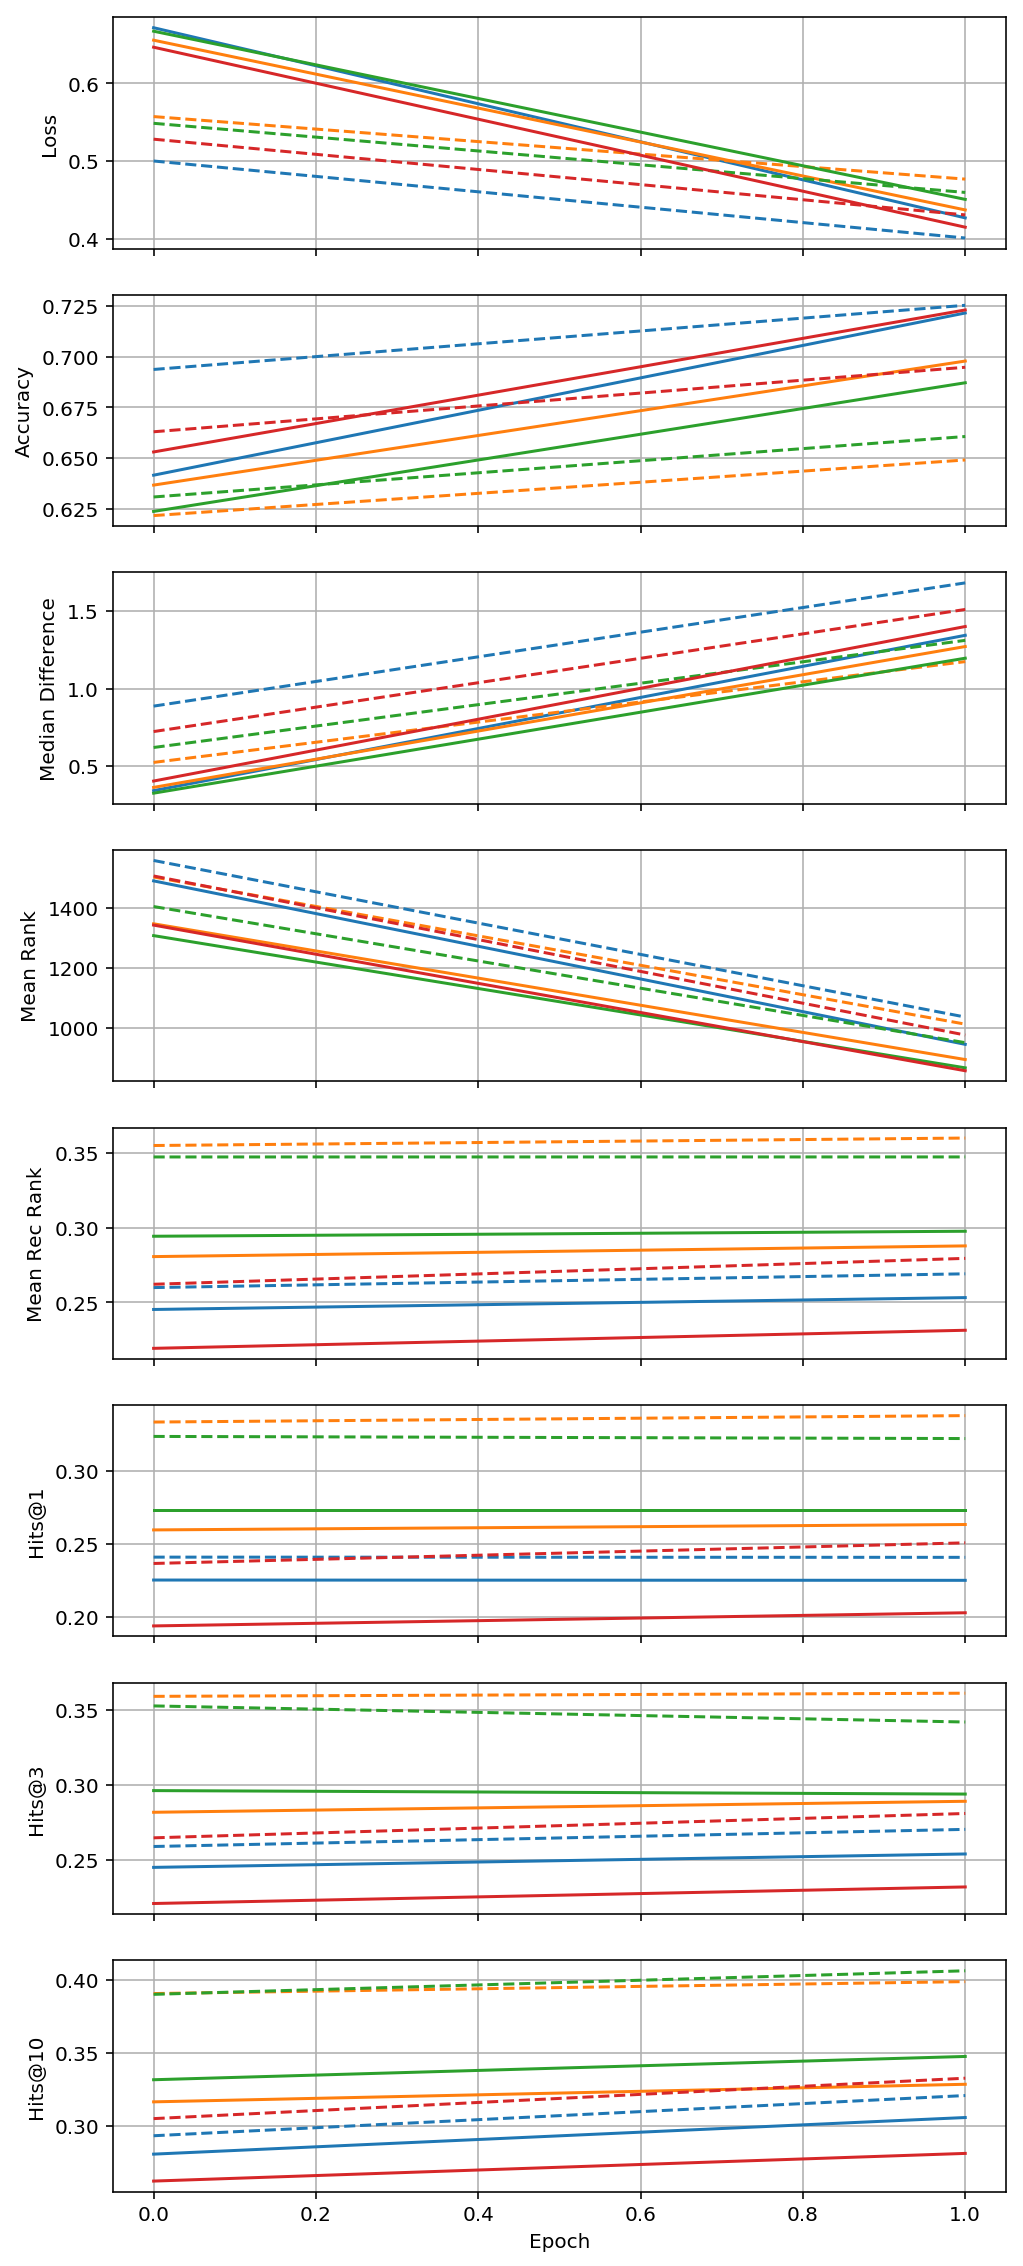

In [25]:
to_plot = ['loss', 'acc', 'median_diff', 'mean_rank', 'mean_rec_rank', 'hits_1', 'hits_3', 'hits_10']
figsize = (8, 20)

# TODO: Make fig legend for compare histories.
histories[0].plot(*to_plot, figsize=figsize, compare=histories[1:])#, xlim=(0, 10))

In [35]:
np.mean([max(h['val_mean_rec_rank']) for h in histories]), np.std([max(h['val_mean_rec_rank']) for h in histories]) / np.sqrt(len(histories))

(0.32256140108953557, 0.02670228591401082)

In [22]:
for i, h in enumerate(histories):
    h.save('logs/13-{}_filtered-ranking_same-parameters-with-different-seeds.tsv'.format(i))

In [20]:
!ls logs

10_rgcn_new-ranking-algorithm_filtered-ranking-on-complete-val-set.tsv
11_dist-mult.tsv
12_rgcn_new-one-hot-embedding_raw-ranking.tsv
13-0_filtered-ranking_same-parameters-with-different-seeds.tsv
13-1_filtered-ranking_same-parameters-with-different-seeds.tsv
13-2_filtered-ranking_same-parameters-with-different-seeds.tsv
13-3_filtered-ranking_same-parameters-with-different-seeds.tsv
13-4_filtered-ranking_same-parameters-with-different-seeds.tsv
13-5_filtered-ranking_same-parameters-with-different-seeds.tsv
13-6_filtered-ranking_same-parameters-with-different-seeds.tsv
14-0_only-weight-initialization-seeded.tsv
14-1_only-weight-initialization-seeded.tsv
14-2_only-weight-initialization-seeded.tsv
14-3_only-weight-initialization-seeded.tsv
15-0_only-training-loop-seeded.tsv
15-1_only-training-loop-seeded.tsv
15-2_only-training-loop-seeded.tsv
15-3_only-training-loop-seeded.tsv
16-0_DistMult-unseeded.tsv
16-1_DistMult-unseeded.tsv
16-2_DistMult-unseeded.tsv
16-3_DistMult-unseeded.tsv
1_lin

## Evaluation plots

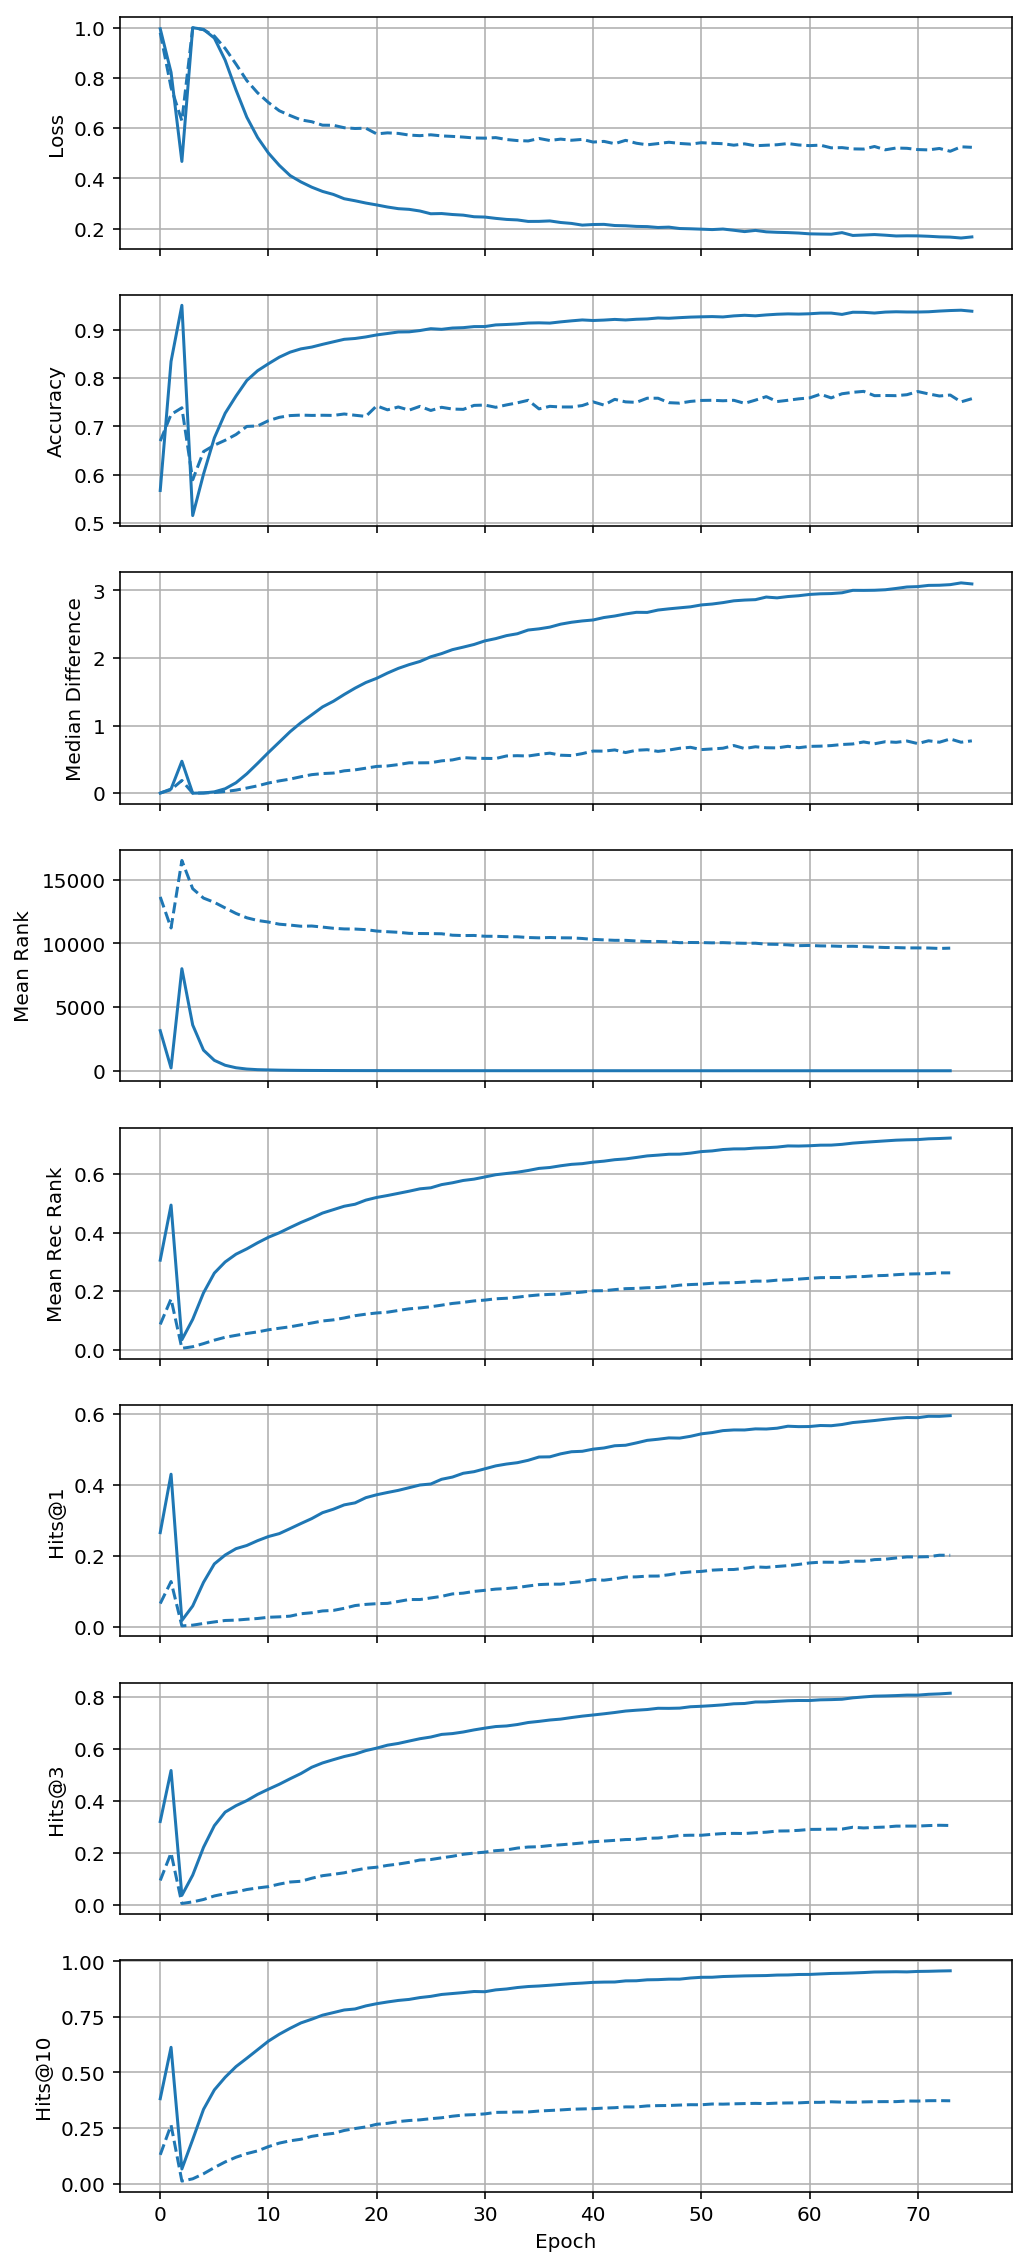

In [29]:
to_plot = ['loss', 'acc', 'median_diff', 'mean_rank', 'mean_rec_rank', 'hits_1', 'hits_3', 'hits_10']
figsize = (8, 20)

# TODO: Make fig legend for compare histories.
history.plot(*to_plot, figsize=figsize)#, compare=['logs/10_rgcn_new-ranking-algorithm_filtered-ranking-on-complete-val-set.tsv', 'logs/11_dist-mult.tsv'], xlim=(0, 10))

In [35]:
history

History([(u'loss',
          [0.9999992251396179,
           0.640682081500049,
           0.419742116938509,
           0.3679905759279291,
           0.34548194087106077,
           0.3332863565059493,
           0.3218788830537142,
           0.3156644727636973,
           0.31126186034711373,
           0.30604466109695166,
           0.30293388417808065,
           0.3000387746620808,
           0.2970968564027817,
           0.2955318395287562,
           0.2915853128872763,
           0.2906116736607726,
           0.2884252286861762,
           0.2887706640053817]),
         (u'val_loss',
          [1.000000238418579,
           0.5269286036491394,
           0.44198909401893616,
           0.4158141016960144,
           0.41089653968811035,
           0.40220916271209717,
           0.3876200020313263,
           0.3838272988796234,
           0.3877013325691223,
           0.381438285112381,
           0.3808366358280182,
           0.3816010355949402,
           0.3743936717

In [34]:
utils.History.load('logs/10_rgcn_new-ranking-algorithm_filtered-ranking-on-complete-val-set.tsv')

History([(u'loss',
          [0.6458190143378215,
           0.4151675177962359,
           0.3588659521674182,
           0.3351318985372712,
           0.324361161133476,
           0.3119666031969191,
           0.3058372756706328]),
         (u'val_loss',
          [0.5186784267425537,
           0.4279846549034119,
           0.3979269564151764,
           0.3932061493396759,
           0.3794955909252167,
           0.3734971582889557,
           0.370147705078125]),
         (u'acc',
          [0.6533883435691962,
           0.7264532248015574,
           0.7442155703832154,
           0.7507384295942418,
           0.7543860938494652,
           0.7588692782332845,
           0.7608244340106326]),
         (u'val_acc',
          [0.668605625629425,
           0.6979184746742249,
           0.7045907974243164,
           0.7033932209014893,
           0.7113202214241028,
           0.7131451368331909,
           0.7128029465675354]),
         (u'mean_diff',
          [0.91429425

In [32]:
h

History([(u'loss',
          [0.8300244239590859,
           0.2855591758952484,
           0.1325575794585694,
           0.0949638828802556,
           0.08158591837181534,
           0.07362427730078222,
           0.07140963013601066,
           0.06918478993894331,
           0.06619316492223568,
           0.06426548083143717,
           0.06319143147201664,
           0.06233660620177271,
           0.06165452843912205,
           0.06064485566058001,
           0.060118508571846474,
           0.06044520989523872,
           0.05972802620652716,
           0.05871165313964723]),
         (u'val_loss',
          [0.5290111303329468,
           0.20721979439258573,
           0.14229987561702728,
           0.12779878079891205,
           0.11618415266275404,
           0.10611139982938766,
           0.1086510568857193,
           0.1045783832669258,
           0.09825921058654784,
           0.10243906080722807,
           0.0998235121369362,
           0.09819545596837996,
   

In [36]:
test_ranker = RankingEvaluation(test_triples_arr, num_nodes, filtered=False, show_progress=True)

In [37]:
test_ranker(embedding_func, scoring_func, show_progress=True)

HBox(children=(IntProgress(value=0, max=20466), HTML(value=u'')))

(731.0324684843155,
 0.3251727414839853,
 0.29688263461350534,
 0.32497801231310464,
 0.37493892309195737)

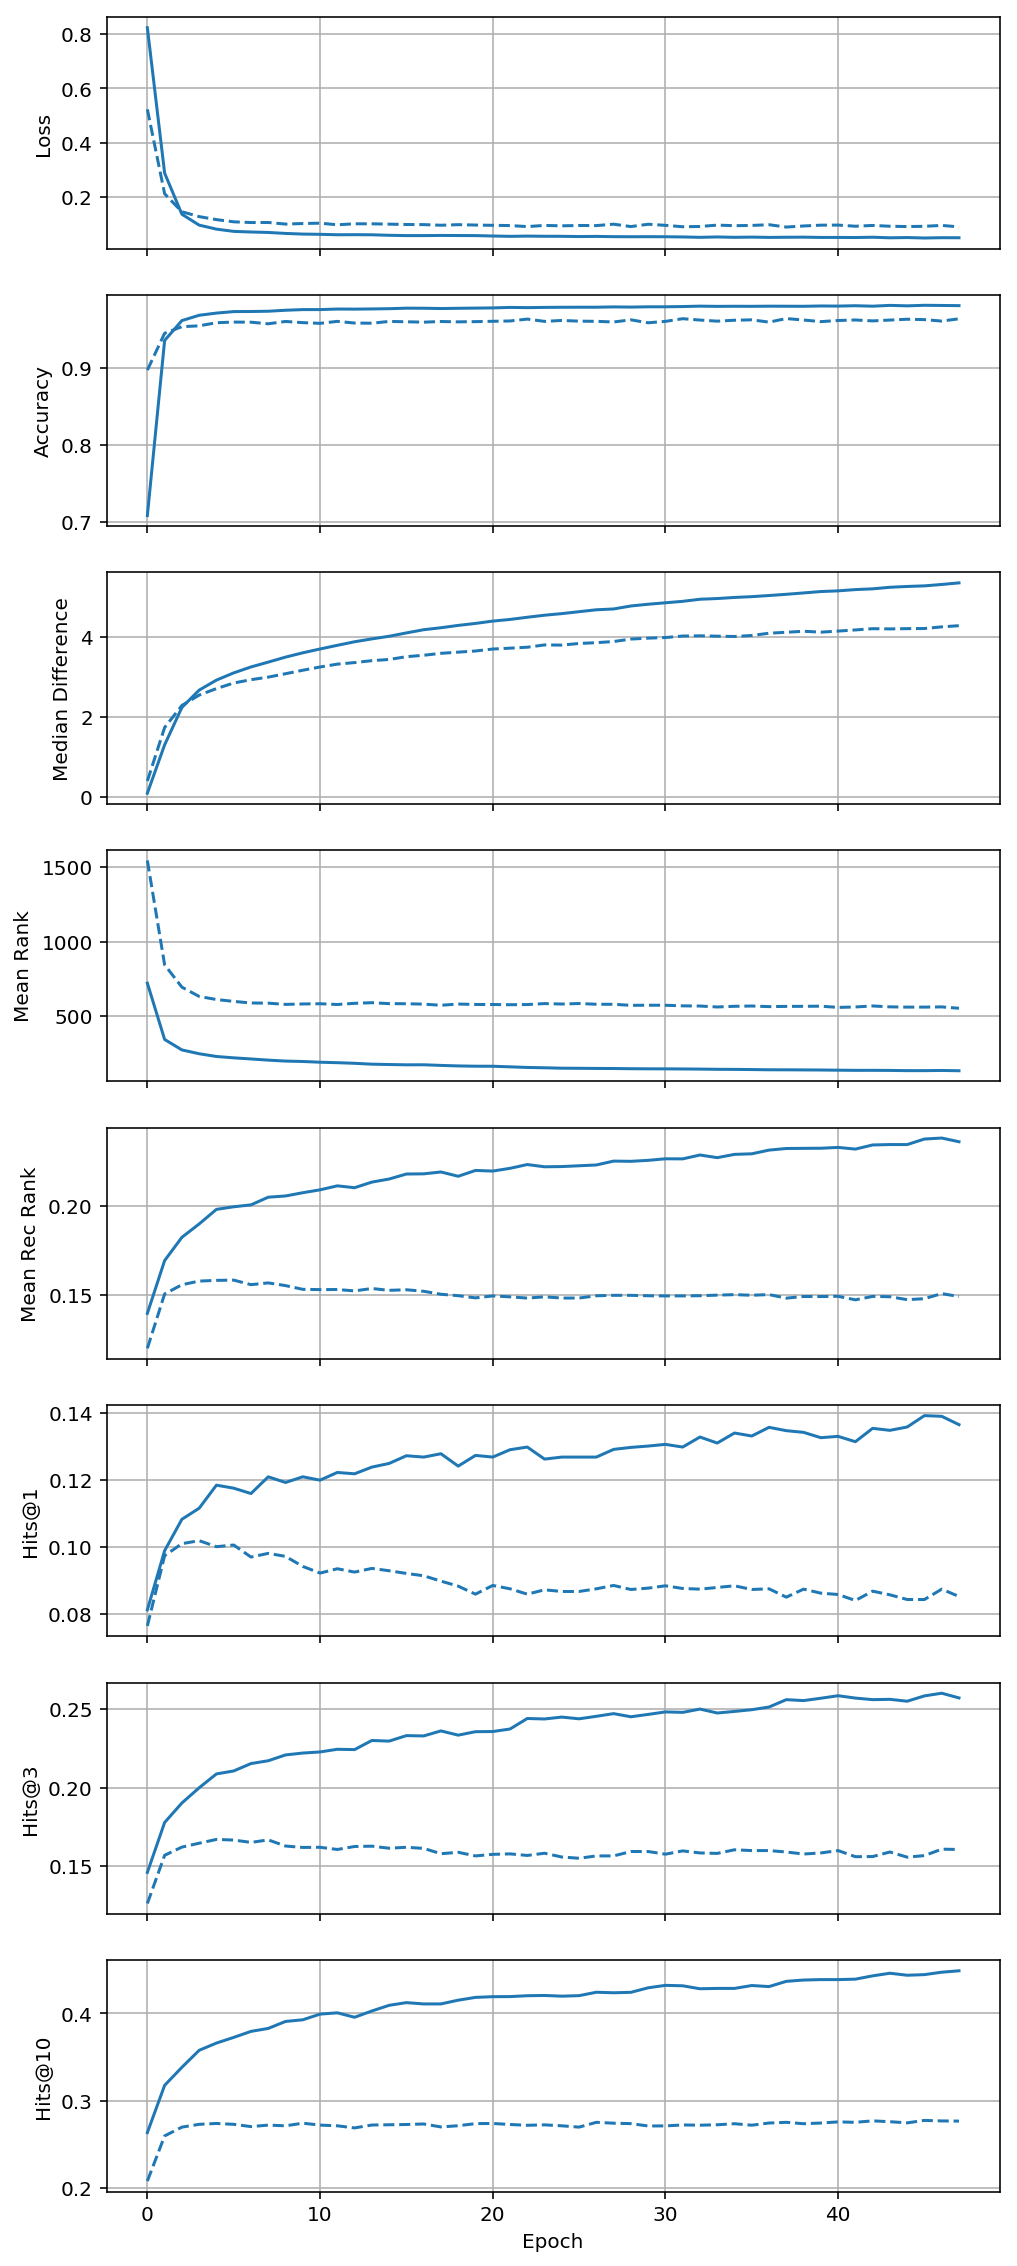

In [33]:
utils.History.load('logs/9_dist-mult-same-parameters.tsv').plot(*to_plot, figsize=figsize)

In [39]:
#history.save('logs/12_rgcn_new-one-hot-embedding_raw-ranking.tsv')

In [23]:
!ls logs

10_rgcn_new-ranking-algorithm_filtered-ranking-on-complete-val-set.tsv
11_dist-mult.tsv
12_rgcn_new-one-hot-embedding_raw-ranking.tsv
13-0_filtered-ranking_same-parameters-with-different-seeds.tsv
13-1_filtered-ranking_same-parameters-with-different-seeds.tsv
13-2_filtered-ranking_same-parameters-with-different-seeds.tsv
13-3_filtered-ranking_same-parameters-with-different-seeds.tsv
13-4_filtered-ranking_same-parameters-with-different-seeds.tsv
13-5_filtered-ranking_same-parameters-with-different-seeds.tsv
13-6_filtered-ranking_same-parameters-with-different-seeds.tsv
1_link-prediction-movielens-baseline.tsv
2_filtered-ranking-evaluation.tsv
3_directed-edges-in-adj-lists.tsv
4_batch-size-128-and-refactoring.tsv
5_sampling-over-all-relations-and-raw-ranking-and-undirected-edges.tsv
6_fb15k-237_embedding-size-200_batch-size-32_raw-ranking-over-300-samples.tsv
7_multiple-relations-per-edge_raw-ranking-over-5000-samples.tsv
8_train-test-split-for-adj-dict_actual-train-and-val-sets.tsv
9_di

# Calculate feature vectors for images

In [4]:
from torchvision import models, datasets, transforms
from torch.utils.data import DataLoader
from PIL import Image  # install pillow-simd instead of the default pillow version for a ~10 % speedup

In [5]:
image_model = models.vgg19_bn(pretrained=True)
image_model.classifier = nn.Sequential(*list(image_model.classifier.children())[:-1])  # remove last fully-connected layer
if torch.cuda.is_available():
    image_model.cuda()
image_model.eval();

In [6]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [9]:
images_root_dir = '../data/fb15k-237-onoro-rubio/image-graph_images'
feature_tensors_per_mid = {}

for mid in tqdm_notebook(os.listdir(images_root_dir)):
    if os.path.isdir(os.path.join(images_root_dir, mid)):
        #print(mid)
        img_tensors = []
        for filename in os.listdir(os.path.join(images_root_dir, mid)):
            try:
                img = Image.open(os.path.join(images_root_dir, mid, filename))
            except IOError:
                print('Could not read image:', os.path.join(images_root_dir, mid, filename))
            else:
                img_tensors.append(transform(img)[None])
        img_tensors = Variable(torch.cat(img_tensors), volatile=True)
        if torch.cuda.is_available():
            img_tensors = img_tensors.cuda()
        feature_tensors = image_model(img_tensors)
        feature_tensors_per_mid[mid] = feature_tensors.data.cpu().numpy()

HBox(children=(IntProgress(value=0, max=10222), HTML(value=u'')))

Could not read image: ../data/fb15k-237-onoro-rubio/image-graph_images/m.0g5ptf/google_24.jpg
Could not read image: ../data/fb15k-237-onoro-rubio/image-graph_images/m.06cmd2/bing_0.jpg
Could not read image: ../data/fb15k-237-onoro-rubio/image-graph_images/m.01m4pc/google_14.jpg
Could not read image: ../data/fb15k-237-onoro-rubio/image-graph_images/m.034bs/bing_13.jpg
Could not read image: ../data/fb15k-237-onoro-rubio/image-graph_images/m.01j_9c/bing_24.jpg
Could not read image: ../data/fb15k-237-onoro-rubio/image-graph_images/m.0cnl1c/google_0.jpg
Could not read image: ../data/fb15k-237-onoro-rubio/image-graph_images/m.0cv_2/google_16.jpg
Could not read image: ../data/fb15k-237-onoro-rubio/image-graph_images/m.0f5xn/google_3.jpg



In [10]:
len(feature_tensors_per_mid)

10221

In [15]:
feature_tensors_per_mid.keys()[:5]

[u'm.0gcrg', u'm.01bl7g', u'm.0dwxr', u'm.0g28b1', u'm.01yqp']

In [19]:
feature_tensors_per_mid['m.0gcrg'][0]

0.19283886

In [13]:
# TDOO: Maybe save torch tensors directly. See how this compares to npz format in terms of file size.
#np.savez_compressed('../data/fb15k-237-onoro-rubio/feature-vectors-vgg19_bn.npz', **feature_tensors_per_mid)

In [24]:
!ls -lh '../data/fb15k-237-onoro-rubio/feature-vectors-vgg19_bn.npz'

-rw-rw-r-- 1 jrieke jrieke 4.7G Mar 25 05:18 ../data/fb15k-237-onoro-rubio/feature-vectors-vgg19_bn.npz


In [ ]:
# TODO: Implement this faster version with pytorch's DataSet and DataLoader.
image_dataset = datasets.ImageFolder(images_root_dir, transform=transform)
print(image_dataset.classes)
image_loader = DataLoader(image_dataset, batch_size=32, shuffle=False, num_workers=5, pin_memory=False)
for images, labels in tqdm_notebook(image_loader):
    images = Variable(images, volatile=True).cuda()
    feature_tensors = image_model(images).data.cpu().numpy()